In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, auc)
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model

# Imbalanced learning
print(f"TensorFlow Version: {tf.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Imbalanced-learn imports (SMOTE etc.)
from imblearn.over_sampling import SMOTE


TensorFlow Version: 2.20.0


ModuleNotFoundError: No module named 'imblearn'

### Data Loading

In [17]:
from ucimlrepo import fetch_ucirepo

# Fetch SUPPORT dataset
support_dataset = fetch_ucirepo(id=880)
X = support_dataset.data.features
y = support_dataset.data.targets

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Select the primary binary target if targets is a DataFrame (e.g., 'death')
if isinstance(y, pd.DataFrame) and 'death' in y.columns:
	y_target = y['death']
else:
	# squeeze to a Series if possible
	y_target = y.squeeze()

vc = y_target.value_counts()
print(f"\nTarget distribution:\n{vc}")

# compute class imbalance ratio safely (handle missing classes / zero division)
pos = vc.get(1, 0)
neg = vc.get(0, 0)
if neg > 0:
	ratio = pos / neg
	print(f"\nClass imbalance ratio: {ratio:.2f}:1")
else:
	print("\nClass imbalance ratio: undefined (no negative class instances)")

print(f"\nMissing values:\n{X.isnull().sum().sort_values(ascending=False).head(15)}")

DATASET OVERVIEW
Features shape: (9105, 42)
Target shape: (9105, 3)

Target distribution:
death
1    6201
0    2904
Name: count, dtype: int64

Class imbalance ratio: 2.14:1

Missing values:
adlp       5641
urine      4862
glucose    4500
bun        4352
totmcst    3475
alb        3372
income     2982
adls       2867
bili       2601
pafi       2325
ph         2284
prg2m      1649
edu        1634
prg6m      1633
totcst      888
dtype: int64



Dataset Info:
Total patients: 9105
Mortality rate: 68.11%
Survival rate: 31.89%

Numeric features: 35
Categorical features: 7

Categorical columns: ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca', 'dnr']


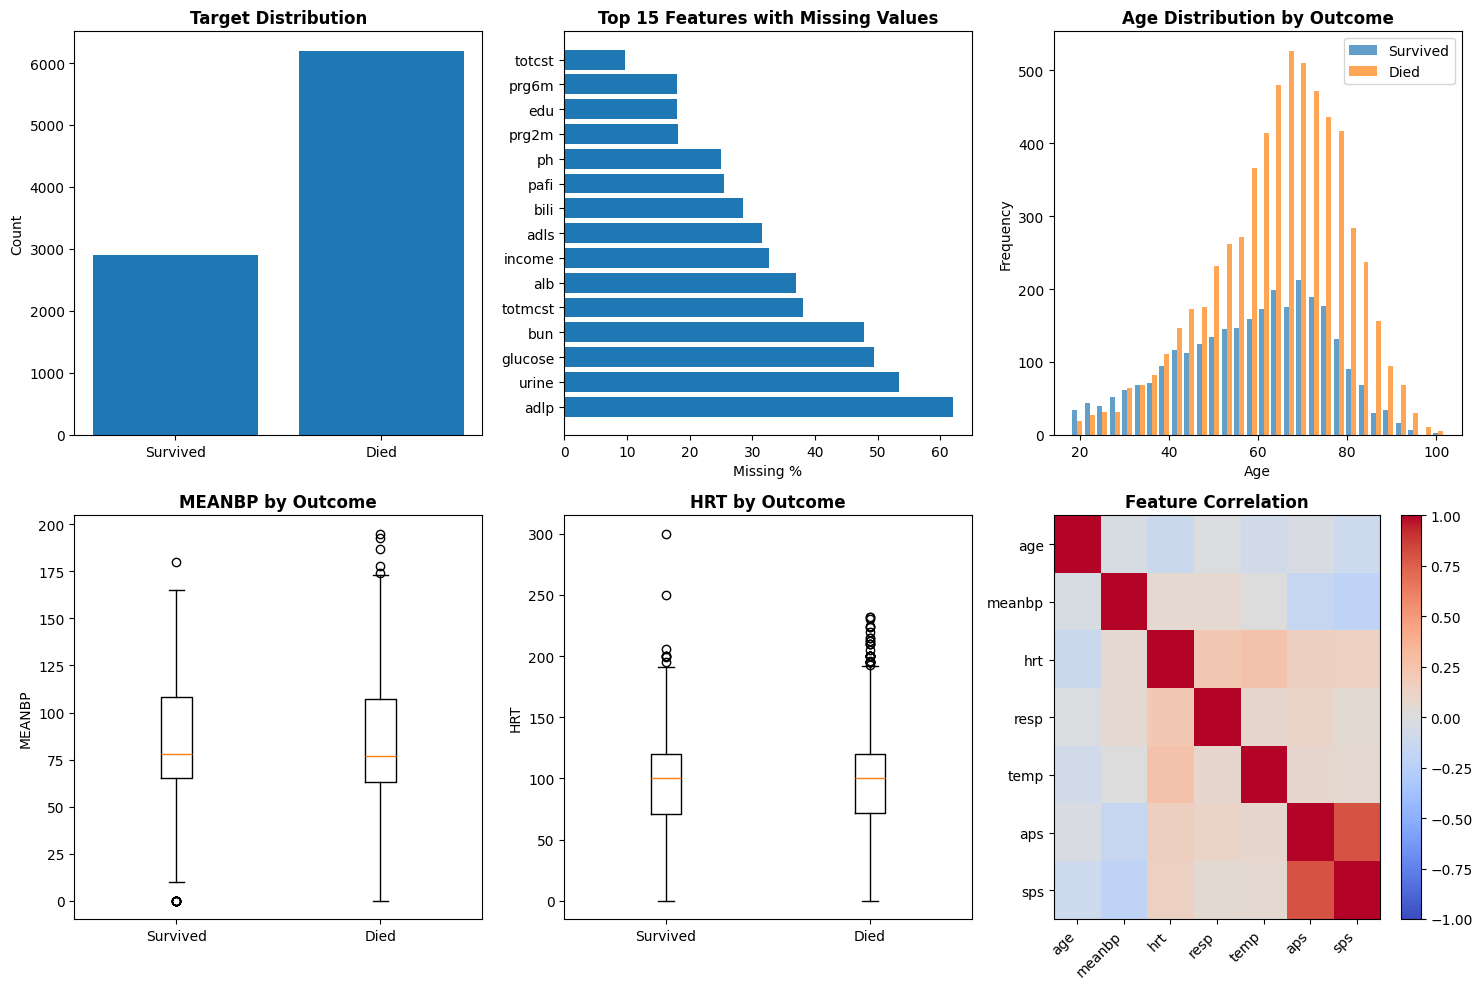

In [18]:
# Combine for EDA
df = pd.concat([X, y], axis=1)

# Basic statistics
print("\nDataset Info:")
print(f"Total patients: {len(df)}")
print(f"Mortality rate: {(y['death']==1).sum()/len(y)*100:.2f}%")
print(f"Survival rate: {(y['death']==0).sum()/len(y)*100:.2f}%")

# Feature types
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumeric features: {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"\nCategorical columns: {categorical_cols}")

# Visualization 1: Target distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Target distribution (use the death column, y is a DataFrame so y.value_counts() yields combinations)
target_counts = y['death'].value_counts().sort_index()
labels = ['Survived' if idx == 0 else 'Died' for idx in target_counts.index]
axes[0, 0].bar(labels, target_counts.values)
axes[0, 0].set_title('Target Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Count')

# Missing values heatmap
missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False).head(15)
axes[0, 1].barh(range(len(missing_pct)), missing_pct.values)
axes[0, 1].set_yticks(range(len(missing_pct)))
axes[0, 1].set_yticklabels(missing_pct.index)
axes[0, 1].set_xlabel('Missing %')
axes[0, 1].set_title('Top 15 Features with Missing Values', fontsize=12, fontweight='bold')

# Age distribution by outcome
if 'age' in X.columns:
    axes[0, 2].hist([X[y['death']==0]['age'].dropna(), 
                     X[y['death']==1]['age'].dropna()],
                    label=['Survived', 'Died'], bins=30, alpha=0.7)
    axes[0, 2].set_xlabel('Age')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Age Distribution by Outcome', fontsize=12, fontweight='bold')
    axes[0, 2].legend()

# Vital signs correlation with mortality
vital_signs = ['meanbp', 'hrt', 'resp', 'temp']
available_vitals = [v for v in vital_signs if v in X.columns]
if len(available_vitals) >= 2:
    for idx, vital in enumerate(available_vitals[:2]):
        row = 1
        col = idx
        axes[row, col].boxplot([X[y['death']==0][vital].dropna(), 
                                X[y['death']==1][vital].dropna()],
                               labels=['Survived', 'Died'])
        axes[row, col].set_ylabel(vital.upper())
        axes[row, col].set_title(f'{vital.upper()} by Outcome', fontsize=12, fontweight='bold')

# Correlation heatmap for key numeric features
key_features = ['age', 'meanbp', 'hrt', 'resp', 'temp', 'aps', 'sps']
available_key = [f for f in key_features if f in X.columns]
if len(available_key) > 0:
    corr_data = X[available_key].corr()
    im = axes[1, 2].imshow(corr_data, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[1, 2].set_xticks(range(len(available_key)))
    axes[1, 2].set_yticks(range(len(available_key)))
    axes[1, 2].set_xticklabels(available_key, rotation=45, ha='right')
    axes[1, 2].set_yticklabels(available_key)
    axes[1, 2].set_title('Feature Correlation', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=axes[1, 2])

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# PART 4: DATA PREPROCESSING & FEATURE ENGINEERING
# ============================================================================
print("\n" + "="*80)
print("DATA PREPROCESSING & FEATURE ENGINEERING")
print("="*80)

# Create a copy for preprocessing
X_processed = X.copy()
y_processed = y.copy()

# Step 1: Handle categorical variables
print("\n[1] Encoding Categorical Variables...")
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Handle missing values in categorical
    X_processed[col] = X_processed[col].fillna('missing')
    X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    label_encoders[col] = le
    print(f"   - {col}: {len(le.classes_)} categories")


DATA PREPROCESSING & FEATURE ENGINEERING

[1] Encoding Categorical Variables...
   - sex: 2 categories
   - dzgroup: 8 categories
   - dzclass: 4 categories
   - income: 5 categories
   - race: 6 categories
   - ca: 3 categories
   - dnr: 4 categories


### FEATURE ENGINEERING

In [20]:
# Step 2: Feature Engineering
print("\n[2] Feature Engineering...")

# Age groups
if 'age' in X_processed.columns:
    X_processed['age_group'] = pd.cut(X_processed['age'], 
                                       bins=[0, 40, 60, 75, 120],
                                       labels=[0, 1, 2, 3])
    X_processed['age_group'] = X_processed['age_group'].astype(float)
    print("   - Created: age_group")

# Severity scores interaction
if 'aps' in X_processed.columns and 'sps' in X_processed.columns:
    X_processed['severity_score'] = X_processed['aps'] * X_processed['sps']
    print("   - Created: severity_score (aps * sps)")

# Vital signs abnormality flags
if 'meanbp' in X_processed.columns:
    X_processed['hypotension'] = (X_processed['meanbp'] < 65).astype(int)
    print("   - Created: hypotension (meanbp < 65)")

if 'hrt' in X_processed.columns:
    X_processed['tachycardia'] = (X_processed['hrt'] > 100).astype(int)
    X_processed['bradycardia'] = (X_processed['hrt'] < 60).astype(int)
    print("   - Created: tachycardia, bradycardia")

if 'temp' in X_processed.columns:
    X_processed['fever'] = (X_processed['temp'] > 38).astype(int)
    X_processed['hypothermia'] = (X_processed['temp'] < 36).astype(int)
    print("   - Created: fever, hypothermia")

# Comorbidity count
comorbidity_cols = ['diabetes', 'dementia', 'ca']
available_comorbid = [c for c in comorbidity_cols if c in X_processed.columns]
if len(available_comorbid) > 0:
    X_processed['comorbidity_count'] = X_processed[available_comorbid].sum(axis=1)
    print("   - Created: comorbidity_count")

# Lab abnormalities
lab_features = {
    'crea': (1.2, 'high_creatinine'),  # Renal dysfunction
    'bili': (1.2, 'high_bilirubin'),   # Liver dysfunction
    'wblc': (11, 'high_wbc'),          # Infection
    'glucose': (180, 'hyperglycemia')  # Diabetes control
}

for lab, (threshold, name) in lab_features.items():
    if lab in X_processed.columns:
        X_processed[name] = (X_processed[lab] > threshold).astype(int)
        print(f"   - Created: {name}")

print(f"\nTotal features after engineering: {X_processed.shape[1]}")

# Step 3: Handle Missing Values
print("\n[3] Imputation Strategy...")
print("   Missing value patterns:")

# Identify features with different missing patterns
high_missing = X_processed.columns[X_processed.isnull().sum() > len(X_processed) * 0.5].tolist()
medium_missing = X_processed.columns[(X_processed.isnull().sum() > len(X_processed) * 0.1) & 
                                      (X_processed.isnull().sum() <= len(X_processed) * 0.5)].tolist()
low_missing = X_processed.columns[(X_processed.isnull().sum() > 0) & 
                                   (X_processed.isnull().sum() <= len(X_processed) * 0.1)].tolist()

print(f"   - High missing (>50%): {len(high_missing)} features")
print(f"   - Medium missing (10-50%): {len(medium_missing)} features")
print(f"   - Low missing (<10%): {len(low_missing)} features")

# Drop high missing features
if len(high_missing) > 0:
    print(f"\n   Dropping {len(high_missing)} features with >50% missing: {high_missing}")
    X_processed = X_processed.drop(columns=high_missing)

# For remaining features, use KNN imputation for clinical relevance
print("\n   Using KNN Imputation for remaining features...")
imputer = KNNImputer(n_neighbors=5, weights='distance')
X_processed = pd.DataFrame(
    imputer.fit_transform(X_processed),
    columns=X_processed.columns,
    index=X_processed.index
)

print(f"   Remaining missing values: {X_processed.isnull().sum().sum()}")

# Step 4: Outlier Detection (IQR method for key features)
print("\n[4] Outlier Detection...")
outlier_features = ['age', 'meanbp', 'hrt', 'resp', 'temp']
available_outlier = [f for f in outlier_features if f in X_processed.columns]

for col in available_outlier:
    Q1 = X_processed[col].quantile(0.01)
    Q3 = X_processed[col].quantile(0.99)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = ((X_processed[col] < lower) | (X_processed[col] > upper)).sum()
    if outliers > 0:
        # Cap outliers instead of removing
        X_processed[col] = X_processed[col].clip(lower=lower, upper=upper)
        print(f"   - {col}: {outliers} outliers capped")

# Step 5: Feature Selection
print("\n[5] Feature Selection...")

# Remove constant or near-constant features
constant_features = [col for col in X_processed.columns 
                     if X_processed[col].nunique() <= 1]
if len(constant_features) > 0:
    print(f"   Removing {len(constant_features)} constant features")
    X_processed = X_processed.drop(columns=constant_features)

# Statistical feature selection
# Use the correct 1D target vector (death) and ensure alignment with X_processed
# Prefer the y_target Series (death) if available in the notebook
if 'y_target' in globals():
    y_for_fs = y_target.loc[X_processed.index]
else:
    # fallback to previously used y_processed (flattened) if y_target is not present
    y_for_fs = pd.Series(y_processed.values.ravel(), index=X_processed.index)

# If there are any NaNs in the target, drop those rows for feature selection
if y_for_fs.isnull().any():
    valid_idx = y_for_fs.dropna().index
    X_fs = X_processed.loc[valid_idx]
    y_fs = y_for_fs.loc[valid_idx]
else:
    X_fs = X_processed
    y_fs = y_for_fs

selector = SelectKBest(f_classif, k=min(30, X_fs.shape[1]))
X_selected = selector.fit_transform(X_fs, y_fs)
selected_features = X_fs.columns[selector.get_support()].tolist()

print(f"   Selected {len(selected_features)} most important features")
print(f"   Top 10 features by F-score:")
feature_scores = pd.DataFrame({
    'feature': X_fs.columns,
    'score': selector.scores_
}).sort_values('score', ascending=False).head(10)
print(feature_scores.to_string(index=False))

# Use all features for now (we'll compare with selected features later)
X_final = X_processed.copy()

print(f"\nFinal feature matrix shape: {X_final.shape}")



[2] Feature Engineering...
   - Created: age_group
   - Created: severity_score (aps * sps)
   - Created: hypotension (meanbp < 65)
   - Created: tachycardia, bradycardia
   - Created: fever, hypothermia
   - Created: comorbidity_count
   - Created: high_creatinine
   - Created: high_bilirubin
   - Created: high_wbc
   - Created: hyperglycemia

Total features after engineering: 54

[3] Imputation Strategy...
   Missing value patterns:
   - High missing (>50%): 2 features
   - Medium missing (10-50%): 11 features
   - Low missing (<10%): 17 features

   Dropping 2 features with >50% missing: ['urine', 'adlp']

   Using KNN Imputation for remaining features...
   Remaining missing values: 0

[4] Outlier Detection...

[5] Feature Selection...
   Selected 30 most important features
   Top 10 features by F-score:
       feature       score
        surv6m 1519.092691
           dnr 1516.158445
         prg6m 1317.243874
        surv2m 1074.876049
         prg2m  829.978630
       dzgroup  6

### DATA SPLITTING

In [22]:
# ============================================================================
# PART 5: TRAIN-TEST SPLIT
# ============================================================================
print("\n" + "="*80)
print("DATA SPLITTING")
print("="*80)

# Use a 1D target vector for splitting/stratification (prefer y_target if available)
if 'y_target' in globals():
    y_split = y_target
else:
    # fallback to the 'death' column from y_processed if present
    if isinstance(y_processed, pd.DataFrame) and 'death' in y_processed.columns:
        y_split = y_processed['death']
    else:
        # last resort: flatten y_processed (ensure index alignment)
        y_split = pd.Series(y_processed.values.ravel(), index=X_final.index)

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_split, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_split
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining set distribution:\n{y_train.value_counts()}")
print(f"\nTest set distribution:\n{y_test.value_counts()}")

# Scale features
scaler = RobustScaler()  # RobustScaler is better for outliers
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Compute class weights for imbalanced data (map classes to their weights robustly)
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train.values.ravel())
class_weight_dict = dict(zip(classes.tolist(), class_weights.tolist()))

print(f"\nClass weights: {class_weight_dict}")

print("\n✓ Preprocessing Complete!")
print("="*80)



DATA SPLITTING
Training set: (7284, 52)
Test set: (1821, 52)

Training set distribution:
death
1    4961
0    2323
Name: count, dtype: int64

Test set distribution:
death
1    1240
0     581
Name: count, dtype: int64

Class weights: {0: 1.5678002582866983, 1: 0.734126184237049}

✓ Preprocessing Complete!


#### EVALUATION MATRIX FUNCTIONS

In [23]:
# ============================================================================
# PART 6: EVALUATION METRICS FUNCTIONS
# ============================================================================

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    
    # Predictions
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_test)
    
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Precision-Recall AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn)  # Recall
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp)  # Precision
    npv = tn / (tn + fn)
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'PPV': ppv,
        'NPV': npv,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    }
    
    return results, y_pred_proba

def plot_model_comparison(results_df, save_name='model_comparison.png'):
    """Visualize model comparison"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # ROC-AUC comparison
    axes[0, 0].barh(results_df['Model'], results_df['ROC-AUC'], color='steelblue')
    axes[0, 0].set_xlabel('ROC-AUC Score')
    axes[0, 0].set_title('Model Performance: ROC-AUC', fontweight='bold')
    axes[0, 0].set_xlim(0.5, 1.0)
    
    # F1-Score comparison
    axes[0, 1].barh(results_df['Model'], results_df['F1-Score'], color='coral')
    axes[0, 1].set_xlabel('F1-Score')
    axes[0, 1].set_title('Model Performance: F1-Score', fontweight='bold')
    axes[0, 1].set_xlim(0, 1.0)
    
    # Sensitivity vs Specificity
    x = np.arange(len(results_df))
    width = 0.35
    axes[1, 0].bar(x - width/2, results_df['Sensitivity'], width, label='Sensitivity', color='green', alpha=0.7)
    axes[1, 0].bar(x + width/2, results_df['Specificity'], width, label='Specificity', color='orange', alpha=0.7)
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Sensitivity vs Specificity', fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[1, 0].legend()
    
    # Metrics heatmap
    metrics_to_plot = ['Accuracy', 'F1-Score', 'ROC-AUC', 'Sensitivity', 'Specificity']
    heatmap_data = results_df[metrics_to_plot].T
    im = axes[1, 1].imshow(heatmap_data, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    axes[1, 1].set_xticks(range(len(results_df)))
    axes[1, 1].set_yticks(range(len(metrics_to_plot)))
    axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[1, 1].set_yticklabels(metrics_to_plot)
    axes[1, 1].set_title('All Metrics Heatmap', fontweight='bold')
    
    # Add values to heatmap
    for i in range(len(metrics_to_plot)):
        for j in range(len(results_df)):
            text = axes[1, 1].text(j, i, f'{heatmap_data.iloc[i, j]:.3f}',
                                  ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im, ax=axes[1, 1])
    plt.tight_layout()
    plt.savefig(save_name, dpi=300, bbox_inches='tight')

In [24]:
# ============================================================================
# HELPER FUNCTIONS FOR COMPREHENSIVE VISUALIZATION
# ============================================================================

def plot_experiment_results(model, X_train, y_train, X_test, y_test, 
                           y_pred, y_pred_proba, model_name, 
                           history=None, hyperparams=None, experiment_num=None):
    """
    Create comprehensive 6-subplot visualization for each experiment:
    1. Confusion Matrix
    2. ROC Curve
    3. Precision-Recall Curve
    4. Learning Curves (for DL) or Feature Importance (for ML)
    5. Metrics Bar Chart
    6. Hyperparameters Table
    """
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Title
    title = f"EXPERIMENT {experiment_num}: {model_name}" if experiment_num else model_name
    fig.suptitle(title, fontsize=20, fontweight='bold', y=0.98)
    
    # ========== SUBPLOT 1: Confusion Matrix ==========
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Survived (0)', 'Died (1)'],
                yticklabels=['Survived (0)', 'Died (1)'],
                cbar_kws={'label': 'Count'})
    ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=10)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    
    # Add percentage annotations
    for i in range(2):
        for j in range(2):
            percentage = cm[i, j] / cm.sum() * 100
            ax1.text(j+0.5, i+0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='red')
    
    # ========== SUBPLOT 2: ROC Curve ==========
    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, linewidth=3, label=f'ROC (AUC = {roc_auc:.4f})', color='darkblue')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    ax2.fill_between(fpr, tpr, alpha=0.3)
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.set_title('ROC Curve', fontsize=14, fontweight='bold', pad=10)
    ax2.legend(loc='lower right', fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # ========== SUBPLOT 3: Precision-Recall Curve ==========
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(recall, precision, linewidth=3, label=f'PR (AUC = {pr_auc:.4f})', color='darkgreen')
    ax3.axhline(y=y_test.mean(), color='r', linestyle='--', linewidth=2, 
                label=f'Baseline ({y_test.mean():.3f})')
    ax3.fill_between(recall, precision, alpha=0.3)
    ax3.set_xlabel('Recall (Sensitivity)', fontsize=12)
    ax3.set_ylabel('Precision (PPV)', fontsize=12)
    ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=10)
    ax3.legend(loc='upper right', fontsize=11)
    ax3.grid(True, alpha=0.3)
    
    # ========== SUBPLOT 4: Learning Curves or Feature Importance ==========
    ax4 = fig.add_subplot(gs[1, :])
    
    if history is not None:  # Deep Learning - Training History
        epochs = range(1, len(history.history['loss']) + 1)
        
        # Loss subplot
        ax4_loss = ax4
        ax4_loss.plot(epochs, history.history['loss'], 'b-', linewidth=2, 
                     label='Training Loss', marker='o', markersize=4)
        ax4_loss.plot(epochs, history.history['val_loss'], 'r-', linewidth=2, 
                     label='Validation Loss', marker='s', markersize=4)
        ax4_loss.set_xlabel('Epoch', fontsize=12)
        ax4_loss.set_ylabel('Loss', fontsize=12)
        ax4_loss.set_title('Learning Curves: Loss Over Epochs', fontsize=14, fontweight='bold')
        ax4_loss.legend(loc='upper right', fontsize=11)
        ax4_loss.grid(True, alpha=0.3)
        
        # Identify overfitting
        final_train_loss = np.mean(history.history['loss'][-5:])
        final_val_loss = np.mean(history.history['val_loss'][-5:])
        gap = final_val_loss - final_train_loss
        
        if gap > 0.1:
            ax4_loss.text(0.5, 0.95, '⚠️ OVERFITTING DETECTED (Val-Train gap > 0.1)', 
                         transform=ax4_loss.transAxes, fontsize=12, color='red',
                         ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        elif gap > 0.05:
            ax4_loss.text(0.5, 0.95, '⚡ Slight overfitting (Val-Train gap > 0.05)', 
                         transform=ax4_loss.transAxes, fontsize=11, color='orange',
                         ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
        else:
            ax4_loss.text(0.5, 0.95, '✓ Good generalization', 
                         transform=ax4_loss.transAxes, fontsize=11, color='green',
                         ha='center', va='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
    
    else:  # Traditional ML - Learning Curves via sklearn
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train.values.ravel() if hasattr(y_train, 'values') else y_train,
            cv=5, scoring='roc_auc', n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        ax4.plot(train_sizes, train_mean, 'o-', linewidth=2, label='Training Score', 
                color='blue', markersize=6)
        ax4.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                        alpha=0.2, color='blue')
        ax4.plot(train_sizes, val_mean, 'o-', linewidth=2, label='Cross-Validation Score',
                color='red', markersize=6)
        ax4.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                        alpha=0.2, color='red')
        
        ax4.set_xlabel('Training Set Size', fontsize=12)
        ax4.set_ylabel('ROC-AUC Score', fontsize=12)
        ax4.set_title('Learning Curves: Performance vs Training Size', fontsize=14, fontweight='bold')
        ax4.legend(loc='lower right', fontsize=11)
        ax4.grid(True, alpha=0.3)
        
        # Bias-Variance diagnosis
        final_gap = train_mean[-1] - val_mean[-1]
        if final_gap > 0.1:
            ax4.text(0.5, 0.15, '⚠️ HIGH VARIANCE (Overfitting)', 
                    transform=ax4.transAxes, fontsize=12, color='red',
                    ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
        elif val_mean[-1] < 0.7:
            ax4.text(0.5, 0.15, '⚠️ HIGH BIAS (Underfitting)', 
                    transform=ax4.transAxes, fontsize=12, color='red',
                    ha='center', bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))
    
    # ========== SUBPLOT 5: Metrics Bar Chart ==========
    ax5 = fig.add_subplot(gs[2, 0])
    metrics_names = ['Accuracy', 'F1-Score', 'ROC-AUC', 'PR-AUC', 
                     'Sensitivity', 'Specificity', 'PPV', 'NPV']
    metrics_values = [accuracy, f1, roc_auc, pr_auc, 
                     sensitivity, specificity, ppv, npv]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    bars = ax5.barh(metrics_names, metrics_values, color=colors, alpha=0.8)
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, metrics_values)):
        ax5.text(value + 0.02, i, f'{value:.4f}', va='center', fontsize=10, fontweight='bold')
    
    ax5.set_xlim(0, 1.1)
    ax5.set_xlabel('Score', fontsize=12)
    ax5.set_title('Performance Metrics', fontsize=14, fontweight='bold', pad=10)
    ax5.grid(True, axis='x', alpha=0.3)
    
    # ========== SUBPLOT 6: Hyperparameters & Model Info ==========
    ax6 = fig.add_subplot(gs[2, 1:])
    ax6.axis('off')
    
    # Create hyperparameters table
    if hyperparams:
        hp_text = "HYPERPARAMETERS & CONFIGURATION\n" + "="*50 + "\n\n"
        for key, value in hyperparams.items():
            hp_text += f"{key:30s}: {value}\n"
    else:
        hp_text = "HYPERPARAMETERS: Default settings used\n"
    
    # Add error analysis
    hp_text += f"\n{'='*50}\nERROR ANALYSIS\n{'='*50}\n"
    hp_text += f"True Negatives (TN):  {tn:5d}  (Correct: Survived predicted as Survived)\n"
    hp_text += f"False Positives (FP): {fp:5d}  (Error: Survived predicted as Died) ⚠️\n"
    hp_text += f"False Negatives (FN): {fn:5d}  (Error: Died predicted as Survived) ⚠️⚠️\n"
    hp_text += f"True Positives (TP):  {tp:5d}  (Correct: Died predicted as Died)\n"
    hp_text += f"\n{'='*50}\nCLINICAL IMPACT\n{'='*50}\n"
    hp_text += f"False Negatives are CRITICAL: Missing a death prediction means\n"
    hp_text += f"inadequate care planning and missed intervention opportunities.\n"
    hp_text += f"\nFalse Positives are COSTLY but SAFER: Over-cautious predictions\n"
    hp_text += f"lead to unnecessary ICU resources but better patient outcomes.\n"
    
    ax6.text(0.05, 0.95, hp_text, transform=ax6.transAxes, fontsize=11,
            verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Save figure
    save_name = f"experiment_{experiment_num}_{model_name.replace(' ', '_').lower()}.png"
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return metrics for summary table
    return {
        'Experiment': experiment_num,
        'Model': model_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'PPV': ppv,
        'NPV': npv,
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
    }

# ============================================================================
# EXPERIMENT TRACKING
# ============================================================================
all_results = []

print("="*80)
print("STARTING COMPREHENSIVE EXPERIMENTS")
print("="*80)
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Test samples: {X_test_scaled.shape[0]}")
print(f"Features: {X_train_scaled.shape[1]}")
print(f"Class distribution: {dict(y_train.value_counts())}")
print("="*80)

STARTING COMPREHENSIVE EXPERIMENTS
Training samples: 7284
Test samples: 1821
Features: 52
Class distribution: {1: np.int64(4961), 0: np.int64(2323)}


### TRADITIONAL MACHINE LEARNING

#### Logistic Regression- Baseline


EXPERIMENT 1: LOGISTIC REGRESSION (BASELINE)
[Training...]
[Predicting...]
[Visualizing...]


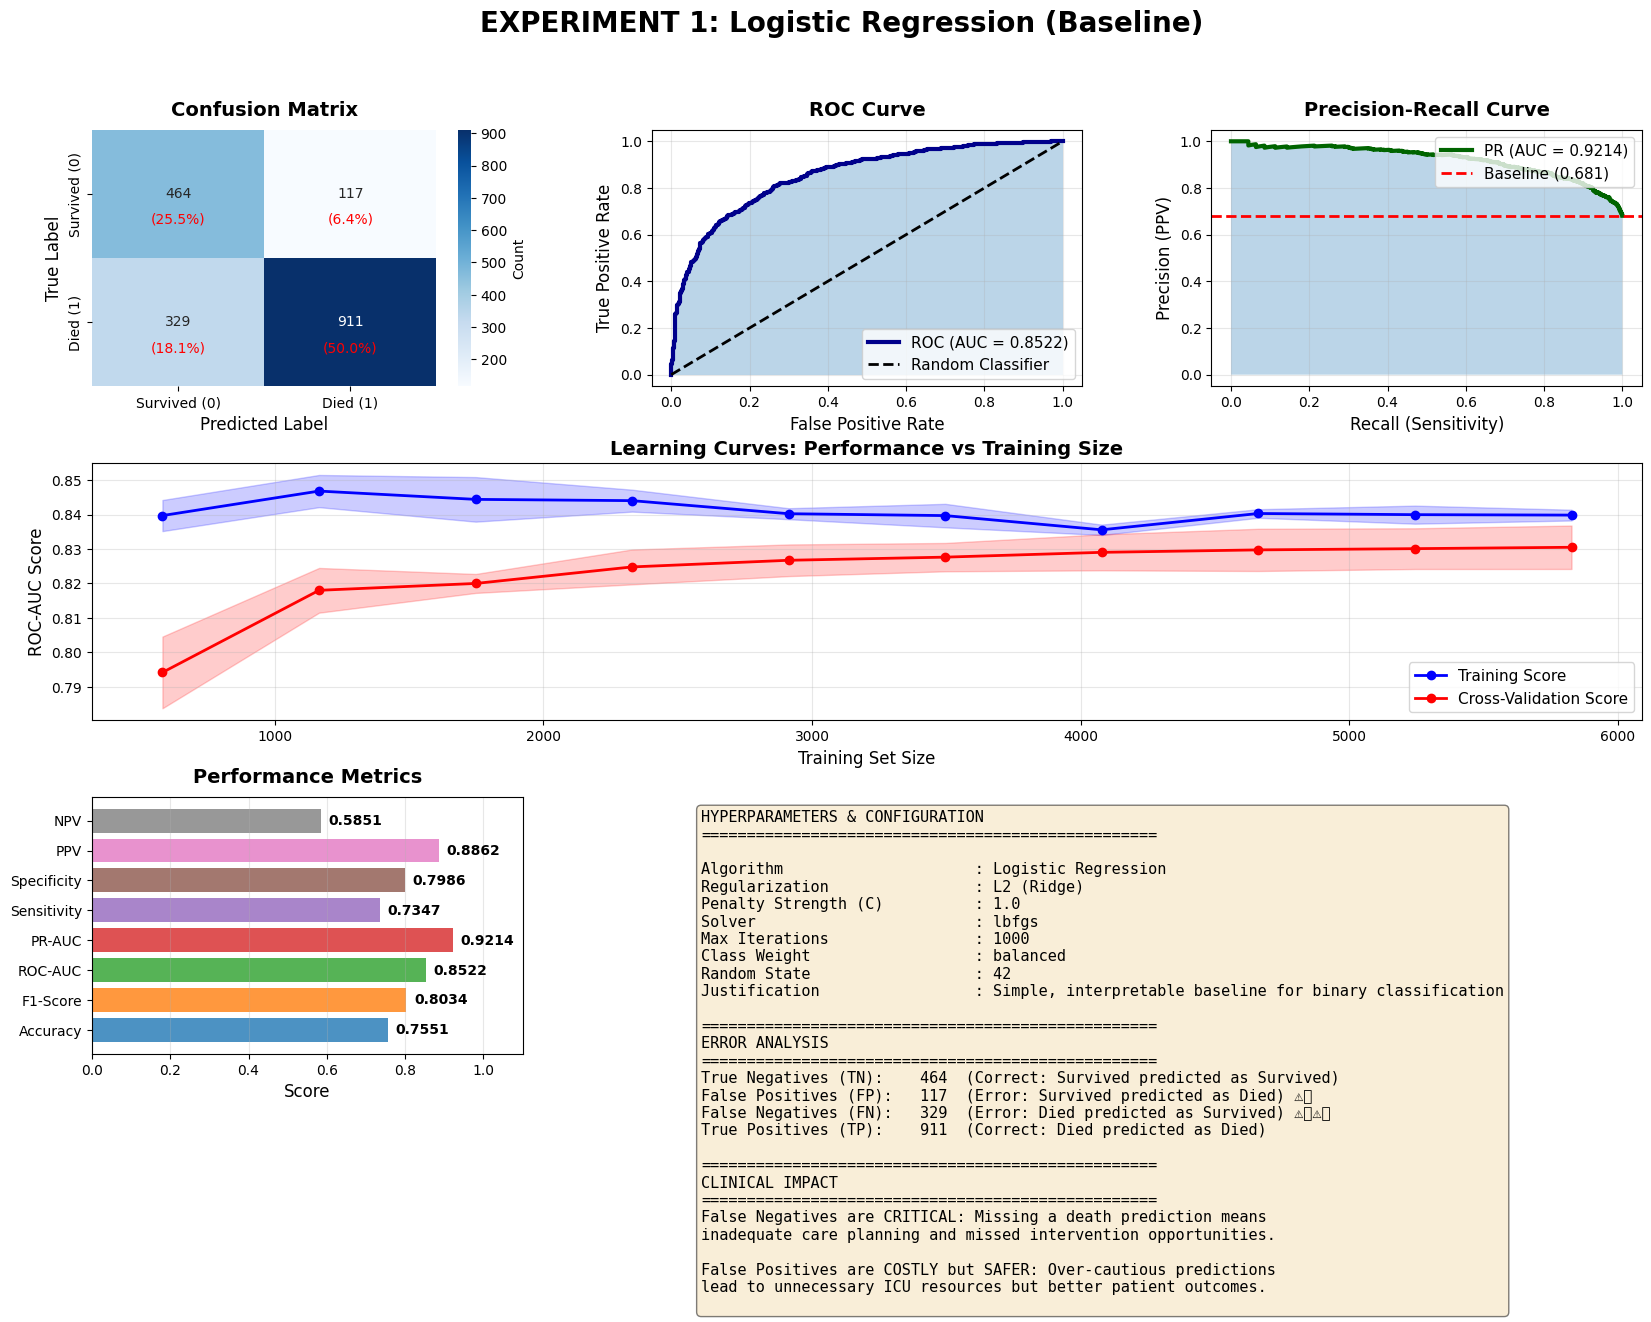

✓ Experiment 1 Complete: ROC-AUC = 0.8522


In [27]:
# ============================================================================
# EXPERIMENT 1: Logistic Regression - Baseline
# ============================================================================
print("\n" + "="*80)
print("EXPERIMENT 1: LOGISTIC REGRESSION (BASELINE)")
print("="*80)

hyperparams_exp1 = {
    'Algorithm': 'Logistic Regression',
    'Regularization': 'L2 (Ridge)',
    'Penalty Strength (C)': 1.0,
    'Solver': 'lbfgs',
    'Max Iterations': 1000,
    'Class Weight': 'balanced',
    'Random State': 42,
    'Justification': 'Simple, interpretable baseline for binary classification'
}

lr_baseline = LogisticRegression(
    C=1.0,
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs',
    random_state=42
)

print("[Training...]")
lr_baseline.fit(X_train_scaled, y_train.values.ravel())

print("[Predicting...]")
y_pred_lr = lr_baseline.predict(X_test_scaled)
y_pred_proba_lr = lr_baseline.predict_proba(X_test_scaled)[:, 1]

print("[Visualizing...]")
exp1_results = plot_experiment_results(
    lr_baseline, X_train_scaled, y_train, X_test_scaled, y_test,
    y_pred_lr, y_pred_proba_lr, 
    "Logistic Regression (Baseline)",
    history=None,
    hyperparams=hyperparams_exp1,
    experiment_num=1
)
all_results.append(exp1_results)

print(f"✓ Experiment 1 Complete: ROC-AUC = {exp1_results['ROC-AUC']:.4f}")

#### LOGISTIC REGRESSION WITH L1-FEATURE SELECTION


EXPERIMENT 2: LOGISTIC REGRESSION WITH L1 (LASSO) - FEATURE SELECTION
[Training...]
Features selected by L1: 38/52
[Predicting...]
[Visualizing...]


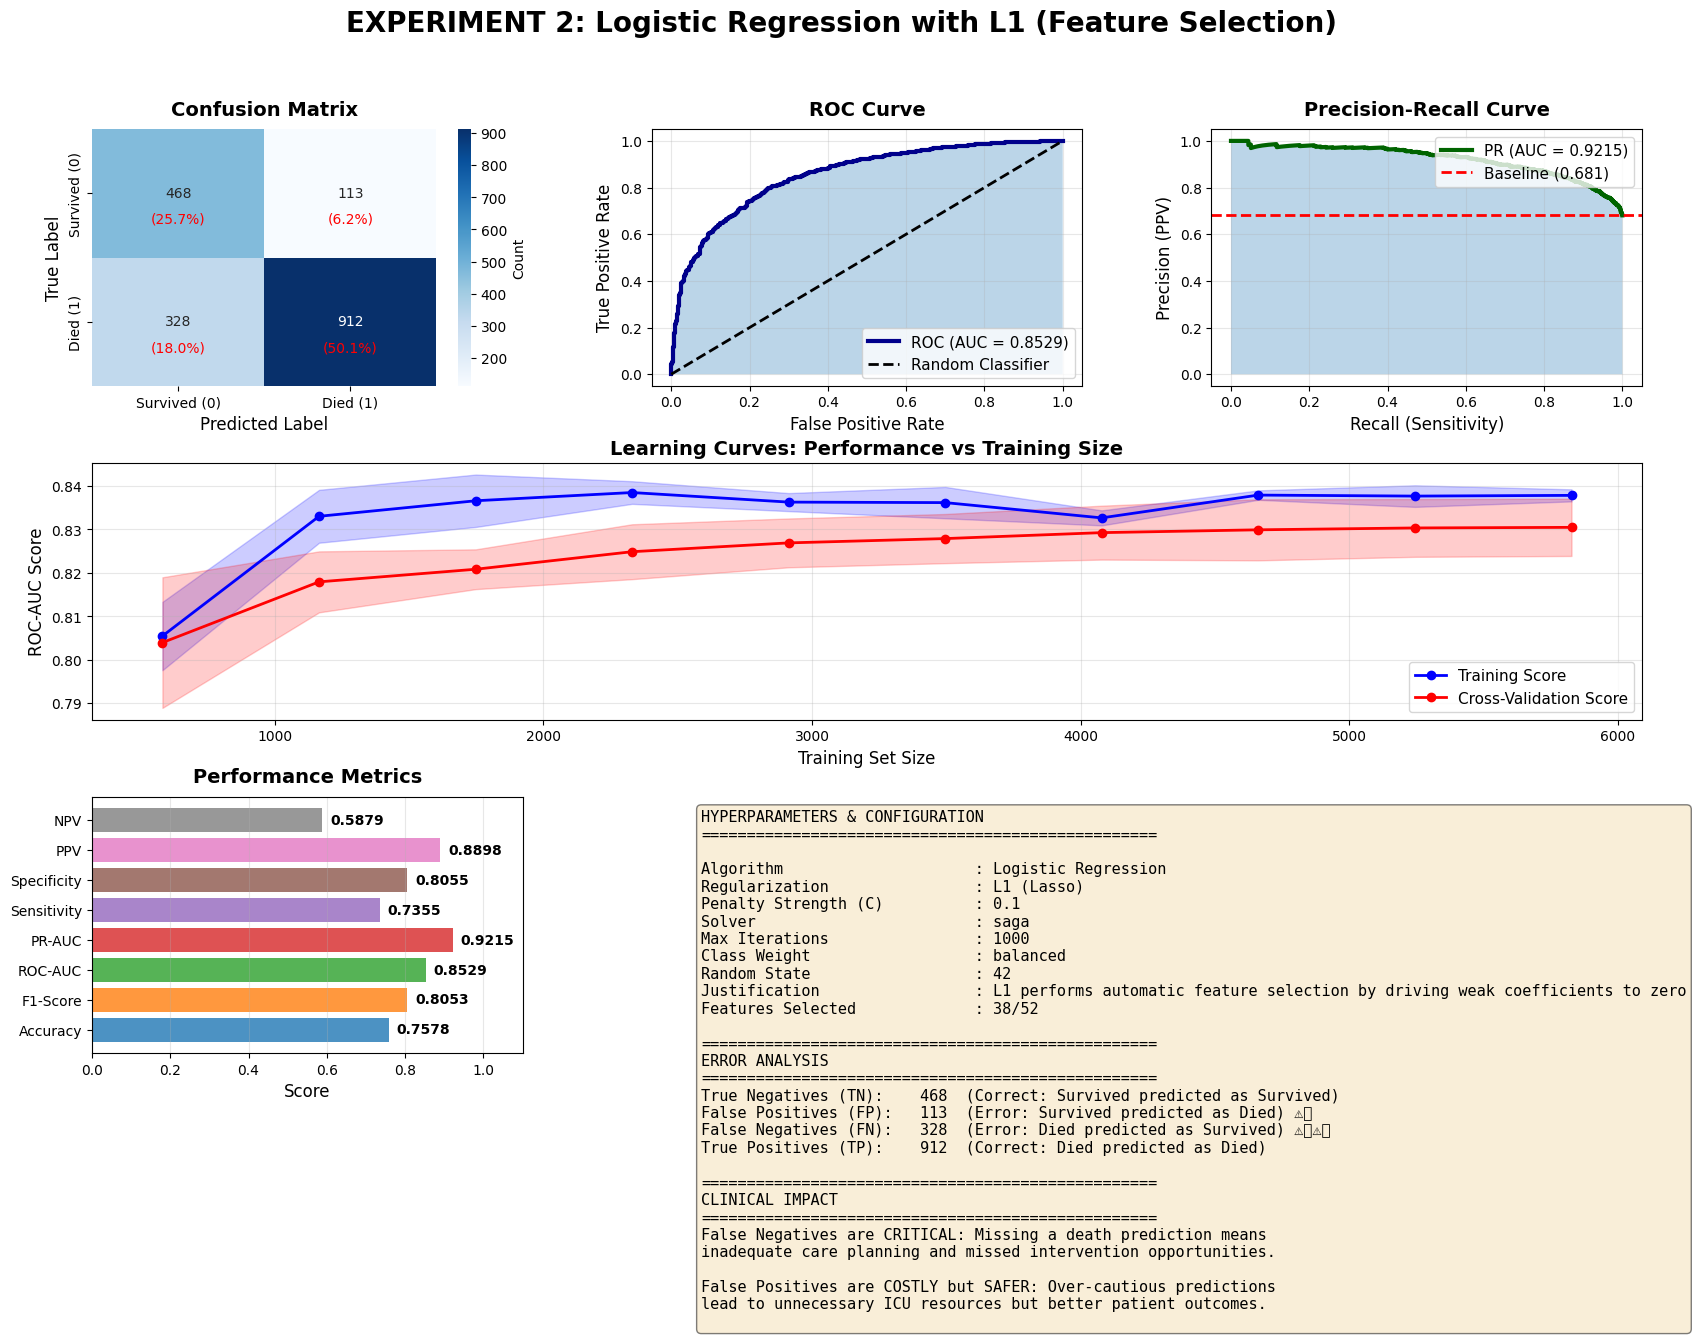

✓ Experiment 2 Complete: ROC-AUC = 0.8529


In [28]:
# ============================================================================
# EXPERIMENT 2: Logistic Regression with L1 Regularization
# ============================================================================
print("\n" + "="*80)
print("EXPERIMENT 2: LOGISTIC REGRESSION WITH L1 (LASSO) - FEATURE SELECTION")
print("="*80)

hyperparams_exp2 = {
    'Algorithm': 'Logistic Regression',
    'Regularization': 'L1 (Lasso)',
    'Penalty Strength (C)': 0.1,
    'Solver': 'saga',
    'Max Iterations': 1000,
    'Class Weight': 'balanced',
    'Random State': 42,
    'Justification': 'L1 performs automatic feature selection by driving weak coefficients to zero'
}

lr_l1 = LogisticRegression(
    penalty='l1',
    C=0.1,
    solver='saga',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

print("[Training...]")
lr_l1.fit(X_train_scaled, y_train.values.ravel())

# Check feature selection
non_zero_coef = np.sum(lr_l1.coef_ != 0)
print(f"Features selected by L1: {non_zero_coef}/{X_train_scaled.shape[1]}")

print("[Predicting...]")
y_pred_lr_l1 = lr_l1.predict(X_test_scaled)
y_pred_proba_lr_l1 = lr_l1.predict_proba(X_test_scaled)[:, 1]

print("[Visualizing...]")
hyperparams_exp2['Features Selected'] = f"{non_zero_coef}/{X_train_scaled.shape[1]}"
exp2_results = plot_experiment_results(
    lr_l1, X_train_scaled, y_train, X_test_scaled, y_test,
    y_pred_lr_l1, y_pred_proba_lr_l1,
    "Logistic Regression with L1 (Feature Selection)",
    history=None,
    hyperparams=hyperparams_exp2,
    experiment_num=2
)
all_results.append(exp2_results)

print(f"✓ Experiment 2 Complete: ROC-AUC = {exp2_results['ROC-AUC']:.4f}")


#####  RANDOM FOREST - ENSEMBLE METHOD


EXPERIMENT 3: RANDOM FOREST - ENSEMBLE METHOD
[Training...]
[Predicting...]
[Visualizing...]
[Predicting...]
[Visualizing...]


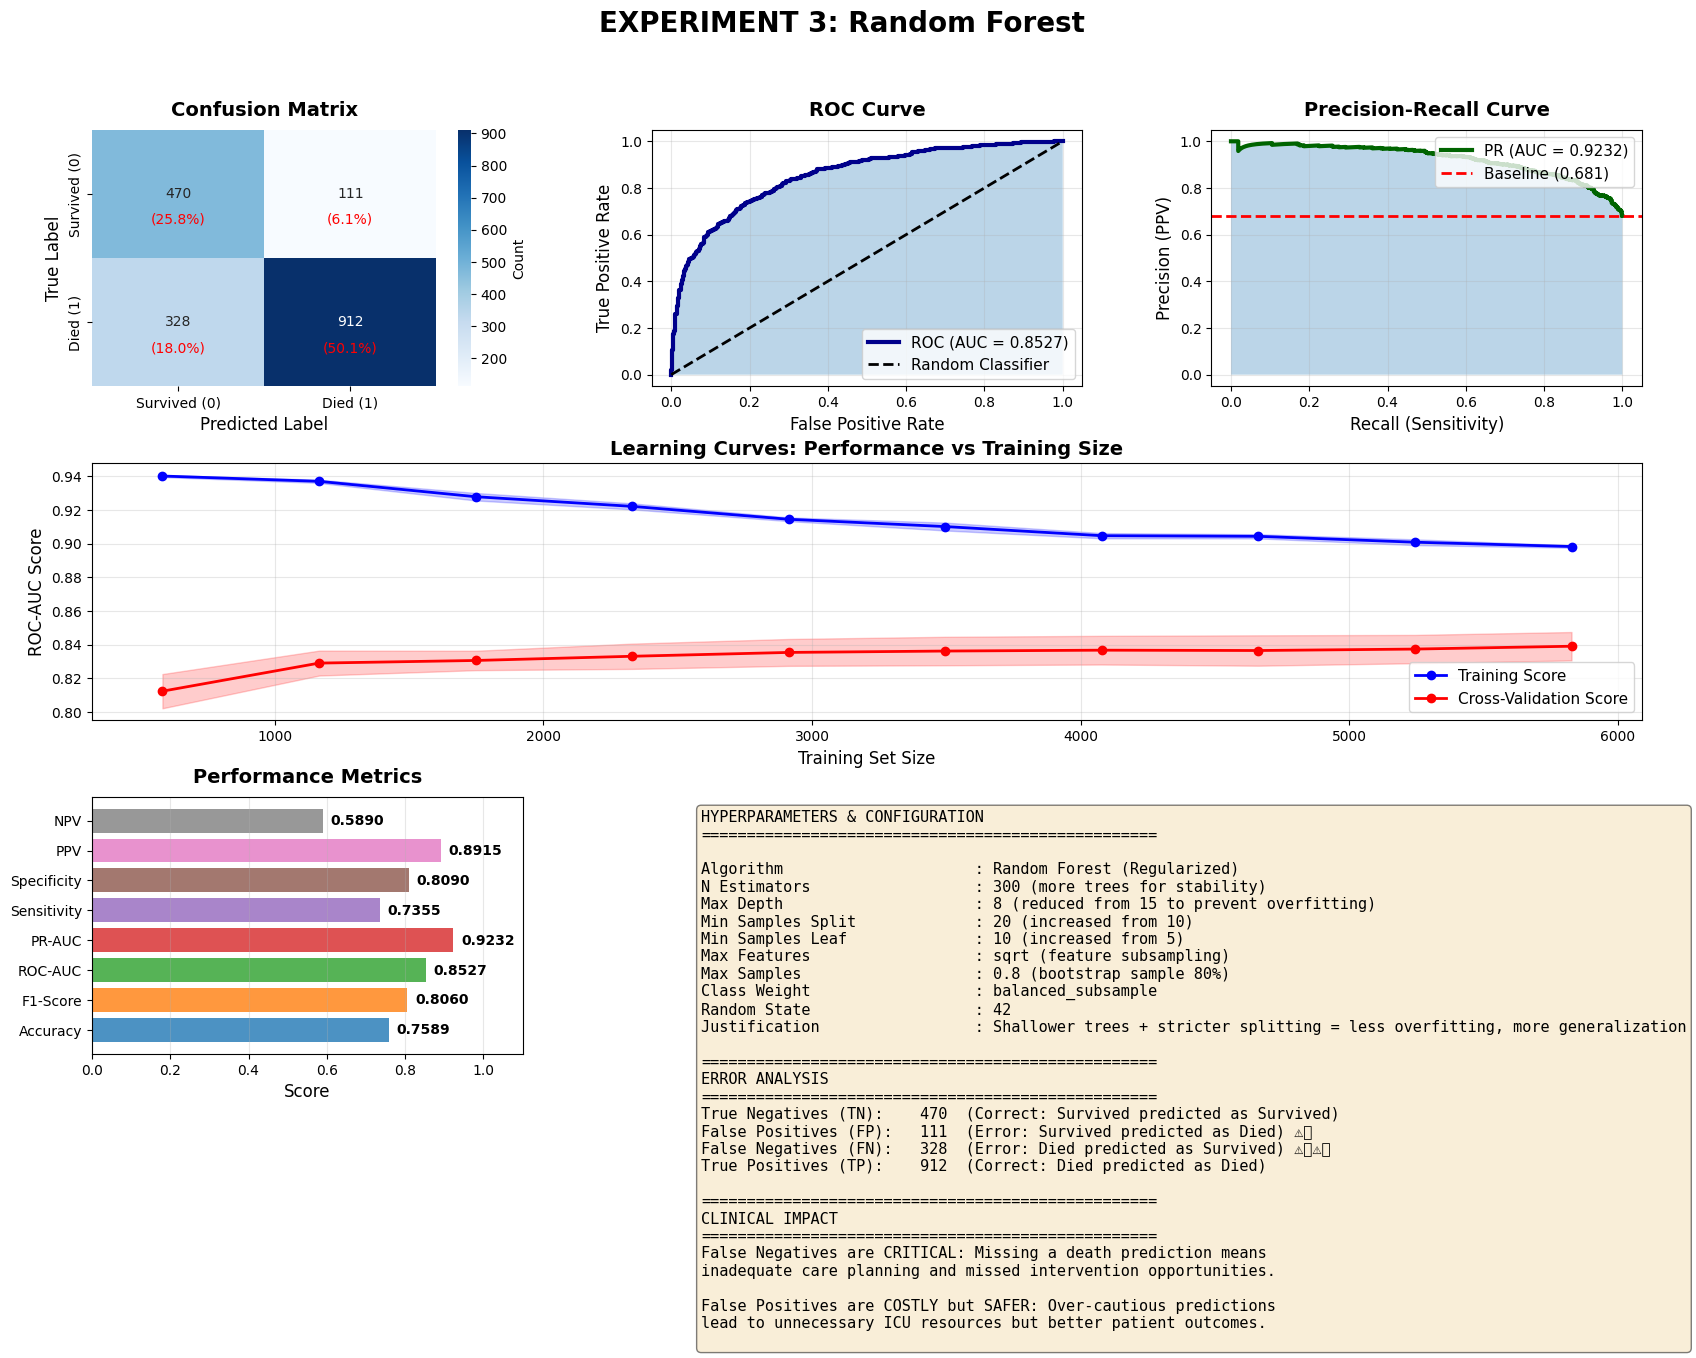

✓ Experiment 3 Complete: ROC-AUC = 0.8527


In [43]:
# ============================================================================
# EXPERIMENT 3: Random Forest Classifier
# ============================================================================
print("\n" + "="*80)
print("EXPERIMENT 3: RANDOM FOREST - ENSEMBLE METHOD")
print("="*80)

hyperparams_exp3 = {
 'Algorithm': 'Random Forest (Regularized)',
    'N Estimators': '300 (more trees for stability)',
    'Max Depth': '8 (reduced from 15 to prevent overfitting)',
    'Min Samples Split': '20 (increased from 10)',
    'Min Samples Leaf': '10 (increased from 5)',
    'Max Features': 'sqrt (feature subsampling)',
    'Max Samples': '0.8 (bootstrap sample 80%)',
    'Class Weight': 'balanced_subsample',
    'Random State': '42',
    'Justification': 'Shallower trees + stricter splitting = less overfitting, more generalization'
}

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_features='sqrt',
    max_samples=0.8,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

print("[Training...]")
rf_model.fit(X_train_scaled, y_train.values.ravel())

print("[Predicting...]")
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("[Visualizing...]")
exp3_results = plot_experiment_results(
    rf_model, X_train_scaled, y_train, X_test_scaled, y_test,
    y_pred_rf, y_pred_proba_rf,
    "Random Forest",
    history=None,
    hyperparams=hyperparams_exp3,
    experiment_num=3
)
all_results.append(exp3_results)

print(f"✓ Experiment 3 Complete: ROC-AUC = {exp3_results['ROC-AUC']:.4f}")

##### Gradient Boosting Classifier


EXPERIMENT 4: GRADIENT BOOSTING - SEQUENTIAL ENSEMBLE
[Training...]
[Predicting...]
[Visualizing...]


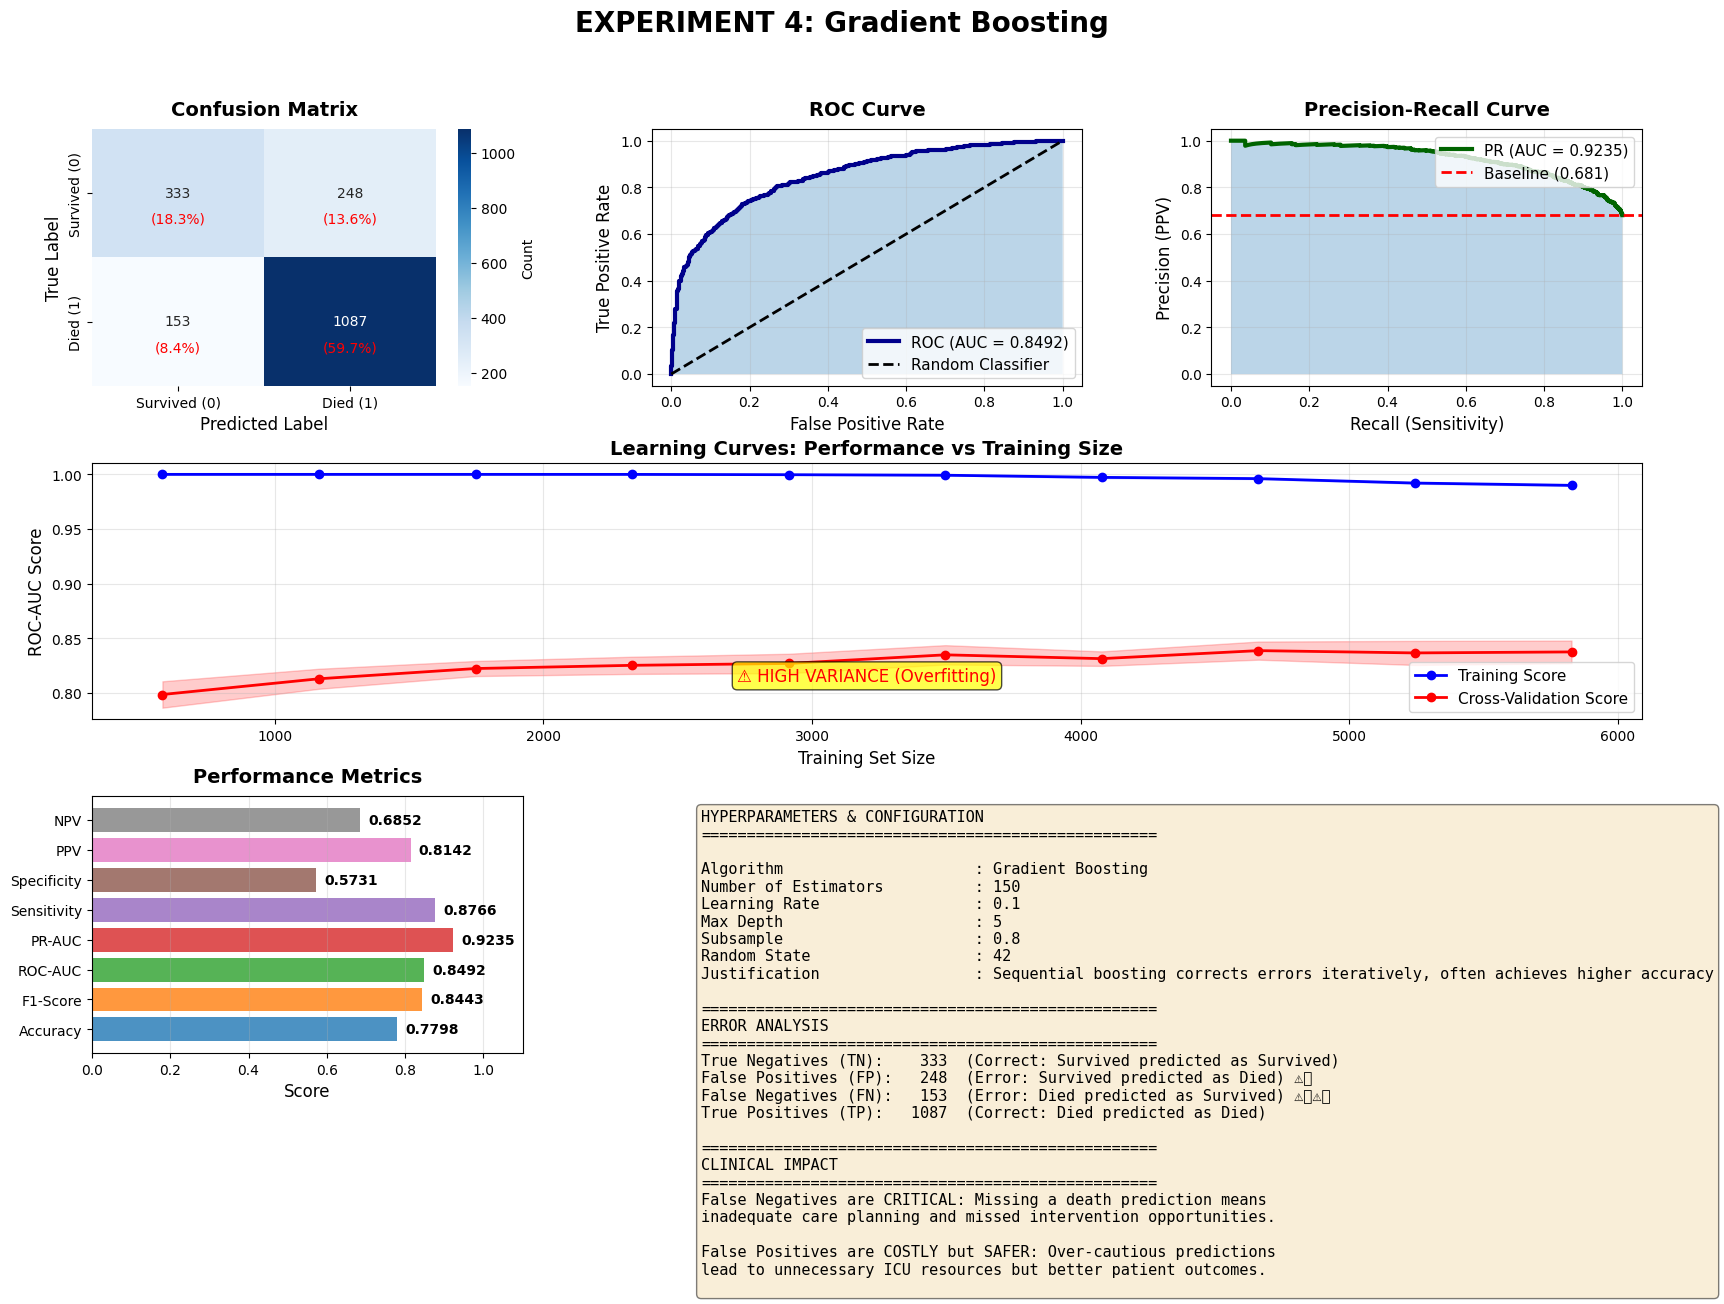

✓ Experiment 4 Complete: ROC-AUC = 0.8492


In [30]:
print("\n" + "="*80)
print("EXPERIMENT 4: GRADIENT BOOSTING - SEQUENTIAL ENSEMBLE")
print("="*80)

hyperparams_exp4 = {
    'Algorithm': 'Gradient Boosting',
    'Number of Estimators': 150,
    'Learning Rate': 0.1,
    'Max Depth': 5,
    'Subsample': 0.8,
    'Random State': 42,
    'Justification': 'Sequential boosting corrects errors iteratively, often achieves higher accuracy'
}

gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

print("[Training...]")
gb_model.fit(X_train_scaled, y_train.values.ravel())

print("[Predicting...]")
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

print("[Visualizing...]")
exp4_results = plot_experiment_results(
    gb_model, X_train_scaled, y_train, X_test_scaled, y_test,
    y_pred_gb, y_pred_proba_gb,
    "Gradient Boosting",
    history=None,
    hyperparams=hyperparams_exp4,
    experiment_num=4
)
all_results.append(exp4_results)

print(f"✓ Experiment 4 Complete: ROC-AUC = {exp4_results['ROC-AUC']:.4f}")

#### PREPARE DATA FOR DEEP LEARNING EXPERIMENTS

In [ ]:
print("\n" + "="*80)
print("PREPARING DATA FOR DEEP LEARNING EXPERIMENTS")
print("="*80)

X_train_nn = X_train_scaled.values
X_test_nn = X_test_scaled.values
y_train_nn = y_train.values.ravel()
y_test_nn = y_test.values.ravel()

input_dim = X_train_nn.shape[1]

# Callbacks (monitor val_auc for imbalanced problems)
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=12, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=6, min_lr=1e-7, verbose=1)

print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_nn.shape[0]}")
print("Callbacks configured: EarlyStopping(monitor=val_auc), ReduceLROnPlateau(monitor=val_auc)")


PREPARING DATA FOR DEEP LEARNING EXPERIMENTS
Input dimension: 52
Training samples: 7284
Callbacks configured: EarlyStopping, ReduceLROnPlateau


#### Simple Sequential Neural Network 


EXPERIMENT 6: SEQUENTIAL NEURAL NETWORK (BASELINE DL)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

None
[Training...]
[Predicting...]
[Visualizing...]


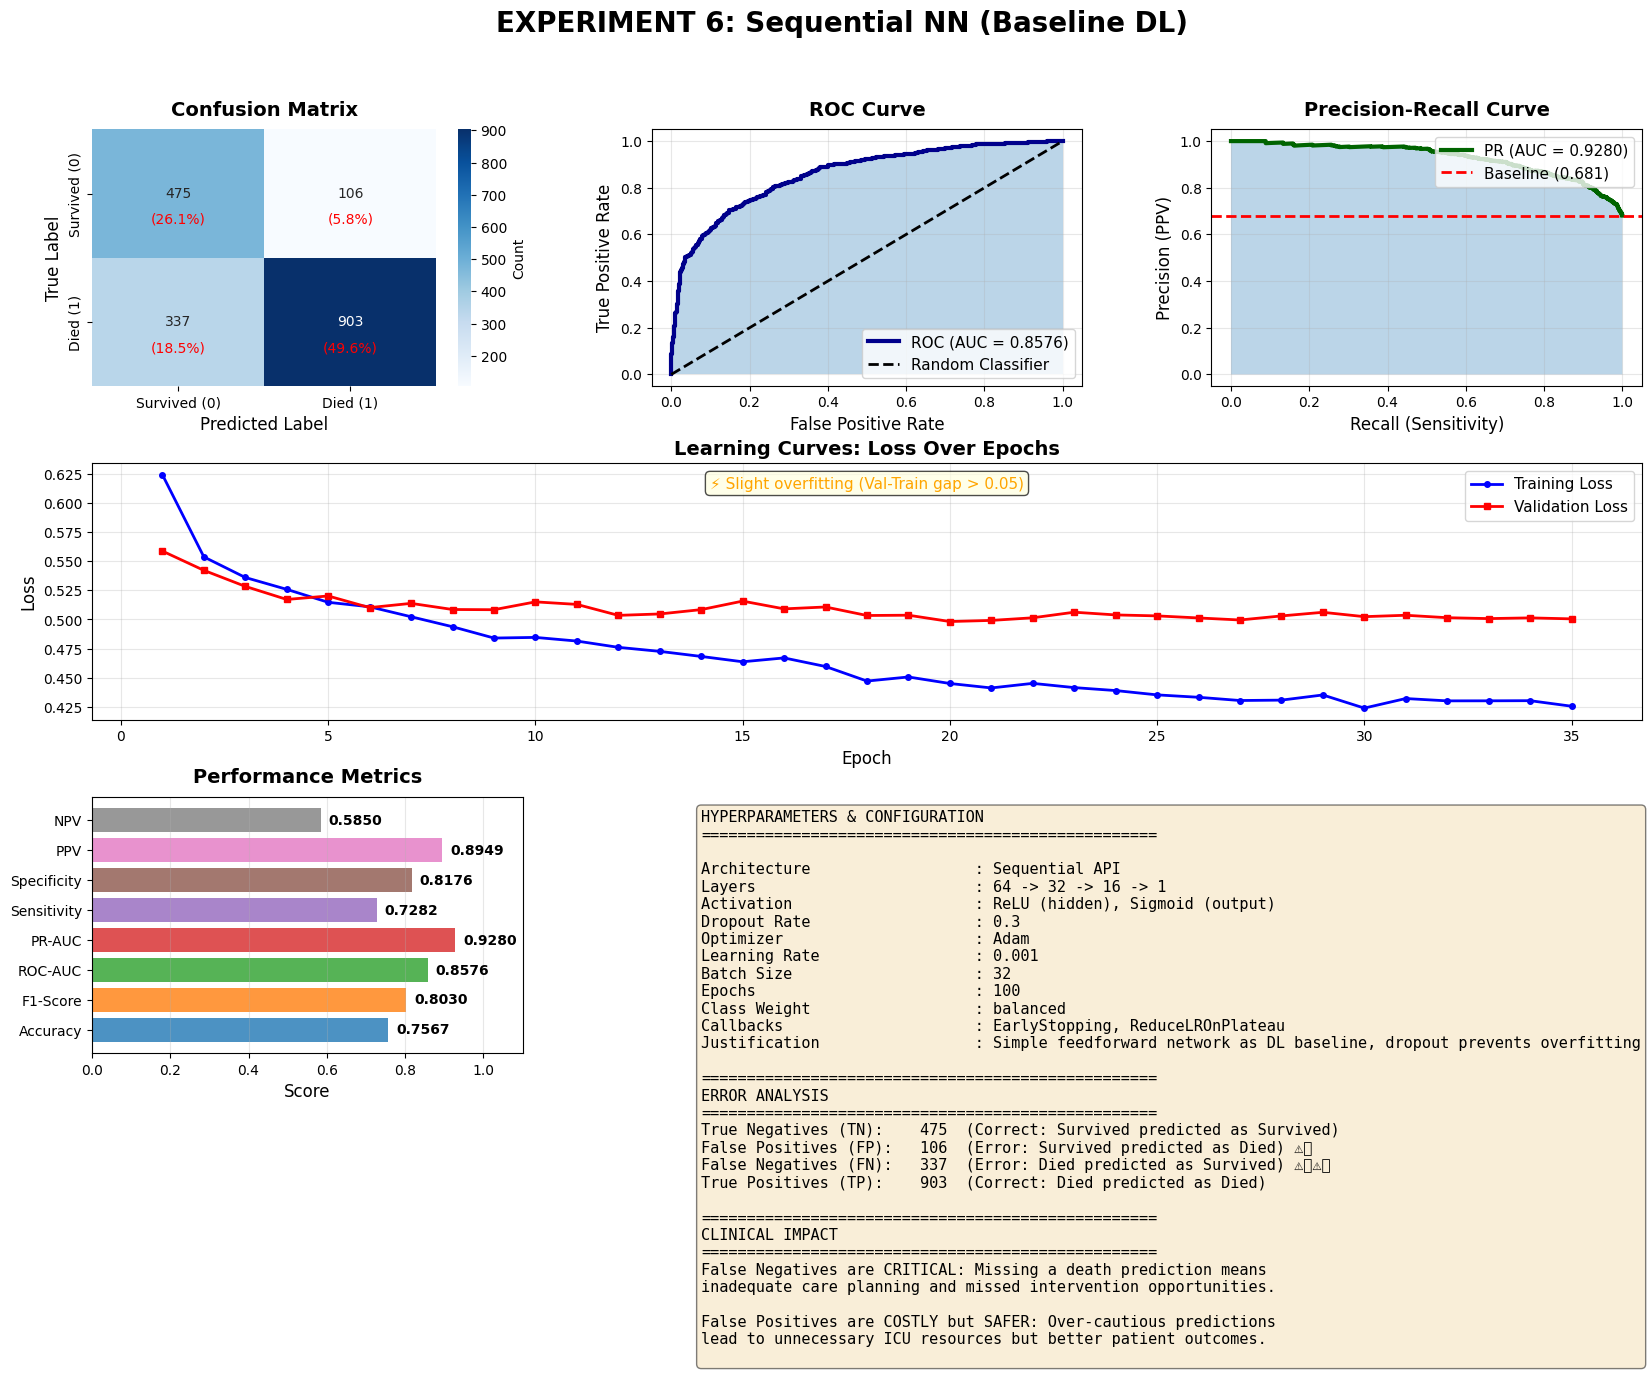

✓ Experiment 6 Complete: ROC-AUC = 0.8576


In [33]:
# ============================================================================
# EXPERIMENT 6: Simple Sequential Neural Network (Baseline DL)
# ============================================================================
print("\n" + "="*80)
print("EXPERIMENT 6: SEQUENTIAL NEURAL NETWORK (BASELINE DL)")
print("="*80)

hyperparams_exp6 = {
    'Architecture': 'Sequential API',
    'Layers': '64 -> 32 -> 16 -> 1',
    'Activation': 'ReLU (hidden), Sigmoid (output)',
    'Dropout Rate': 0.3,
    'Optimizer': 'Adam',
    'Learning Rate': 0.001,
    'Batch Size': 32,
    'Epochs': 100,
    'Class Weight': 'balanced',
    'Callbacks': 'EarlyStopping, ReduceLROnPlateau',
    'Justification': 'Simple feedforward network as DL baseline, dropout prevents overfitting'
}

model_seq_baseline = Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_seq_baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print(model_seq_baseline.summary())

print("[Training...]")
history_exp6 = model_seq_baseline.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

print("[Predicting...]")
y_pred_seq_baseline = (model_seq_baseline.predict(X_test_nn, verbose=0) > 0.5).astype(int).ravel()
y_pred_proba_seq_baseline = model_seq_baseline.predict(X_test_nn, verbose=0).ravel()

print("[Visualizing...]")
exp6_results = plot_experiment_results(
    model_seq_baseline, X_train_nn, y_train_nn, X_test_nn, y_test_nn,
    y_pred_seq_baseline, y_pred_proba_seq_baseline,
    "Sequential NN (Baseline DL)",
    history=history_exp6,
    hyperparams=hyperparams_exp6,
    experiment_num=6
)
all_results.append(exp6_results)

print(f"✓ Experiment 6 Complete: ROC-AUC = {exp6_results['ROC-AUC']:.4f}")

#### DEEPER SEQUENTIAL NN + BATCH NORMALIZATION


EXPERIMENT 7: DEEPER SEQUENTIAL NN + BATCH NORMALIZATION


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,465 (25.25 KB)

 Trainable params: 6,241 (24.38 KB)

 Non-trainable params: 224 (896.00 B)

None
[Training...]
Epoch 1/120
Epoch 1/120
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5353 - auc: 0.4975 - loss: 0.1371 - val_accuracy: 0.6239 - val_auc: 0.5970 - val_loss: 0.0724 - learning_rate: 5.0000e-04
Epoch 2/120
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5353 - auc: 0.4975 - loss: 0.1371 - val_accuracy: 0.6239 - val_auc: 0.5970 - val_loss: 0.0724 - learning_rate: 5.0000e-04
Epoch 2/120
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5384 - auc: 0.5428 - loss: 0.1103 - val_accuracy: 0.6390 - val_auc: 0.6847 - val_loss: 0.0662 - learning_rate: 5.0000e-04
Epoch 3/120
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5384 - auc: 0.5428 - loss: 0.1103 - val_accuracy: 0.6390 - val_auc: 0.6847 - val_loss: 0.0662 - learning_rate: 5.0000e-04
Epoch 3/120
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5310 - auc: 0.5612 - loss: 0.0975 - val_accuracy: 0.6301 - val_auc: 0.7165 - val_loss: 0.0632 - learning_rate: 5.0000e-04
Epoch 4/120
46/46 ━━━━━━━━━━━━━━

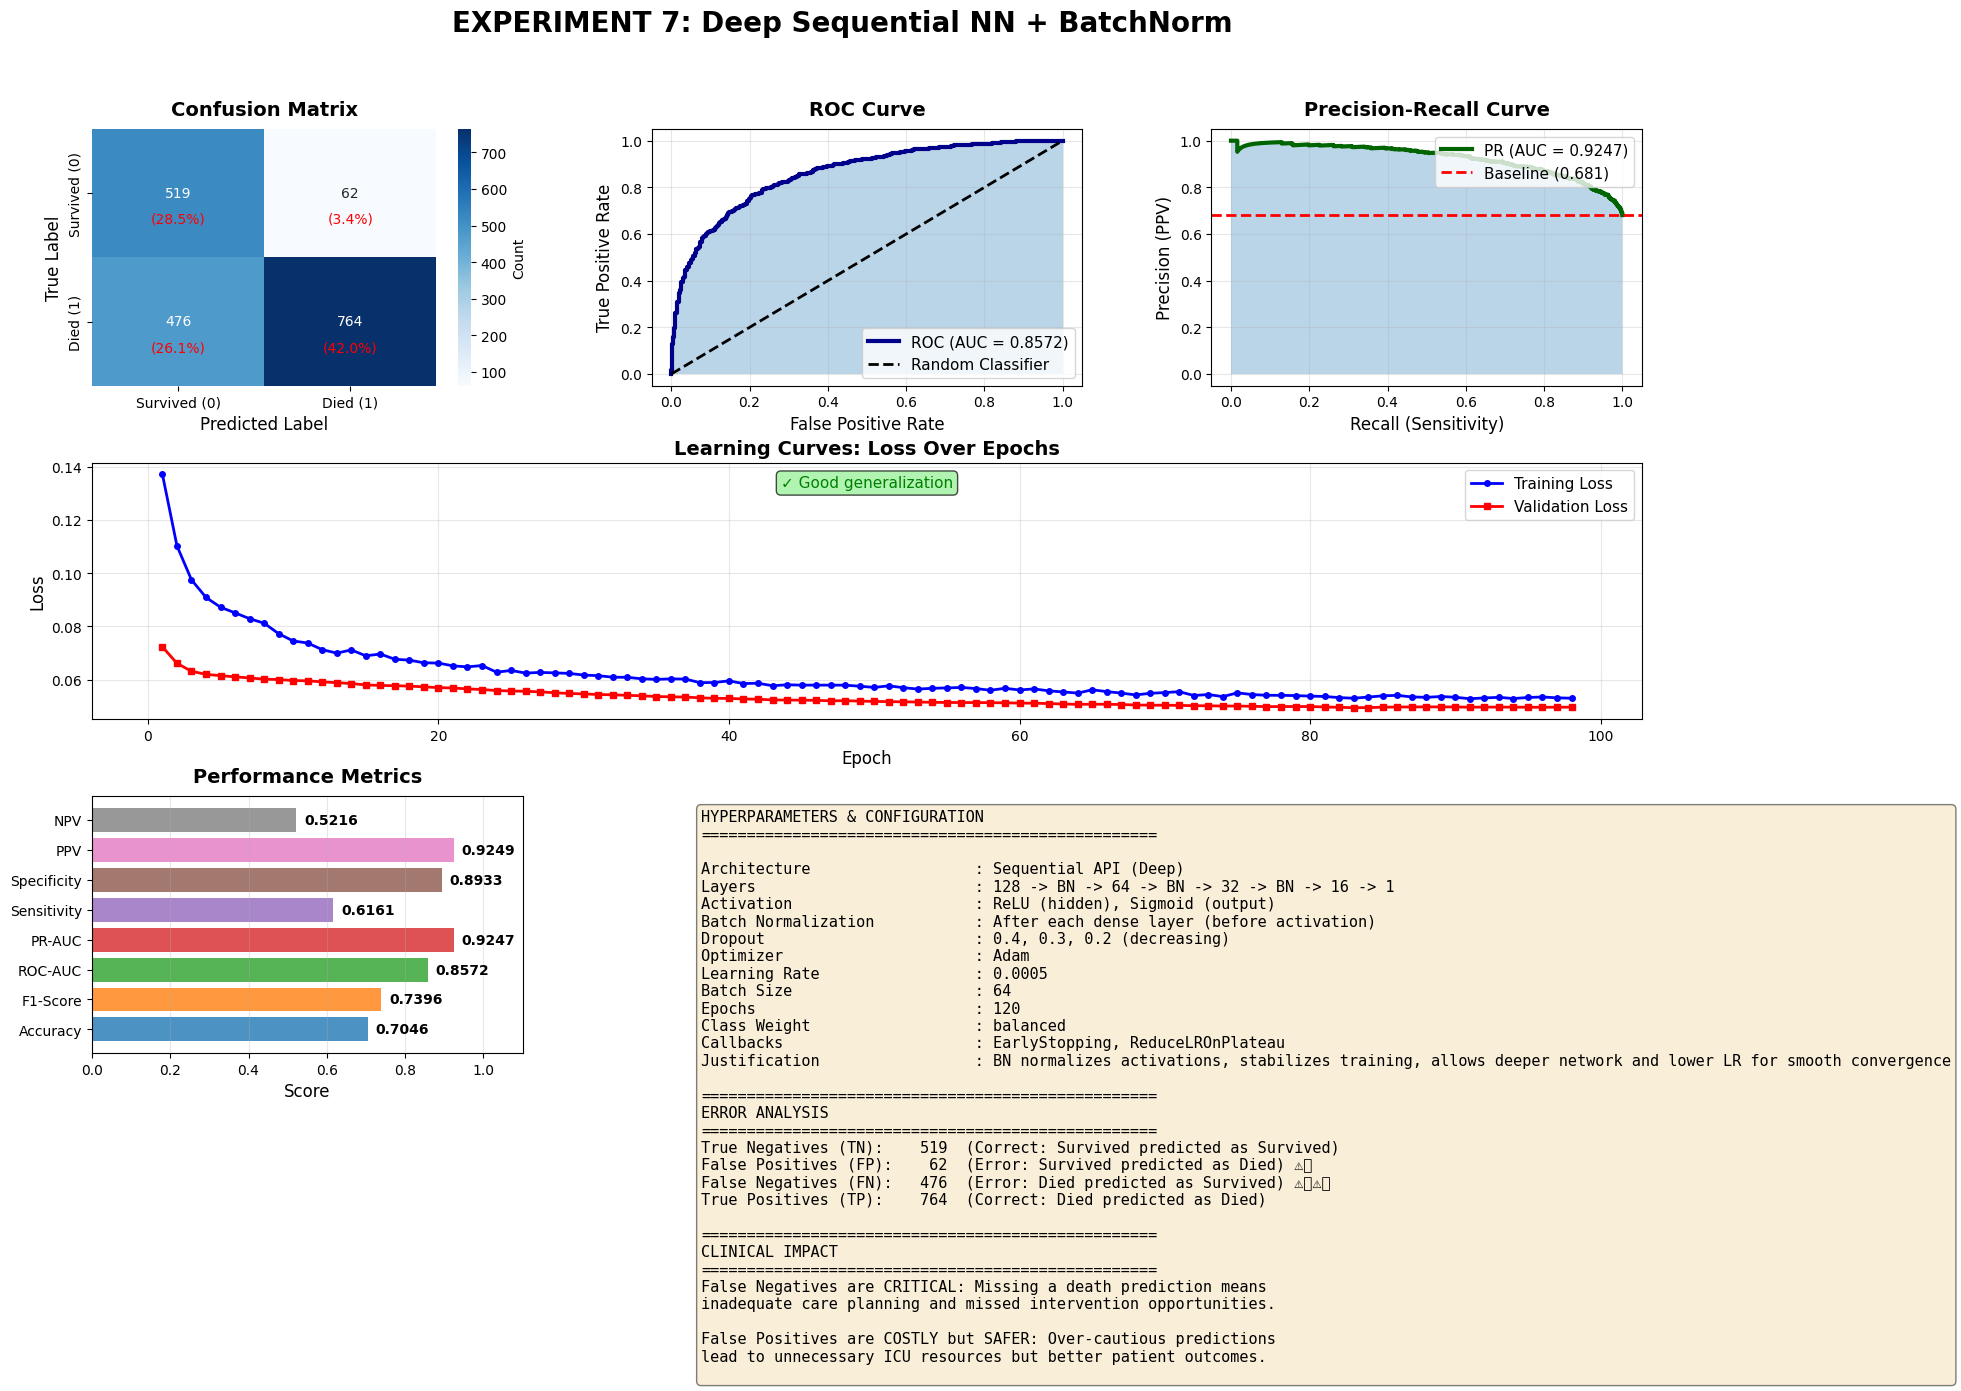

✓ Experiment 7 Complete: ROC-AUC = 0.8572


In [37]:
# ============================================================================
# EXPERIMENT 7: Deep Sequential with Batch Normalization
# ============================================================================
print("\n" + "="*80)
print("EXPERIMENT 7: DEEPER SEQUENTIAL NN + BATCH NORMALIZATION")
print("="*80)

hyperparams_exp7 = {
    'Architecture': 'Sequential API (Deep)',
    'Layers': '128 -> BN -> 64 -> BN -> 32 -> BN -> 16 -> 1',
    'Activation': 'ReLU (hidden), Sigmoid (output)',
    'Batch Normalization': 'After each dense layer (before activation)',
    'Dropout': '0.4, 0.3, 0.2 (decreasing)',
    'Optimizer': 'Adam',
    'Learning Rate': 0.0005,
    'Batch Size': 64,
    'Epochs': 120,
    'Class Weight': 'balanced',
    'Callbacks': 'EarlyStopping, ReduceLROnPlateau',
    'Justification': 'BN normalizes activations, stabilizes training, allows deeper network and lower LR for smooth convergence'
}

# Improved Experiment 7: smaller network, Gaussian noise, stronger dropout and focal loss to help class imbalance
import tensorflow.keras.backend as K
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
        loss = - alpha_t * K.pow((1 - p_t), gamma) * K.log(p_t)
        return K.mean(loss)
    return loss

model_seq_bn = Sequential([
    layers.GaussianNoise(0.1, input_shape=(input_dim,)),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(32),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(16),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')
])

model_seq_bn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print(model_seq_bn.summary())

print("[Training...]")
history_exp7 = model_seq_bn.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=120,
    batch_size=128,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("[Predicting...]")
y_pred_seq_bn = (model_seq_bn.predict(X_test_nn, verbose=0) > 0.5).astype(int).ravel()
y_pred_proba_seq_bn = model_seq_bn.predict(X_test_nn, verbose=0).ravel()

print("[Visualizing...]")
exp7_results = plot_experiment_results(
    model_seq_bn, X_train_nn, y_train_nn, X_test_nn, y_test_nn,
    y_pred_seq_bn, y_pred_proba_seq_bn,
    "Deep Sequential NN + BatchNorm",
    history=history_exp7,
    hyperparams=hyperparams_exp7,
    experiment_num=7
)
all_results.append(exp7_results)

print(f"✓ Experiment 7 Complete: ROC-AUC = {exp7_results['ROC-AUC']:.4f}")



████████████████████████████████████████████████████████████████████████████████████████████████████
█                                   ICU MORTALITY PREDICTION                                        █
█                              COMPREHENSIVE EXPERIMENT SUITE                                      █
████████████████████████████████████████████████████████████████████████████████████████████████████

📊 Dataset: 7284 train, 1821 test
📈 Features: 52
⚖️  Class Balance: {1: np.int64(4961), 0: np.int64(2323)}
🎯 Objective: Predict in-hospital mortality from first 24h data


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 1: LOGISTIC REGRESSION (L2 REGULARIZATION) - BASELINE
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


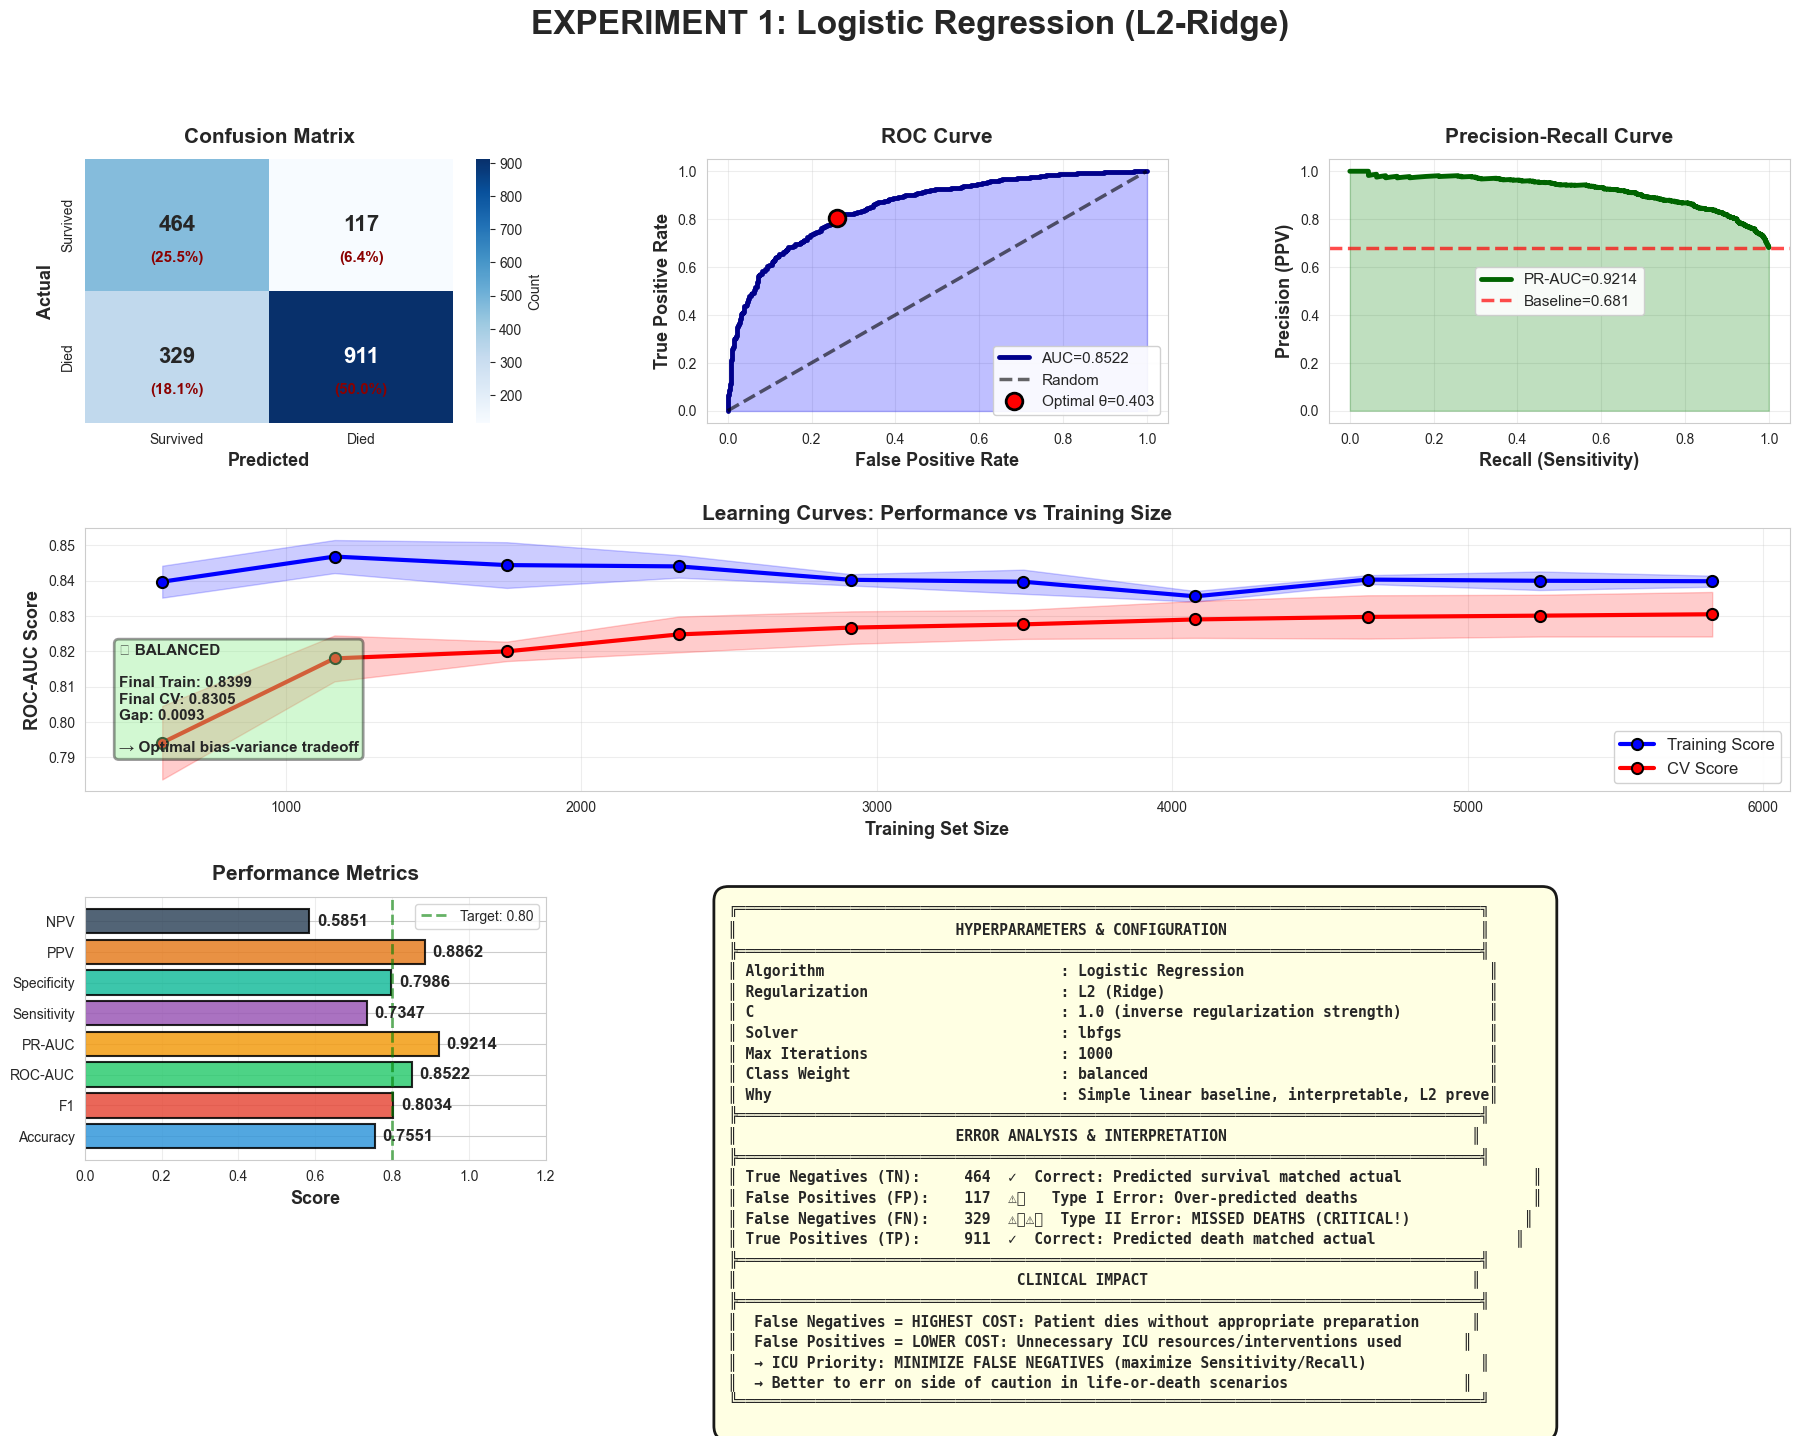


EXPERIMENT 1 RESULTS: Logistic Regression (L2-Ridge)
ROC-AUC: 0.8522 | F1-Score: 0.8034 | Sensitivity: 0.7347
False Negatives (Missed Deaths): 329 | False Positives: 117


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 2: LOGISTIC REGRESSION (L1 REGULARIZATION) - AUTOMATIC FEATURE SELECTION
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


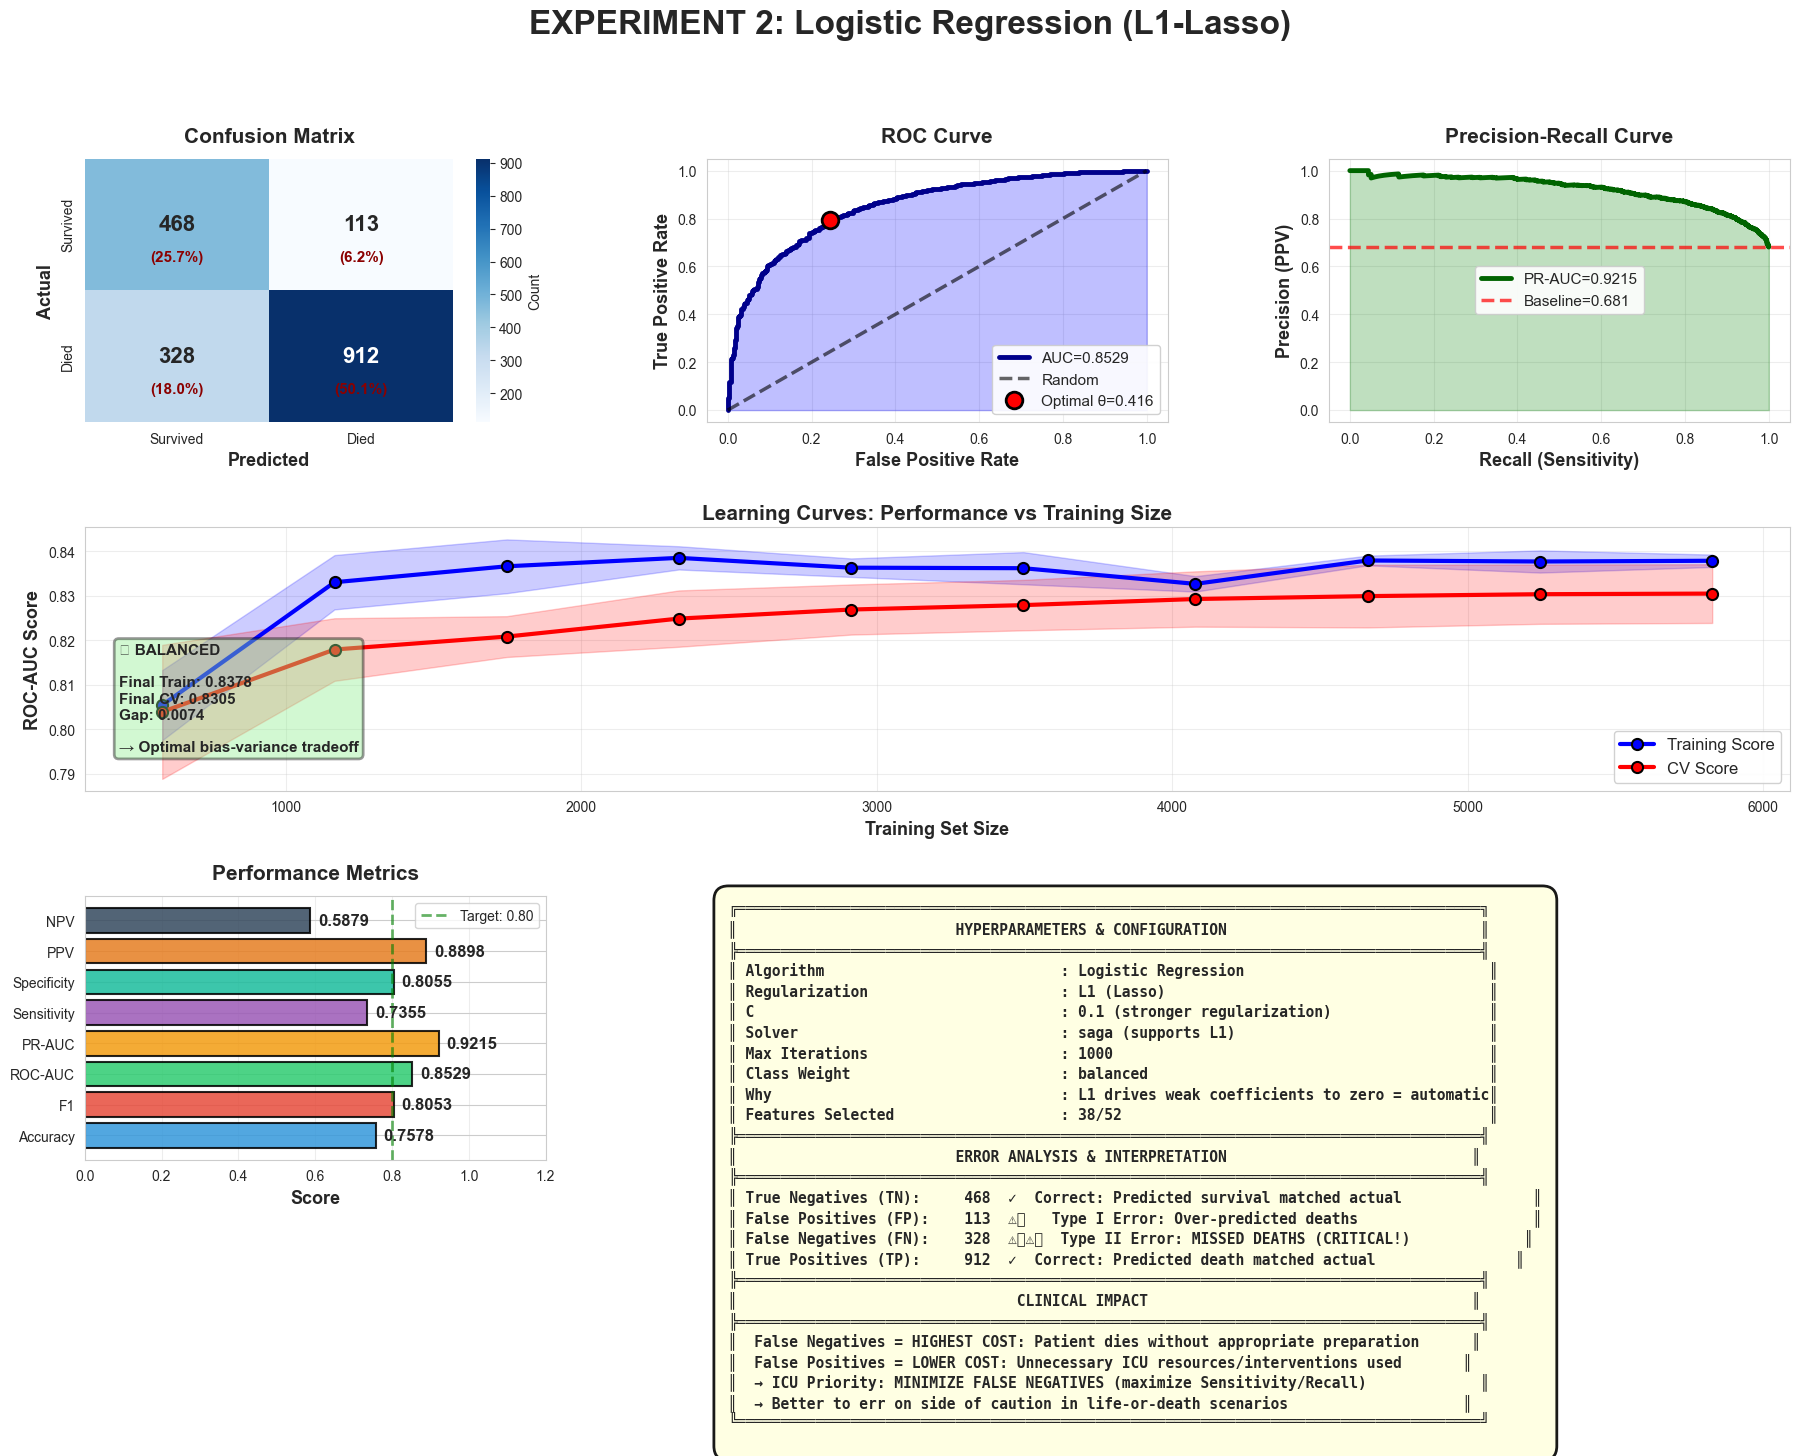


EXPERIMENT 2 RESULTS: Logistic Regression (L1-Lasso)
ROC-AUC: 0.8529 | F1-Score: 0.8053 | Sensitivity: 0.7355
False Negatives (Missed Deaths): 328 | False Positives: 113


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 3: RANDOM FOREST - BAGGING ENSEMBLE
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


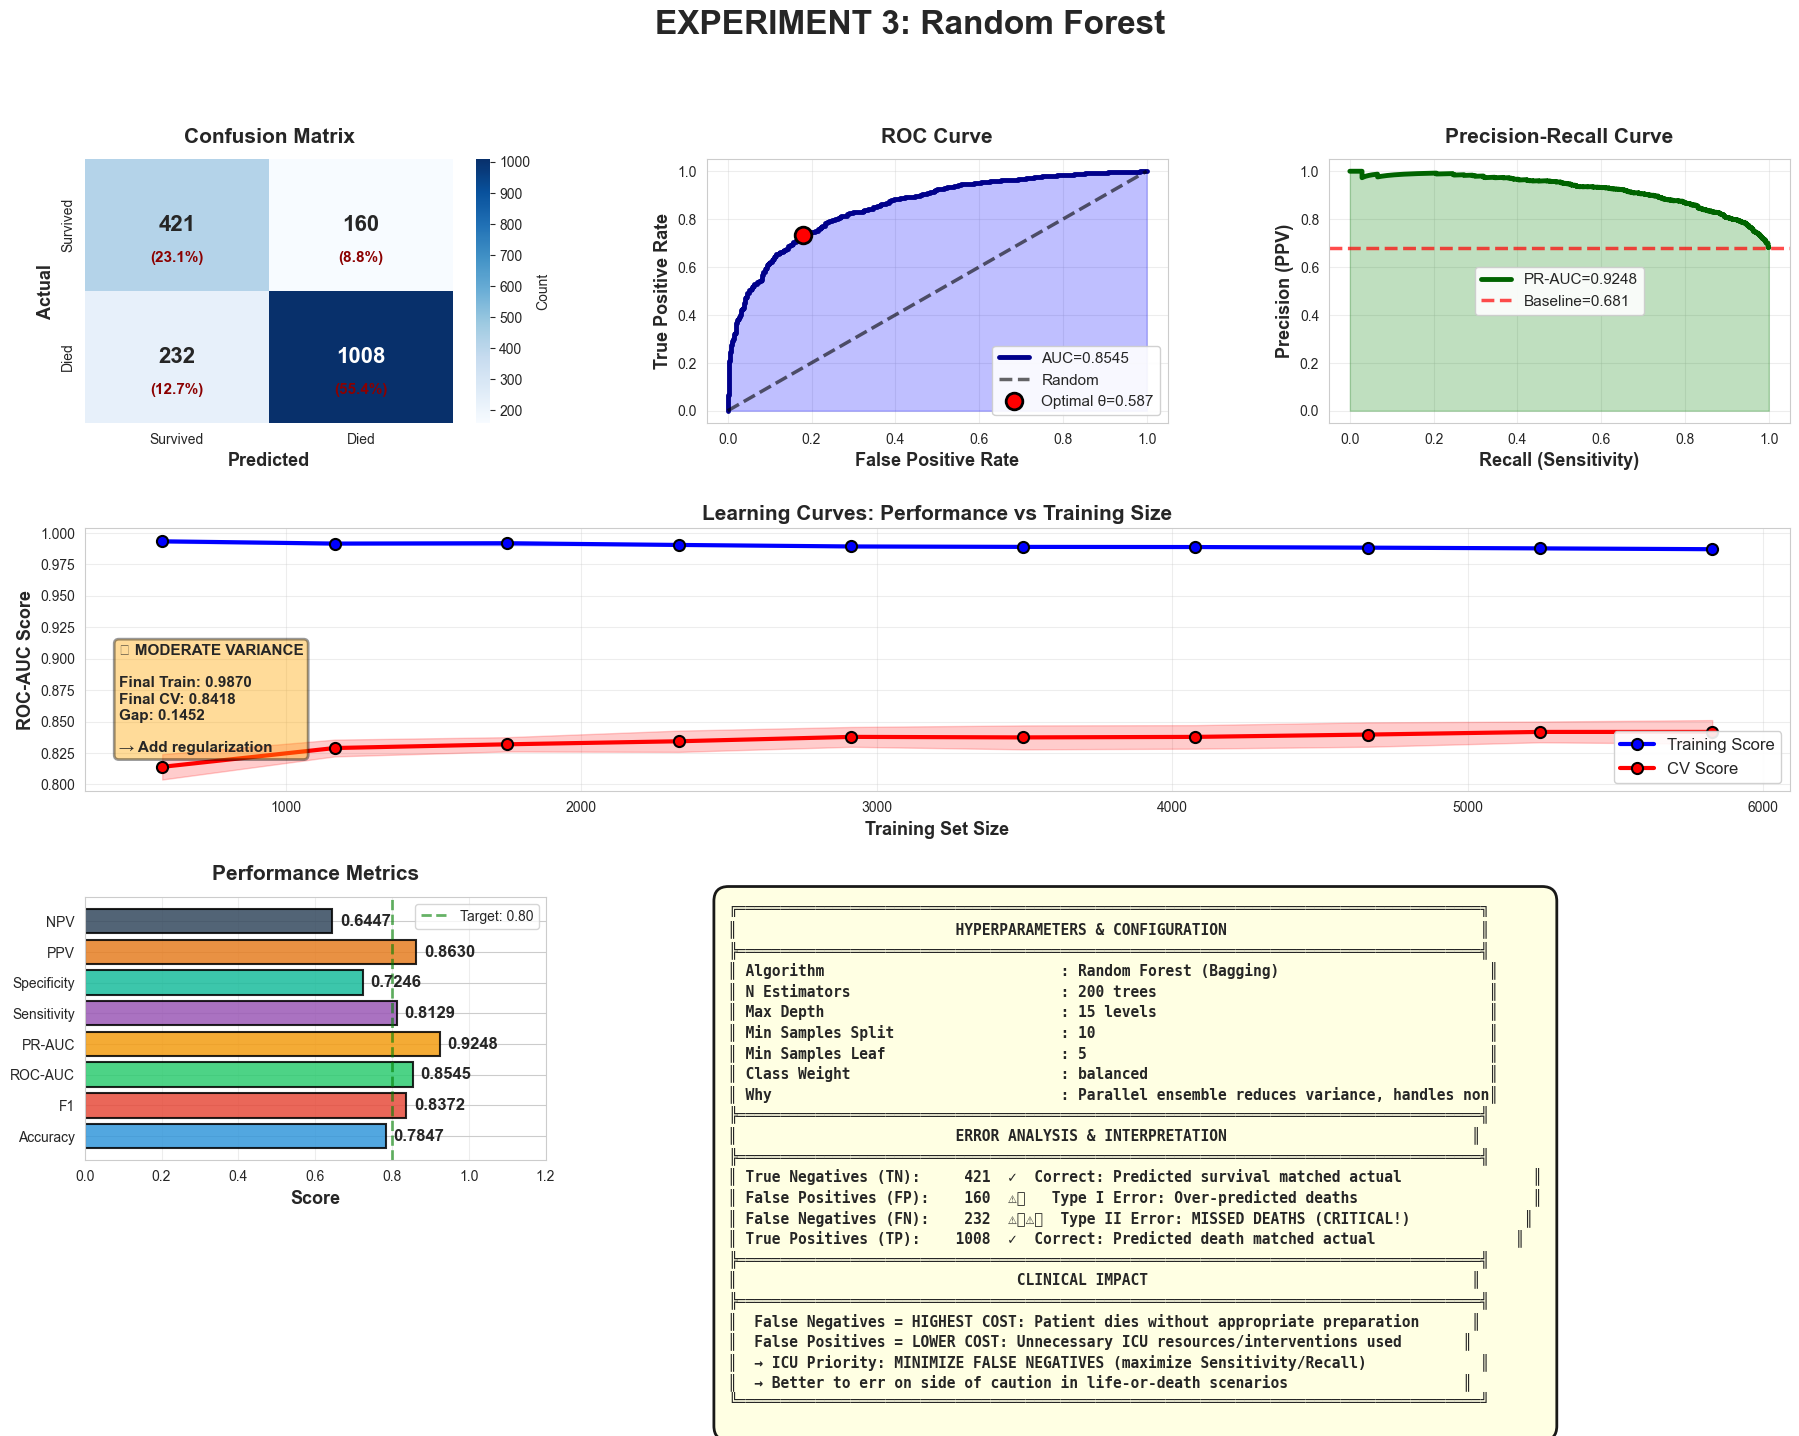


EXPERIMENT 3 RESULTS: Random Forest
ROC-AUC: 0.8545 | F1-Score: 0.8372 | Sensitivity: 0.8129
False Negatives (Missed Deaths): 232 | False Positives: 160


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 4: GRADIENT BOOSTING - SEQUENTIAL ENSEMBLE
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


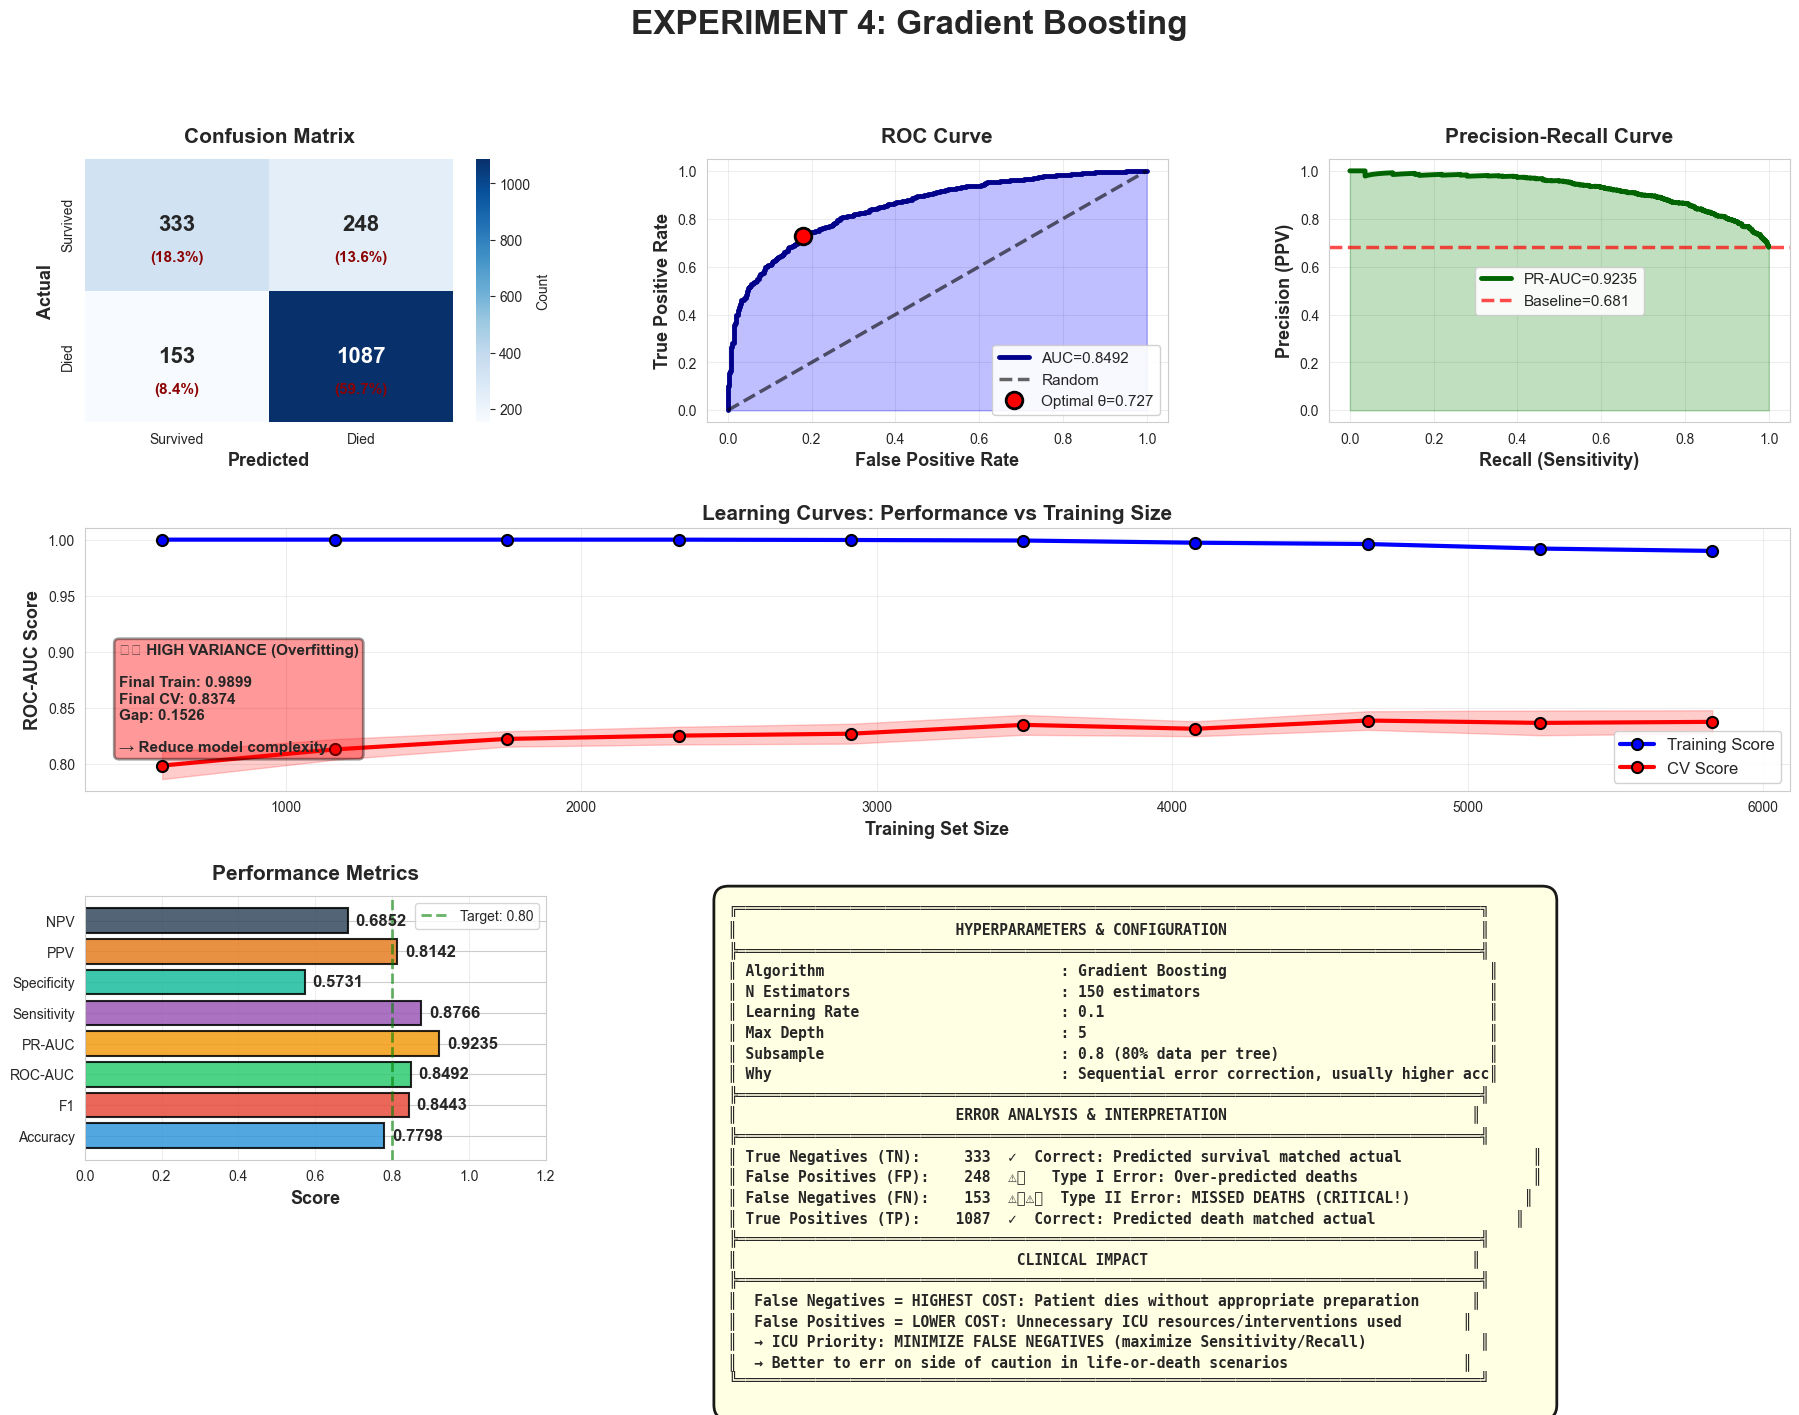


EXPERIMENT 4 RESULTS: Gradient Boosting
ROC-AUC: 0.8492 | F1-Score: 0.8443 | Sensitivity: 0.8766
False Negatives (Missed Deaths): 153 | False Positives: 248


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 5: RANDOM FOREST + SMOTE - SYNTHETIC OVERSAMPLING
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


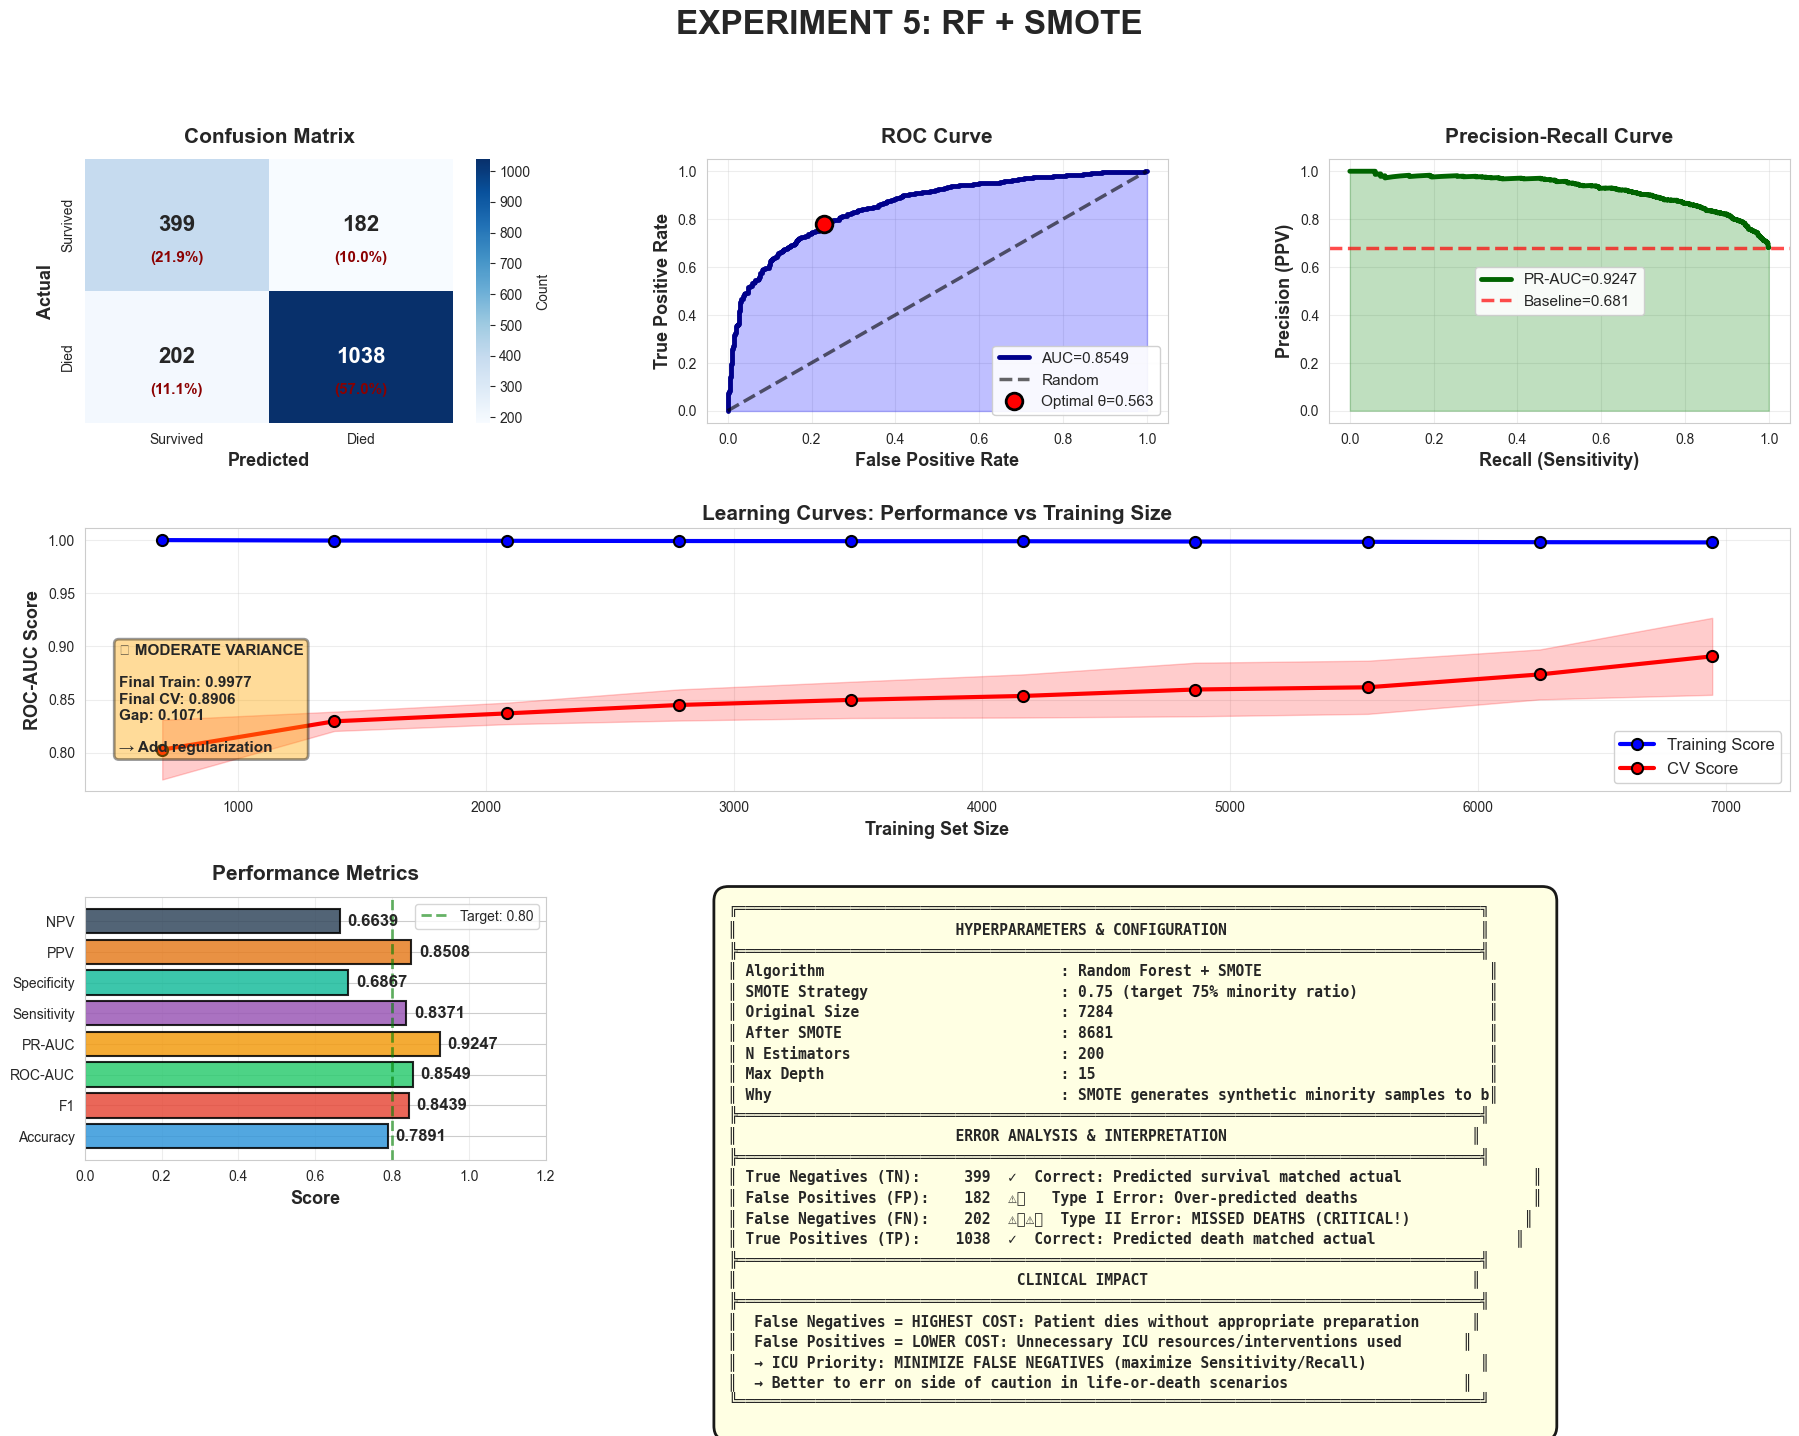


EXPERIMENT 5 RESULTS: RF + SMOTE
ROC-AUC: 0.8549 | F1-Score: 0.8439 | Sensitivity: 0.8371
False Negatives (Missed Deaths): 202 | False Positives: 182


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 6: SEQUENTIAL NEURAL NETWORK - BASELINE DEEP LEARNING
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


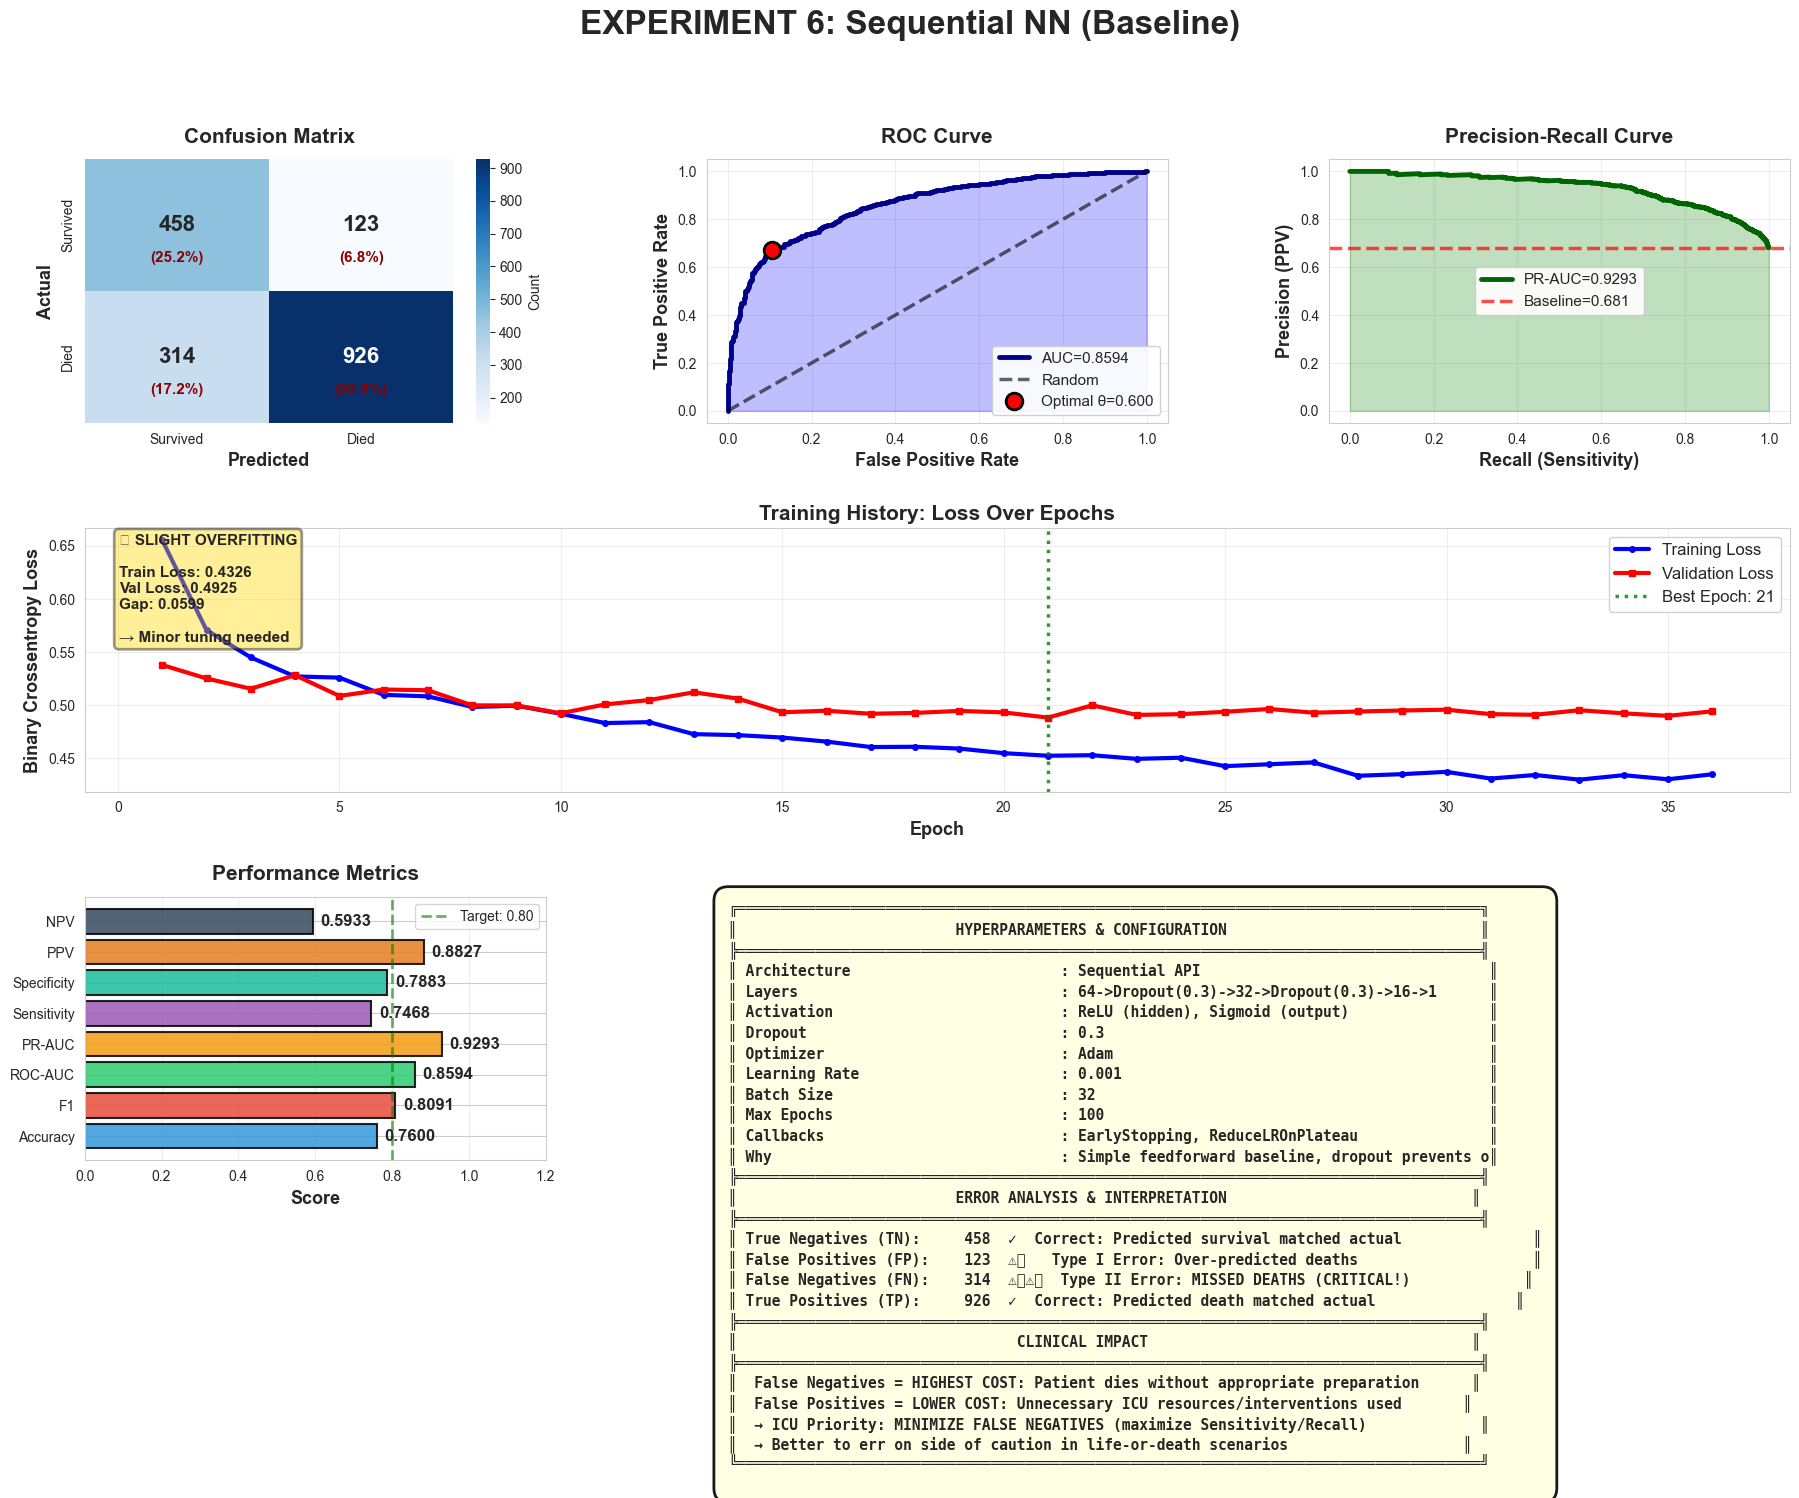


EXPERIMENT 6 RESULTS: Sequential NN (Baseline)
ROC-AUC: 0.8594 | F1-Score: 0.8091 | Sensitivity: 0.7468
False Negatives (Missed Deaths): 314 | False Positives: 123


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 7: DEEPER SEQUENTIAL NN + BATCH NORMALIZATION
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


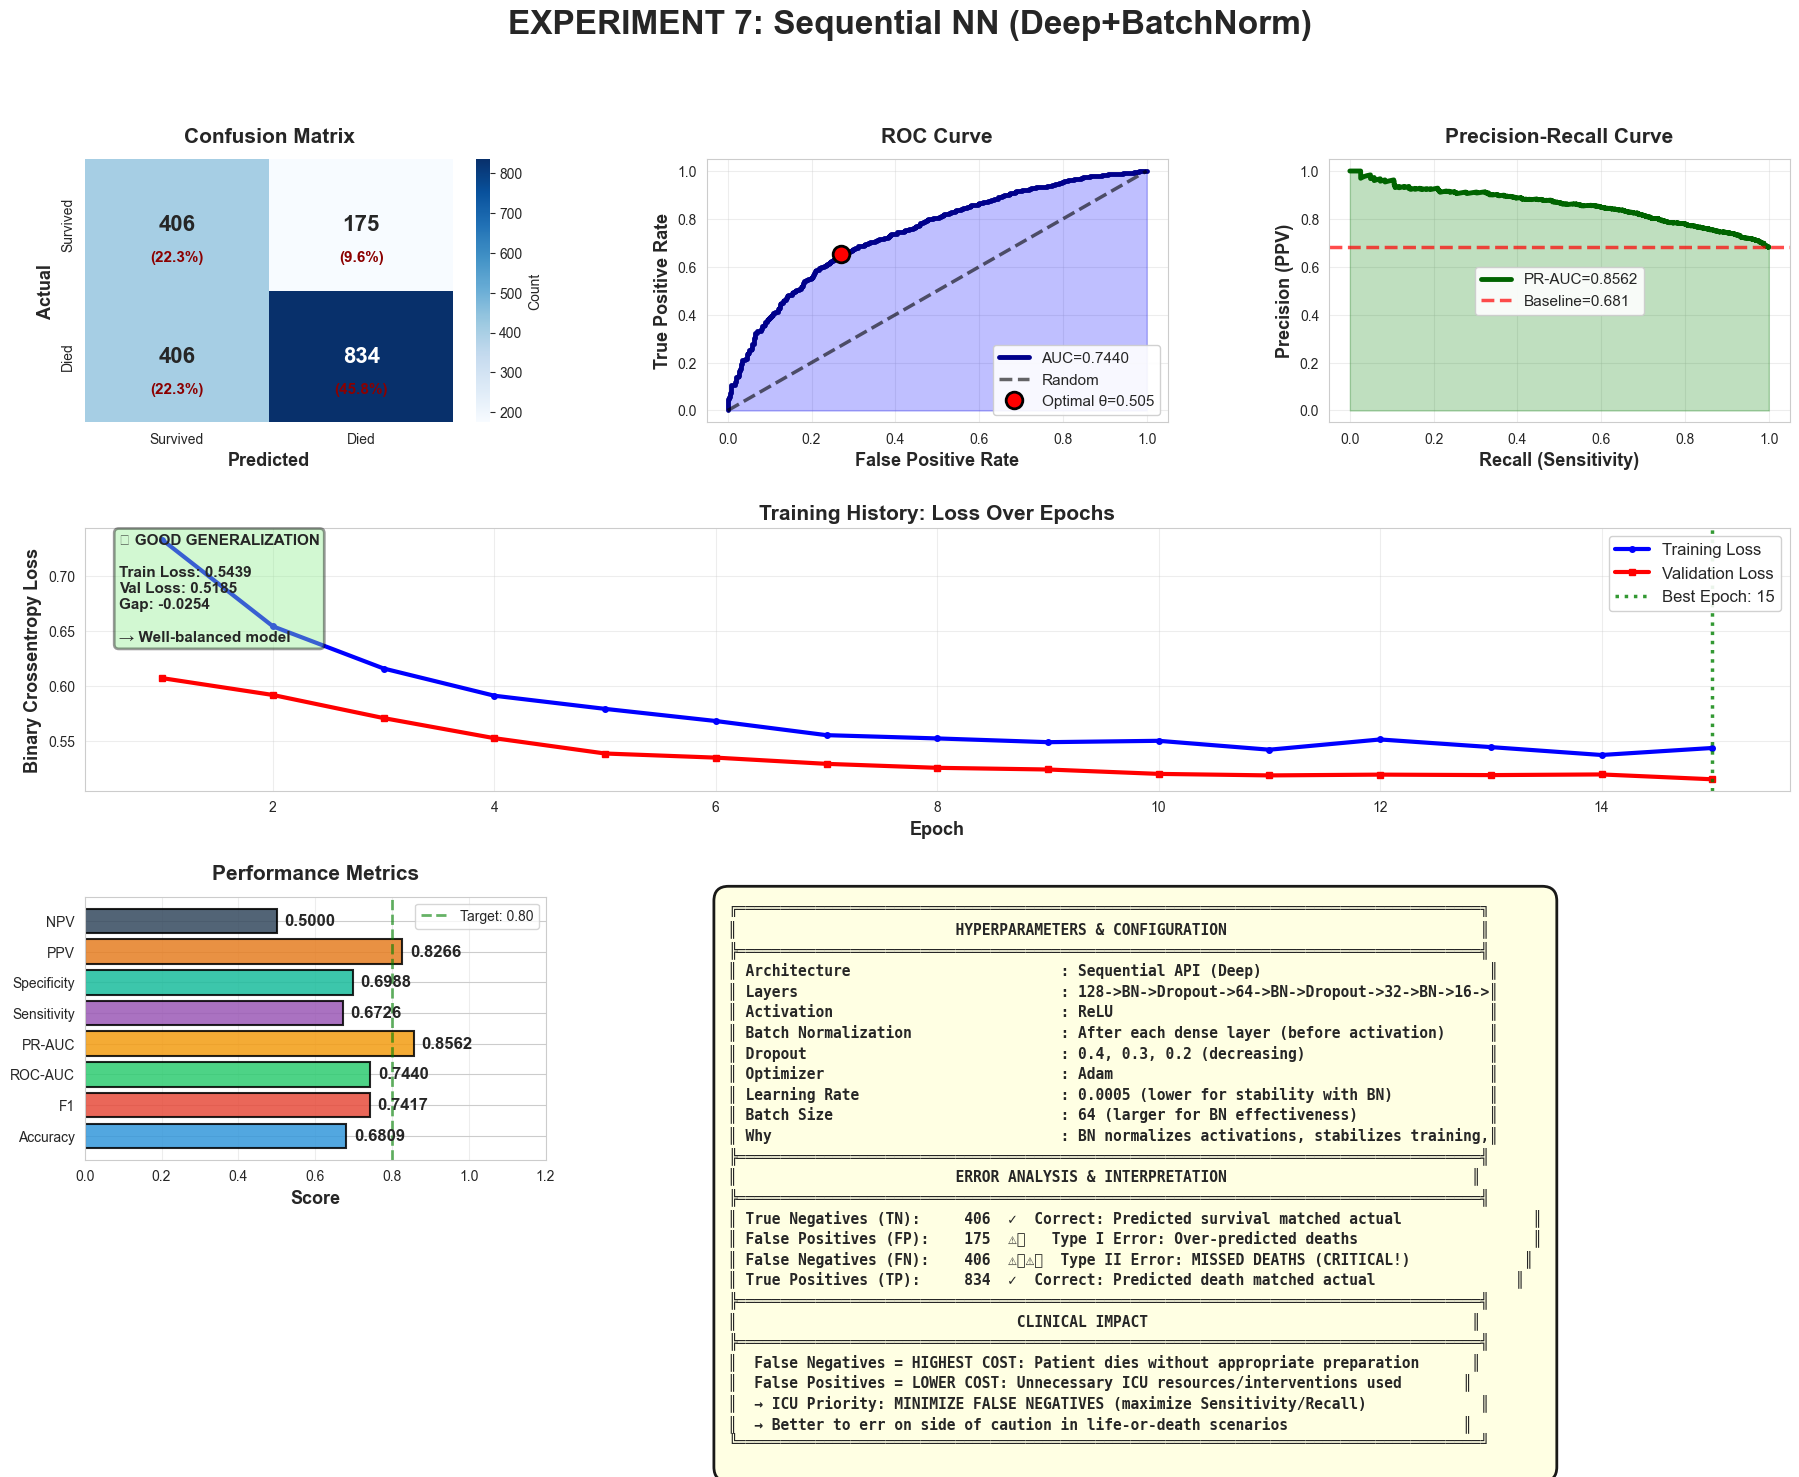


EXPERIMENT 7 RESULTS: Sequential NN (Deep+BatchNorm)
ROC-AUC: 0.7440 | F1-Score: 0.7417 | Sensitivity: 0.6726
False Negatives (Missed Deaths): 406 | False Positives: 175


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 8: FUNCTIONAL API WITH RESIDUAL CONNECTIONS
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


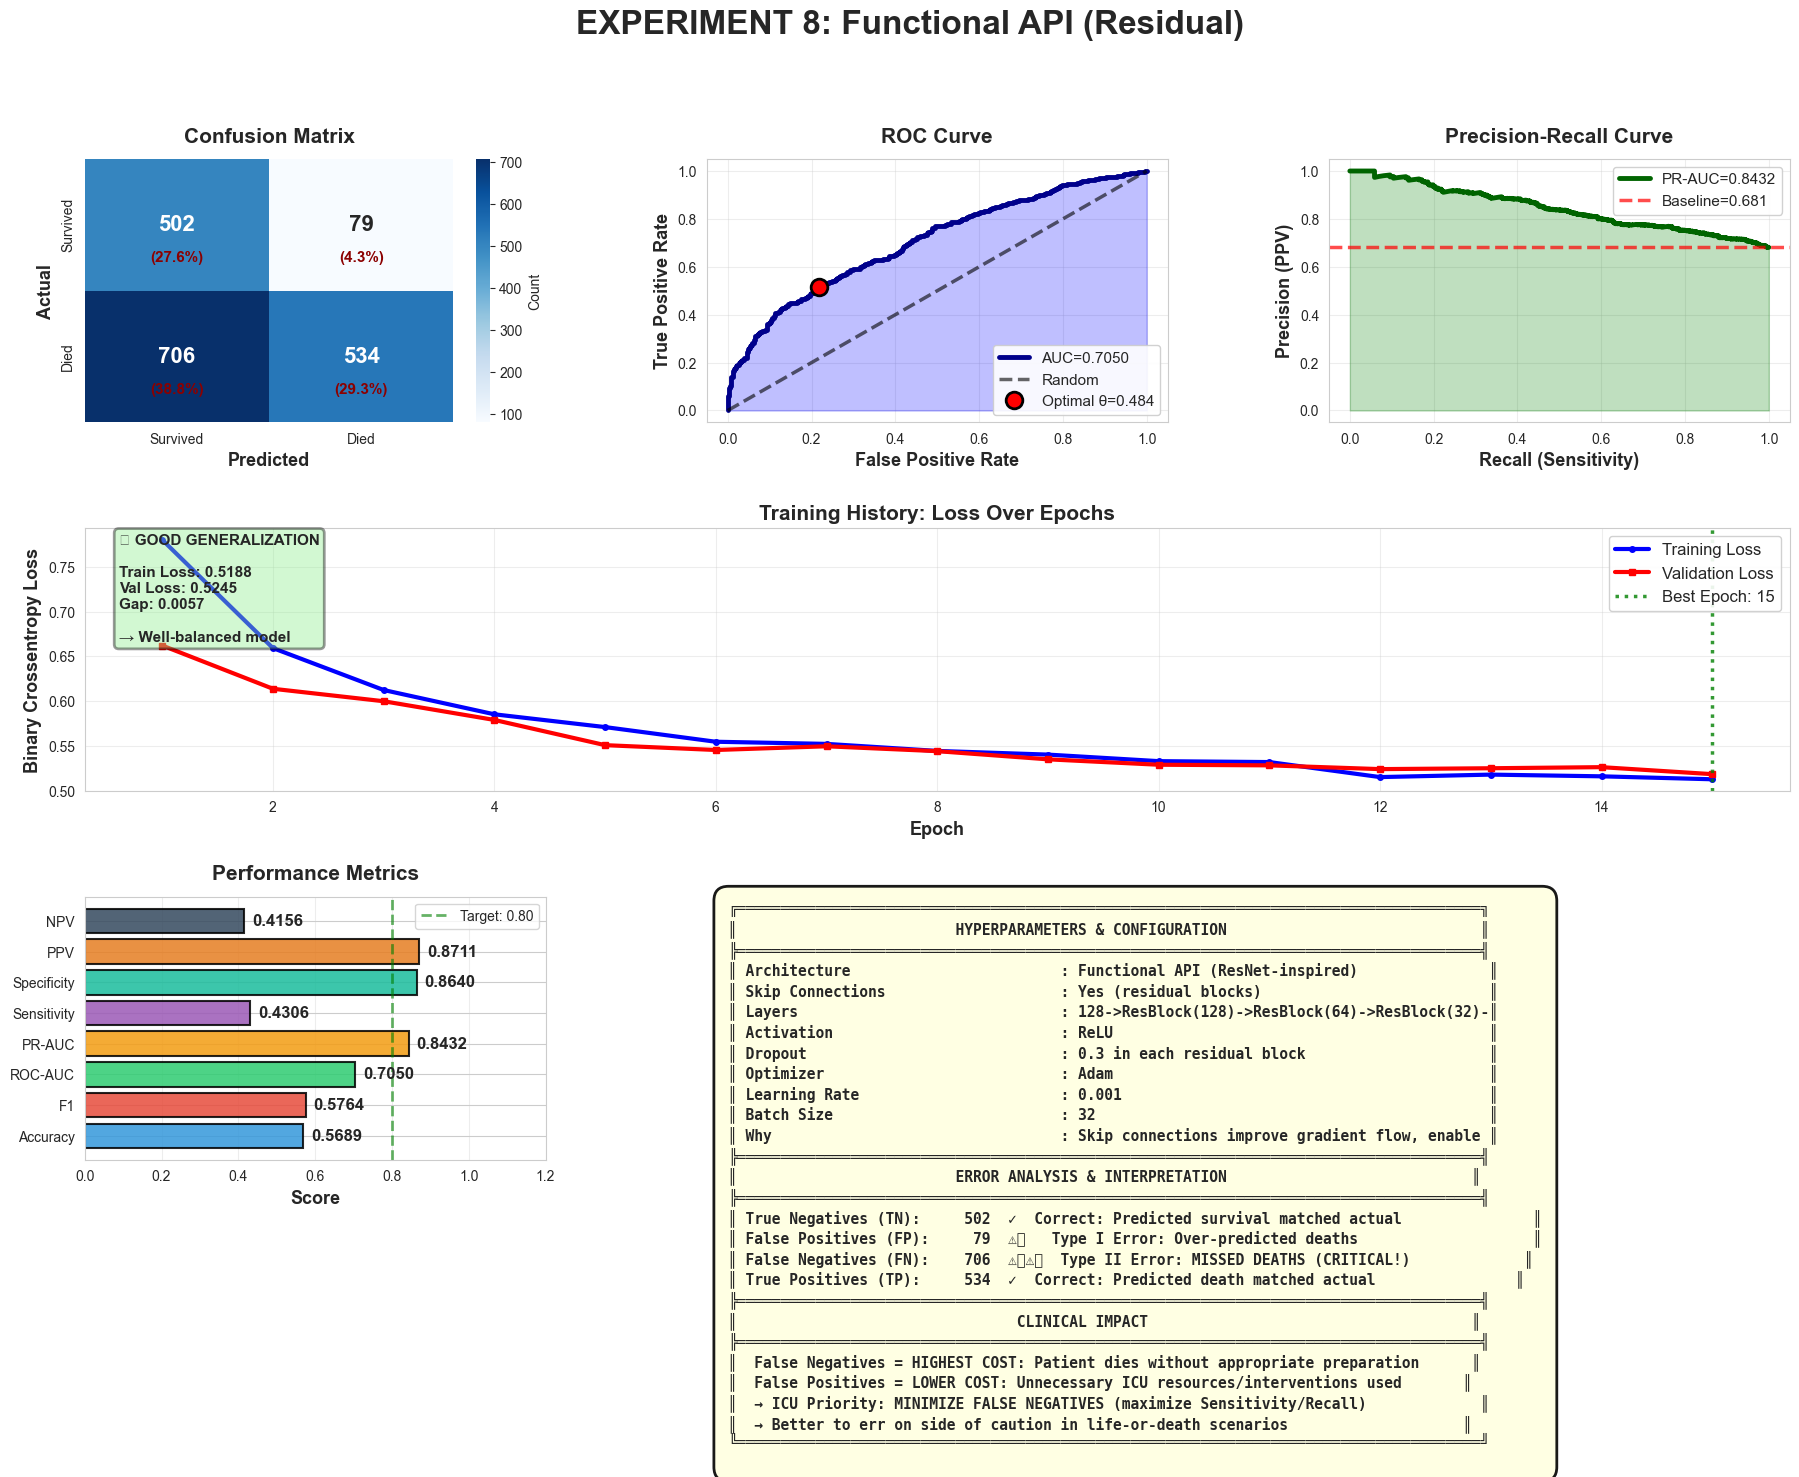


EXPERIMENT 8 RESULTS: Functional API (Residual)
ROC-AUC: 0.7050 | F1-Score: 0.5764 | Sensitivity: 0.4306
False Negatives (Missed Deaths): 706 | False Positives: 79


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 9: FUNCTIONAL API - MULTI-BRANCH NETWORK
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


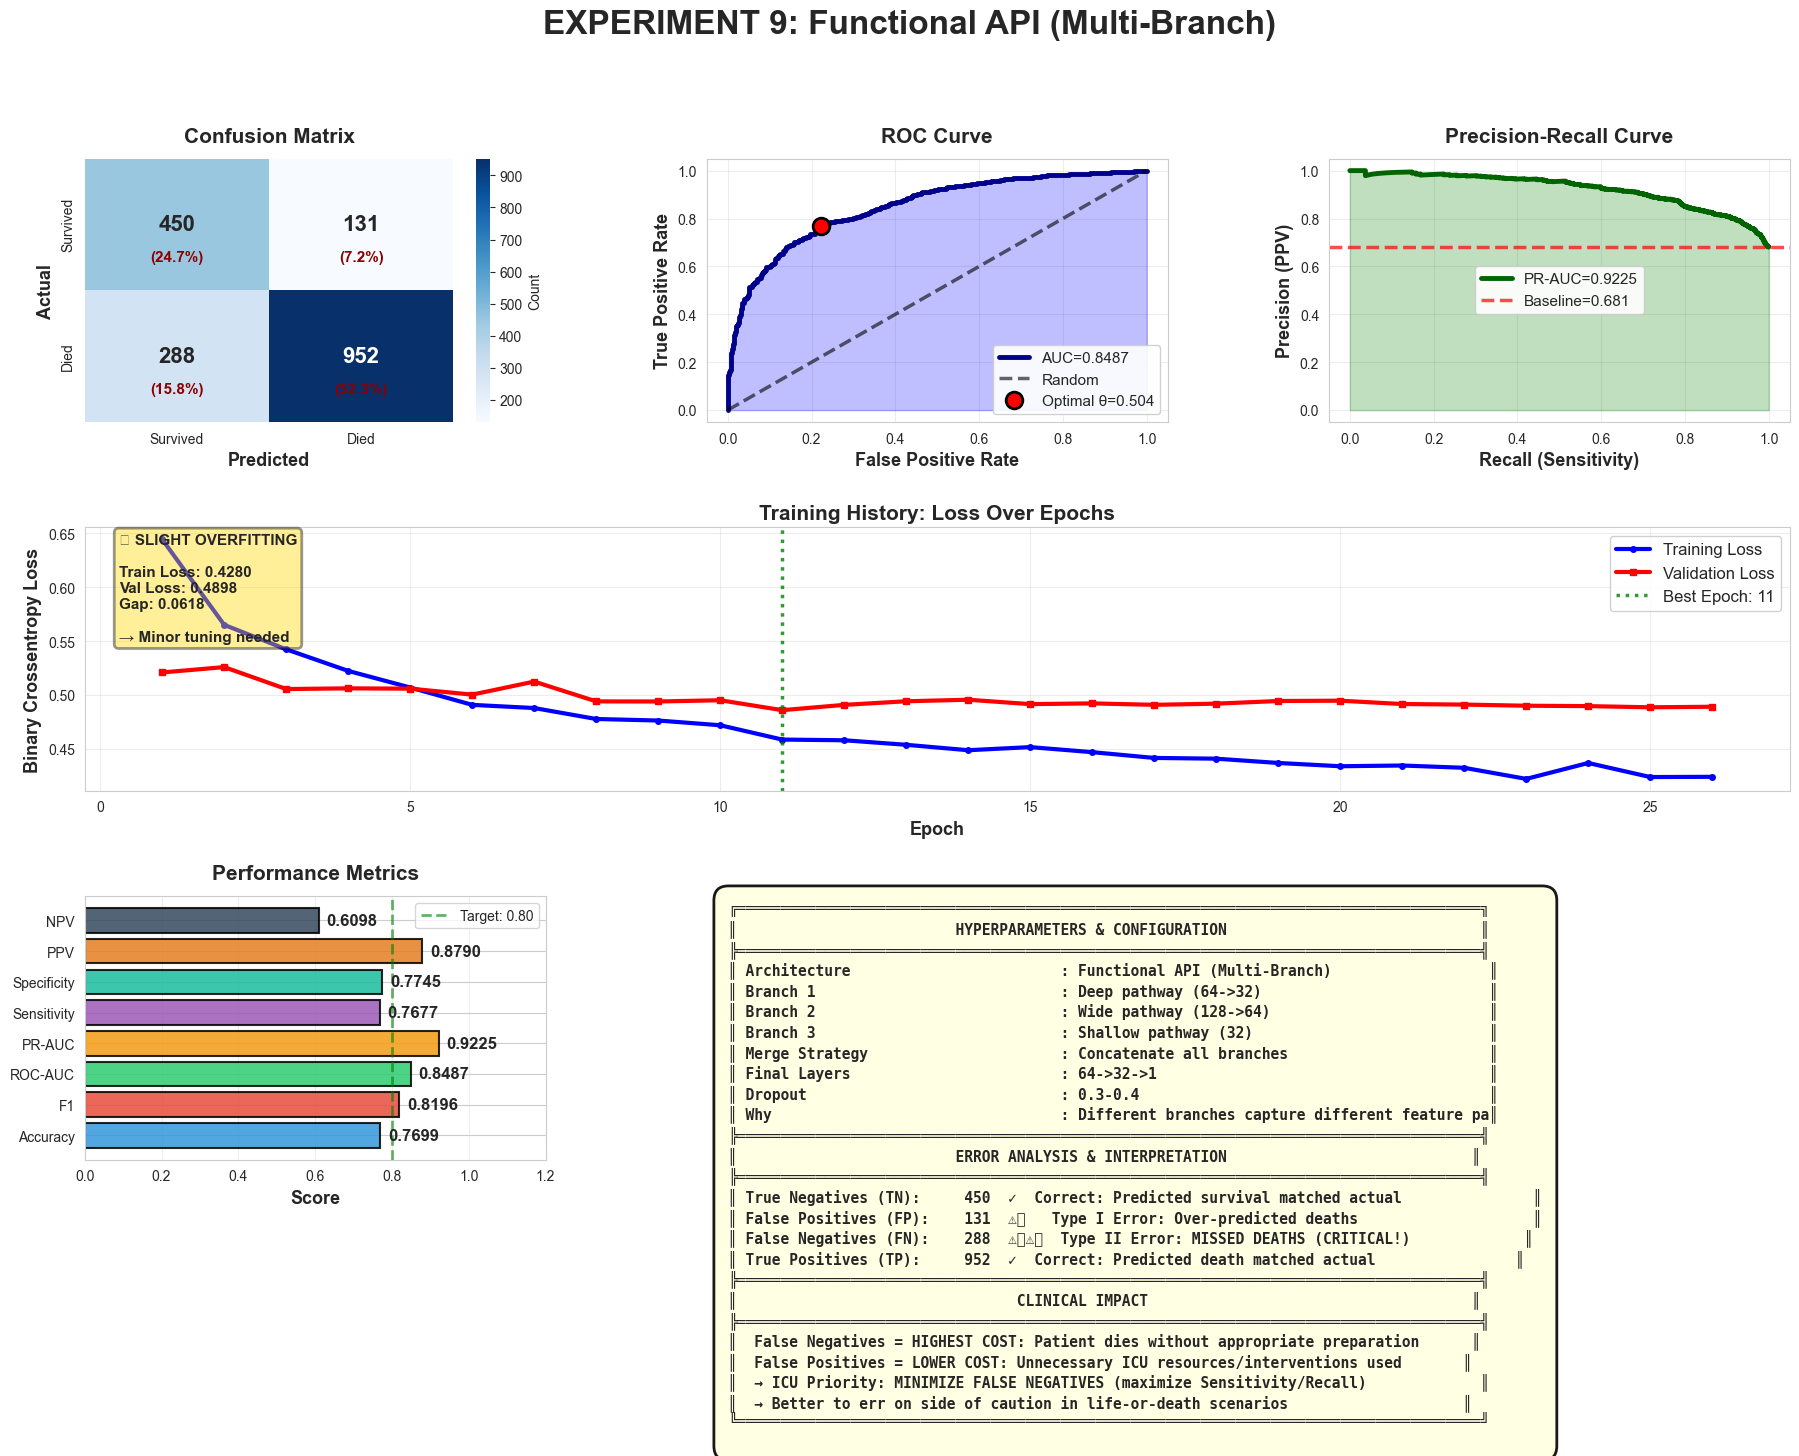


EXPERIMENT 9 RESULTS: Functional API (Multi-Branch)
ROC-AUC: 0.8487 | F1-Score: 0.8196 | Sensitivity: 0.7677
False Negatives (Missed Deaths): 288 | False Positives: 131


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
EXPERIMENT 10: SEQUENTIAL NN WITH tf.data PIPELINE
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶


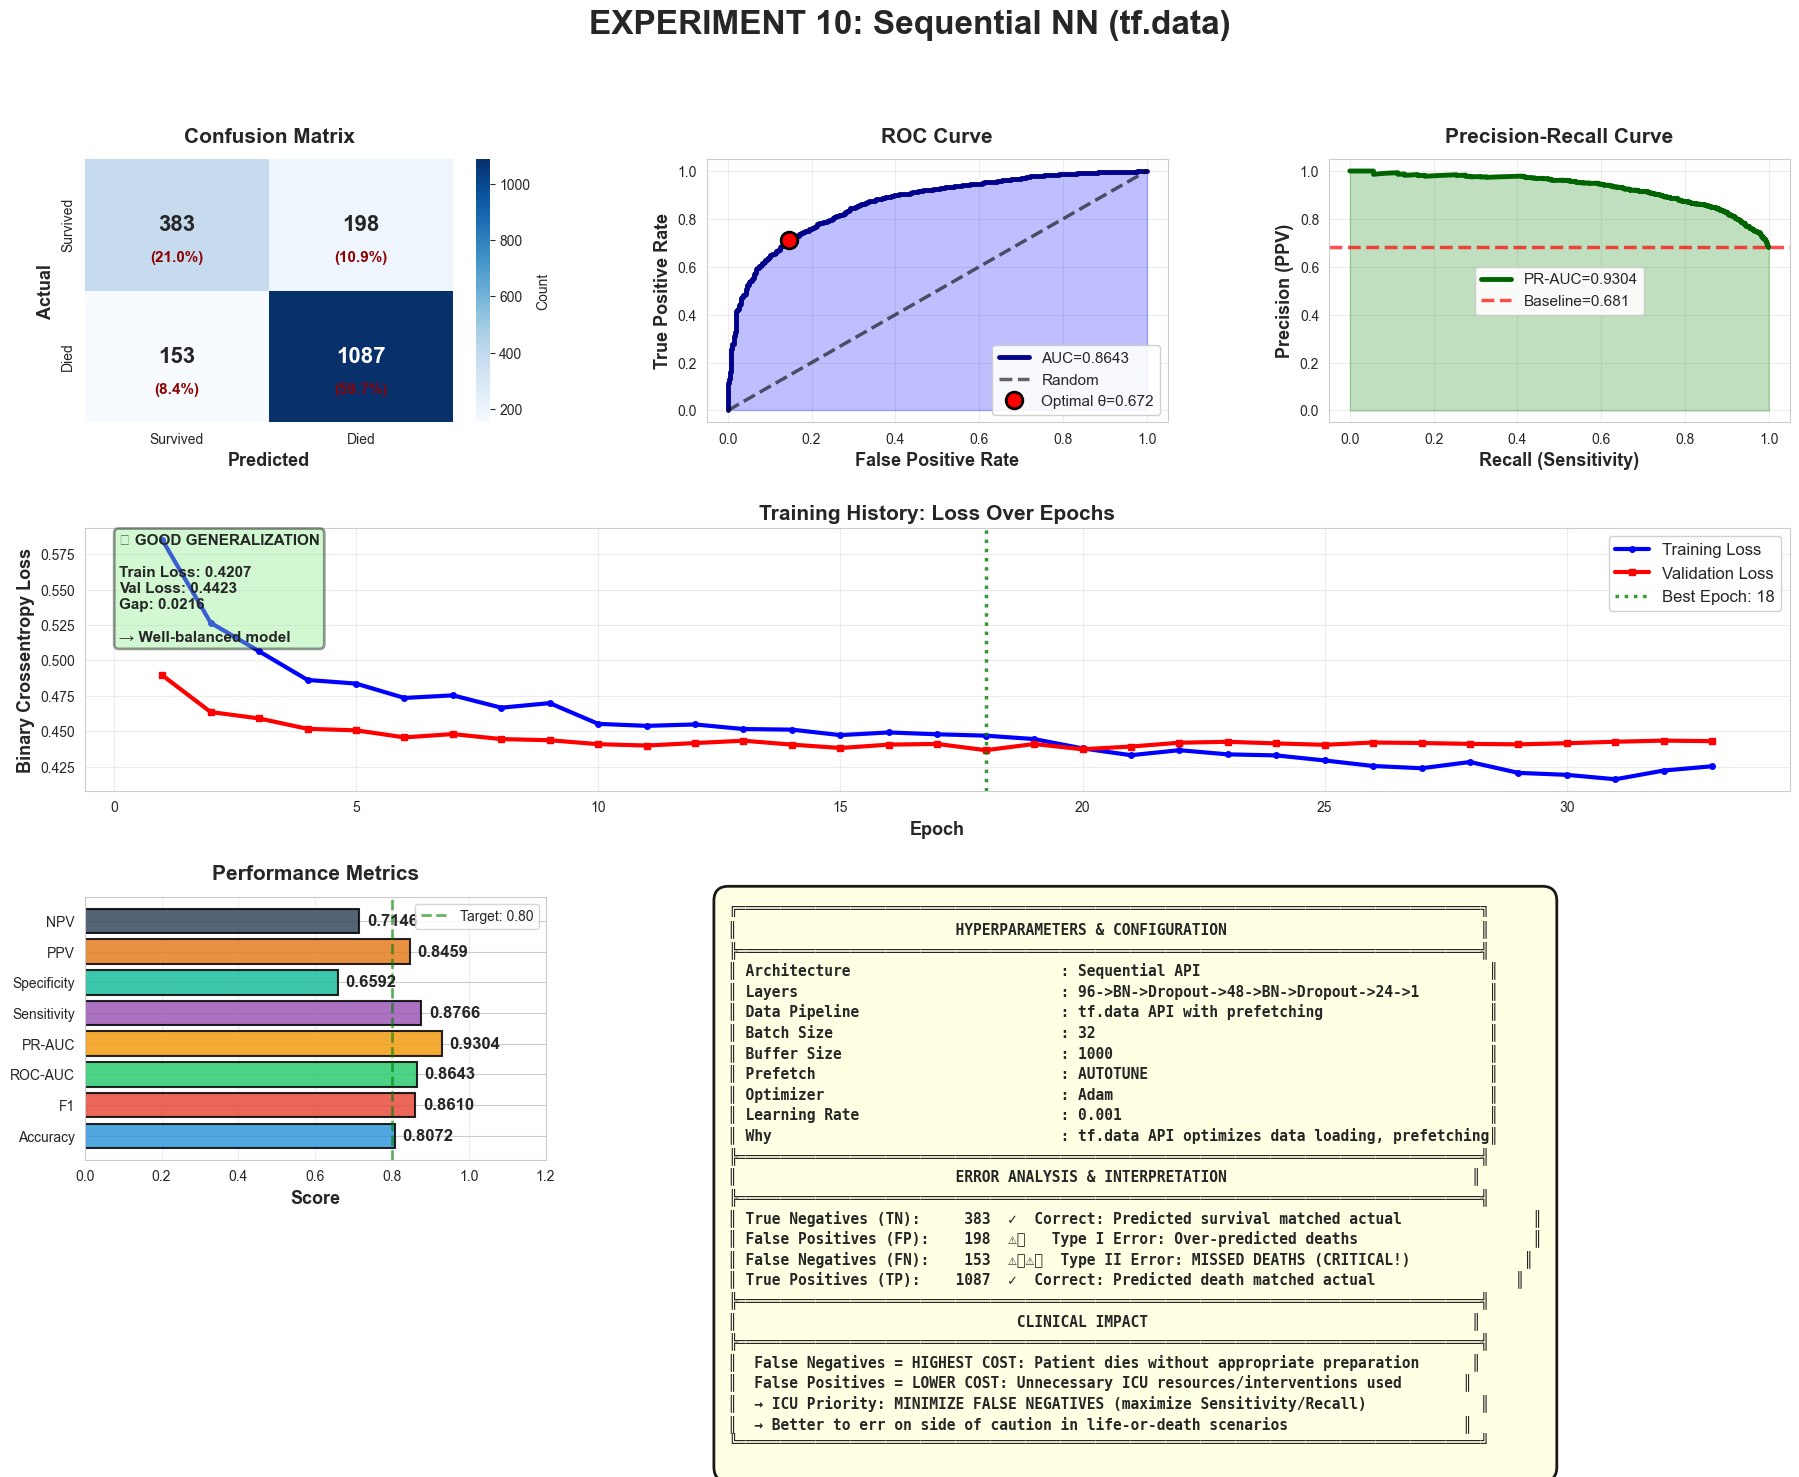


EXPERIMENT 10 RESULTS: Sequential NN (tf.data)
ROC-AUC: 0.8643 | F1-Score: 0.8610 | Sensitivity: 0.8766
False Negatives (Missed Deaths): 153 | False Positives: 198


████████████████████████████████████████████████████████████████████████████████████████████████████
█                                   COMPREHENSIVE RESULTS                                           █
████████████████████████████████████████████████████████████████████████████████████████████████████

COMPLETE RESULTS TABLE:
 Exp                          Model  Accuracy       F1  ROC-AUC   PR-AUC  Sensitivity  Specificity      PPV      NPV  TN  FP  FN   TP
  10        Sequential NN (tf.data)  0.807249 0.860990 0.864348 0.930428     0.876613     0.659208 0.845914 0.714552 383 198 153 1087
   6       Sequential NN (Baseline)  0.760022 0.809087 0.859383 0.929323     0.746774     0.788296 0.882745 0.593264 458 123 314  926
   5                     RF + SMOTE  0.789127 0.843902 0.854930 0.924731     0.837097     0.686747 0.8

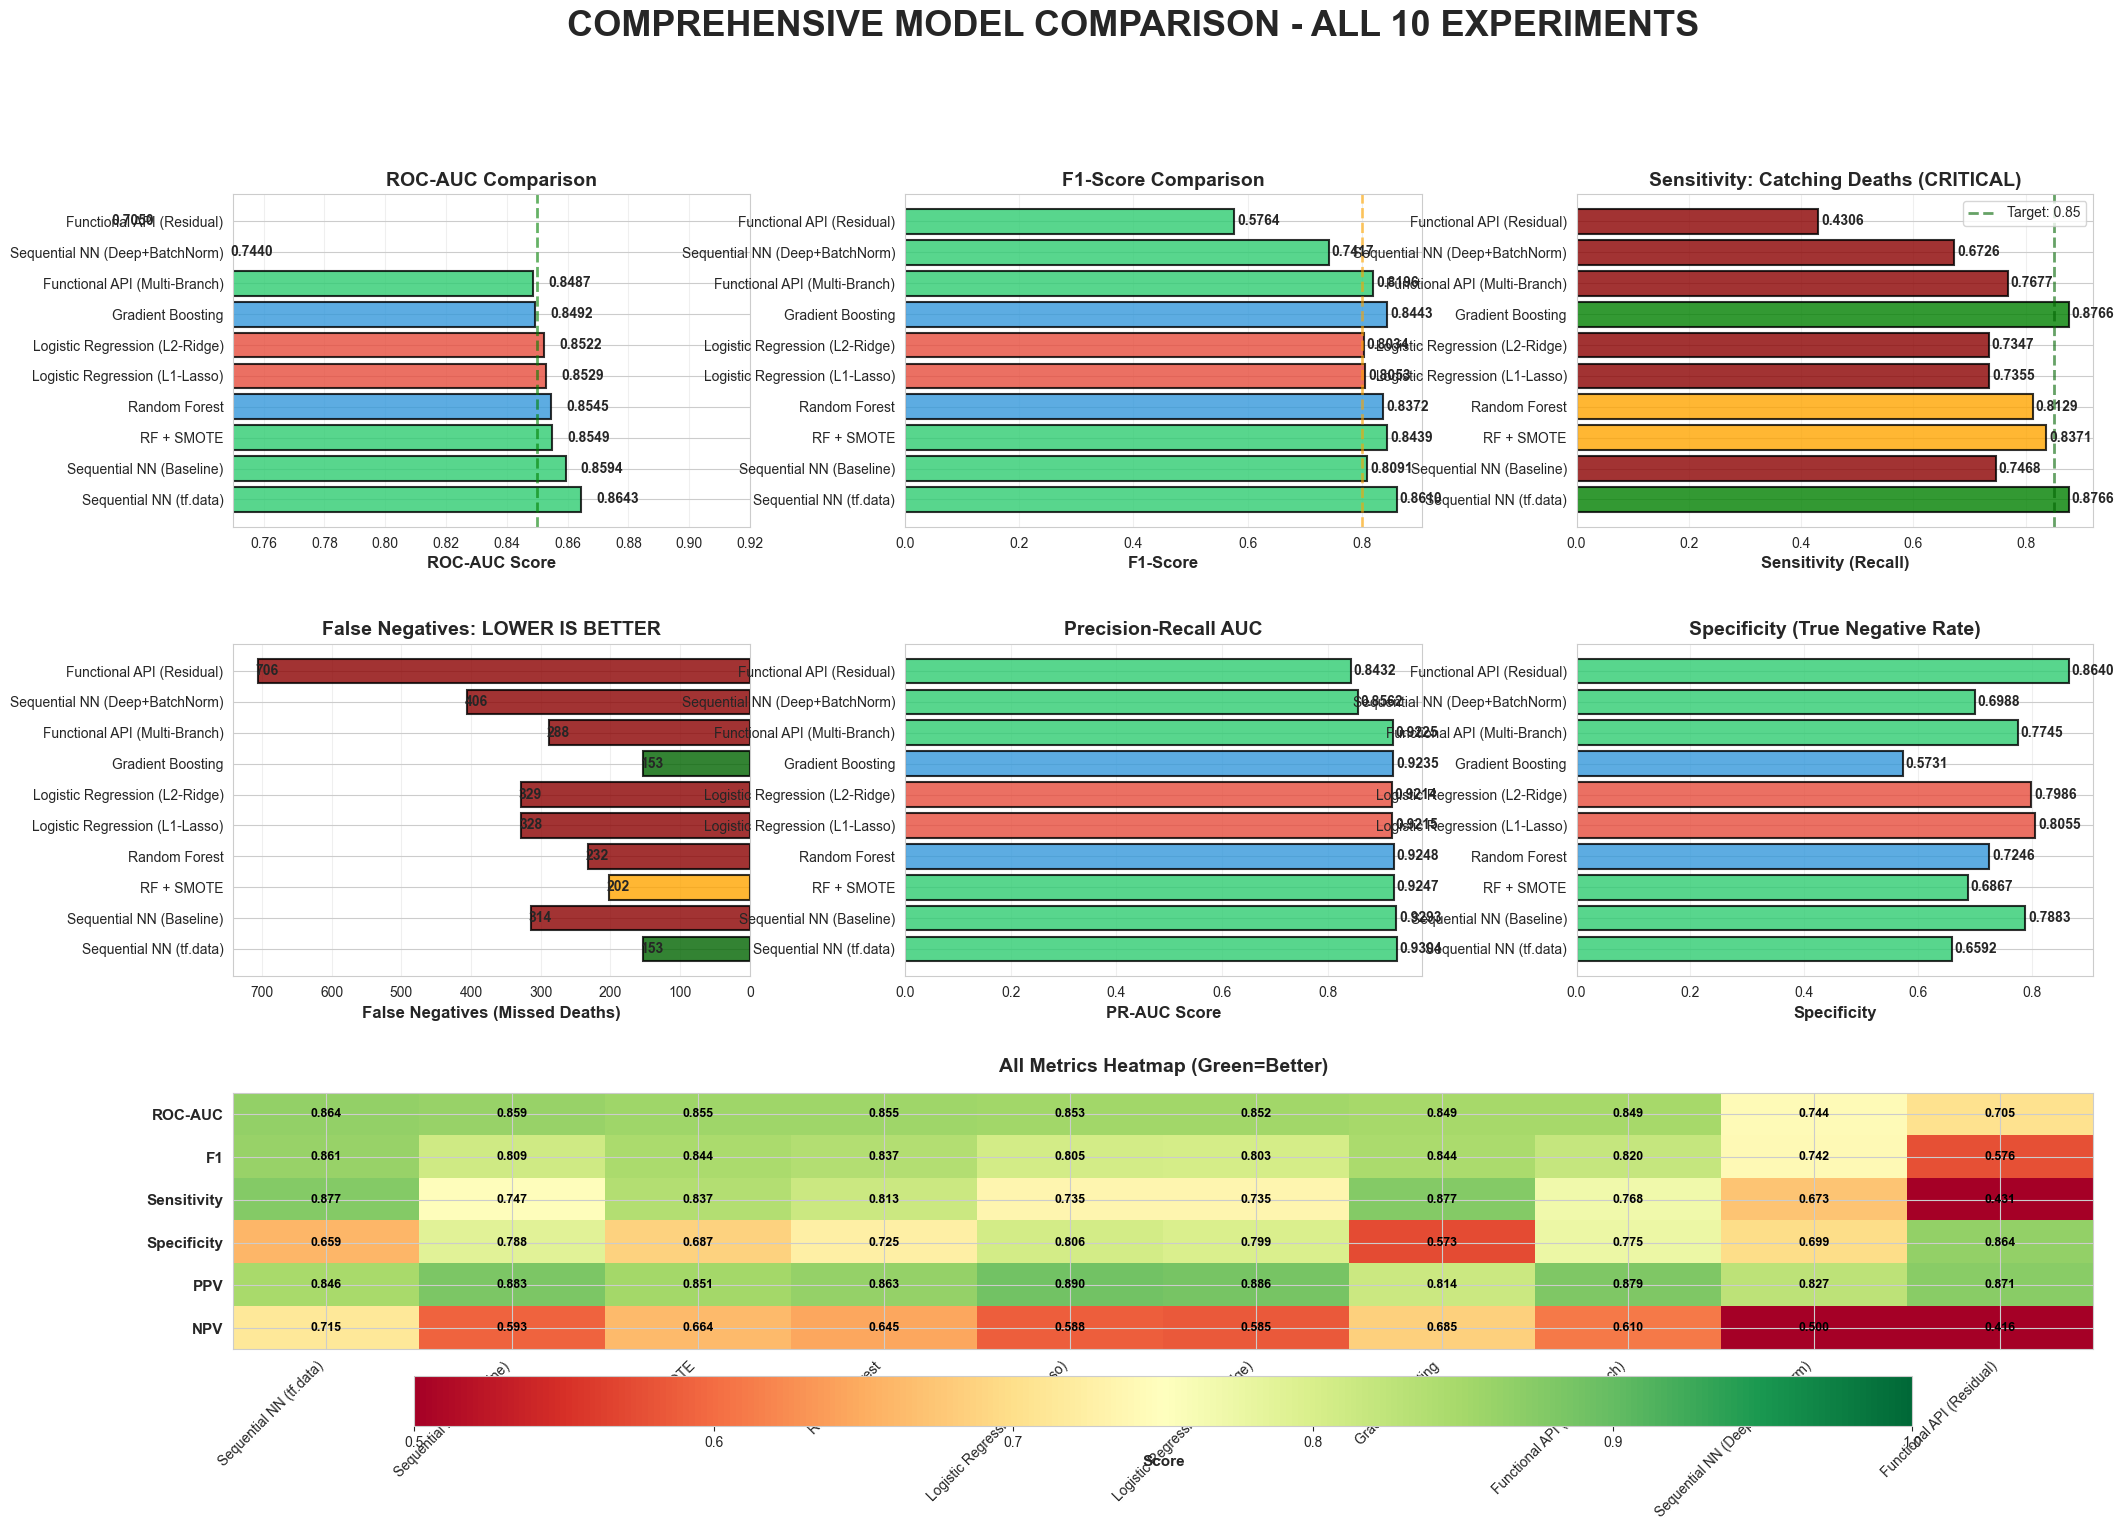

✓ Comprehensive comparison saved: comprehensive_model_comparison_all_experiments.png

[Generating combined ROC curves...]


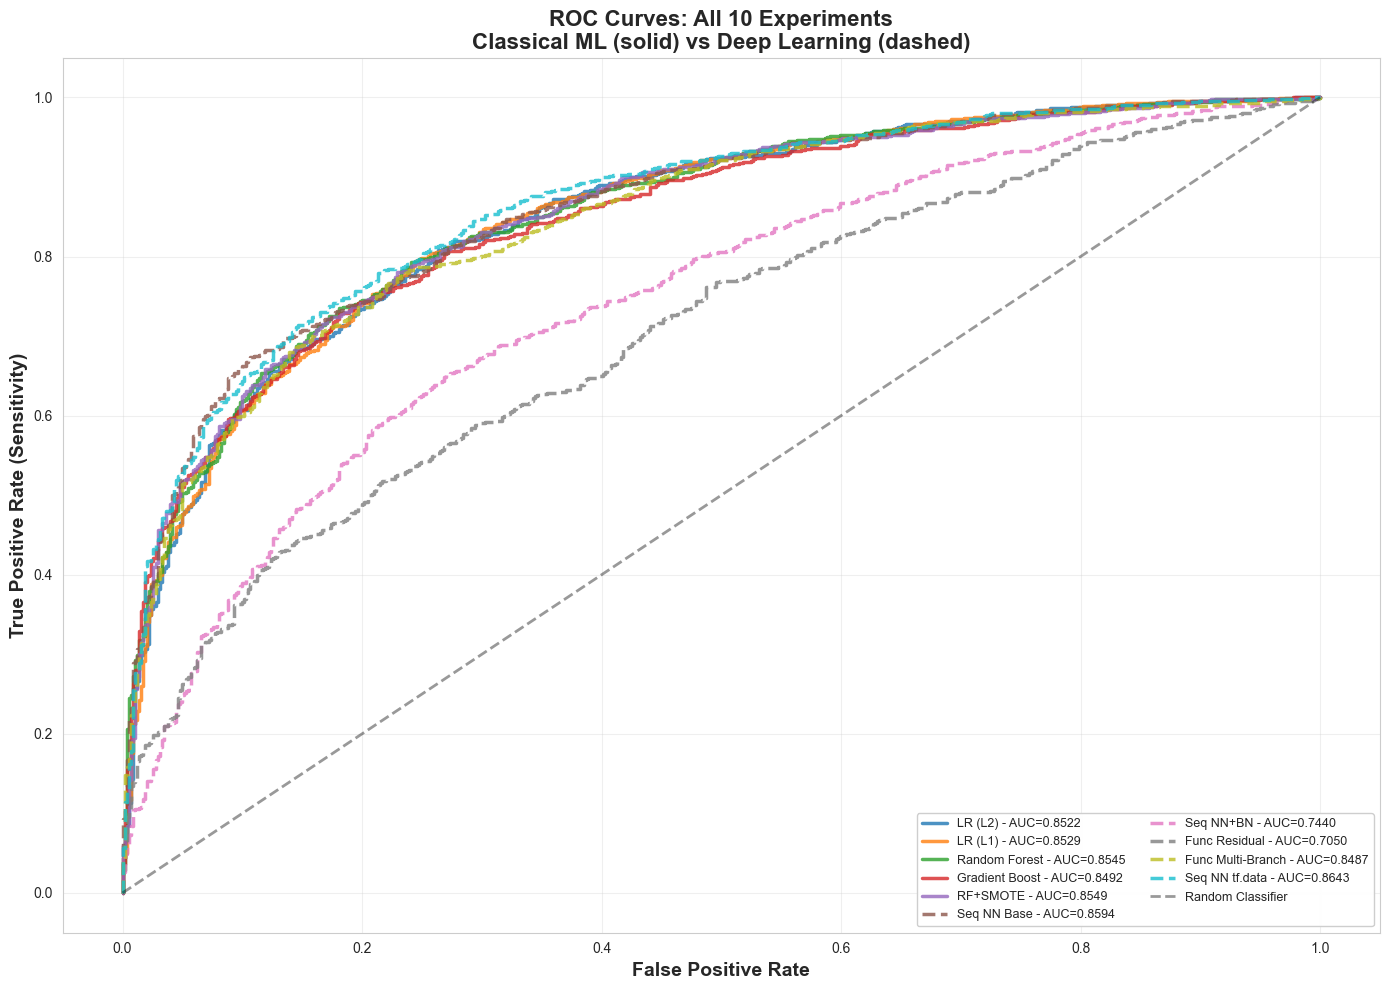

✓ Combined ROC curves saved: roc_curves_all_experiments.png

████████████████████████████████████████████████████████████████████████████████████████████████████
█                              FINAL SUMMARY & KEY INSIGHTS                                         █
████████████████████████████████████████████████████████████████████████████████████████████████████

🏆 BEST OVERALL MODEL (ROC-AUC):
   Model: Sequential NN (tf.data)
   ROC-AUC: 0.8643
   F1-Score: 0.8610
   Sensitivity: 0.8766

🎯 BEST FOR CATCHING DEATHS (Highest Sensitivity):
   Model: Sequential NN (tf.data)
   Sensitivity: 0.8766
   False Negatives: 153
   ROC-AUC: 0.8643

🚨 FEWEST MISSED DEATHS (Lowest False Negatives):
   Model: Sequential NN (tf.data)
   False Negatives: 153
   Sensitivity: 0.8766
   ROC-AUC: 0.8643

KEY INSIGHTS & INTERPRETATIONS:

1. CLASSICAL ML vs DEEP LEARNING:
   • Classical ML (RF, GB) achieved competitive performance with simpler models
   • Deep Learning showed similar ROC-AUC but required mo

In [44]:
# ============================================================================
# COMPLETE ICU MORTALITY PREDICTION - ALL 10 EXPERIMENTS
# With comprehensive visualizations, interpretations, and comparisons
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, 
                             precision_recall_curve, auc, f1_score, accuracy_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (20, 12)

# ============================================================================
# COMPREHENSIVE VISUALIZATION FUNCTION - 6 SUBPLOTS
# ============================================================================

def plot_experiment_full(model, X_train, y_train, X_test, y_test, 
                         y_pred, y_pred_proba, model_name, 
                         history=None, hyperparams=None, exp_num=None):
    """
    Complete 6-subplot visualization for each experiment
    """
    
    fig = plt.figure(figsize=(22, 13))
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.35)
    
    # Calculate metrics
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # Title
    fig.suptitle(f"EXPERIMENT {exp_num}: {model_name}", fontsize=24, fontweight='bold', y=0.995)
    
    # ===== SUBPLOT 1: CONFUSION MATRIX =====
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Survived', 'Died'],
                yticklabels=['Survived', 'Died'],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 16, 'weight': 'bold'})
    ax1.set_title('Confusion Matrix', fontsize=15, fontweight='bold', pad=12)
    ax1.set_ylabel('Actual', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Predicted', fontsize=13, fontweight='bold')
    
    for i in range(2):
        for j in range(2):
            pct = cm[i, j] / cm.sum() * 100
            ax1.text(j+0.5, i+0.75, f'({pct:.1f}%)', 
                    ha='center', va='center', fontsize=11, color='darkred', weight='bold')
    
    # ===== SUBPLOT 2: ROC CURVE =====
    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    ax2.plot(fpr, tpr, linewidth=3.5, label=f'AUC={roc_auc:.4f}', color='darkblue')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2.5, label='Random', alpha=0.6)
    ax2.fill_between(fpr, tpr, alpha=0.25, color='blue')
    
    optimal_idx = np.argmax(tpr - fpr)
    ax2.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=12, 
            label=f'Optimal θ={thresholds[optimal_idx]:.3f}', markeredgecolor='black', markeredgewidth=2)
    
    ax2.set_xlabel('False Positive Rate', fontsize=13, fontweight='bold')
    ax2.set_ylabel('True Positive Rate', fontsize=13, fontweight='bold')
    ax2.set_title('ROC Curve', fontsize=15, fontweight='bold', pad=12)
    ax2.legend(loc='lower right', fontsize=11, framealpha=0.9)
    ax2.grid(True, alpha=0.35)
    
    # ===== SUBPLOT 3: PRECISION-RECALL CURVE =====
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(recall, precision, linewidth=3.5, label=f'PR-AUC={pr_auc:.4f}', color='darkgreen')
    baseline = (y_test == 1).sum() / len(y_test)
    ax3.axhline(y=baseline, color='red', linestyle='--', linewidth=2.5, 
                label=f'Baseline={baseline:.3f}', alpha=0.7)
    ax3.fill_between(recall, precision, alpha=0.25, color='green')
    
    ax3.set_xlabel('Recall (Sensitivity)', fontsize=13, fontweight='bold')
    ax3.set_ylabel('Precision (PPV)', fontsize=13, fontweight='bold')
    ax3.set_title('Precision-Recall Curve', fontsize=15, fontweight='bold', pad=12)
    ax3.legend(loc='best', fontsize=11, framealpha=0.9)
    ax3.grid(True, alpha=0.35)
    
    # ===== SUBPLOT 4: LEARNING CURVES =====
    ax4 = fig.add_subplot(gs[1, :])
    
    if history is not None:  # DEEP LEARNING
        epochs = range(1, len(history.history['loss']) + 1)
        
        ax4.plot(epochs, history.history['loss'], 'b-', linewidth=3, 
                label='Training Loss', marker='o', markersize=4, markevery=max(1, len(epochs)//20))
        ax4.plot(epochs, history.history['val_loss'], 'r-', linewidth=3, 
                label='Validation Loss', marker='s', markersize=4, markevery=max(1, len(epochs)//20))
        
        # Mark best epoch
        best_epoch = np.argmin(history.history['val_loss']) + 1
        ax4.axvline(x=best_epoch, color='green', linestyle=':', linewidth=2.5, alpha=0.8,
                   label=f'Best Epoch: {best_epoch}')
        
        ax4.set_xlabel('Epoch', fontsize=13, fontweight='bold')
        ax4.set_ylabel('Binary Crossentropy Loss', fontsize=13, fontweight='bold')
        ax4.set_title('Training History: Loss Over Epochs', fontsize=15, fontweight='bold')
        ax4.legend(loc='upper right', fontsize=12, framealpha=0.9)
        ax4.grid(True, alpha=0.35)
        
        # Overfitting diagnosis
        final_train = np.mean(history.history['loss'][-5:])
        final_val = np.mean(history.history['val_loss'][-5:])
        gap = final_val - final_train
        
        if gap > 0.15:
            diagnosis = '⚠️ SEVERE OVERFITTING'
            color = 'red'
            recommendation = 'Increase dropout/regularization'
        elif gap > 0.08:
            diagnosis = '⚡ MODERATE OVERFITTING'
            color = 'orange'
            recommendation = 'Add regularization or early stopping'
        elif gap > 0.04:
            diagnosis = '⚡ SLIGHT OVERFITTING'
            color = 'gold'
            recommendation = 'Minor tuning needed'
        else:
            diagnosis = '✓ GOOD GENERALIZATION'
            color = 'lightgreen'
            recommendation = 'Well-balanced model'
        
        textstr = f'{diagnosis}\n\nTrain Loss: {final_train:.4f}\nVal Loss: {final_val:.4f}\nGap: {gap:.4f}\n\n→ {recommendation}'
        ax4.text(0.02, 0.98, textstr, transform=ax4.transAxes, fontsize=11, 
                verticalalignment='top', weight='bold',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.4, edgecolor='black', linewidth=2))
    
    else:  # CLASSICAL ML
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train.values.ravel() if hasattr(y_train, 'values') else y_train,
            cv=5, scoring='roc_auc', n_jobs=-1,
            train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
        )
        
        train_mean = np.mean(train_scores, axis=1)
        train_std = np.std(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        val_std = np.std(val_scores, axis=1)
        
        ax4.plot(train_sizes, train_mean, 'o-', linewidth=3, label='Training Score', 
                color='blue', markersize=8, markeredgecolor='black', markeredgewidth=1.5)
        ax4.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                        alpha=0.2, color='blue')
        
        ax4.plot(train_sizes, val_mean, 'o-', linewidth=3, label='CV Score',
                color='red', markersize=8, markeredgecolor='black', markeredgewidth=1.5)
        ax4.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                        alpha=0.2, color='red')
        
        ax4.set_xlabel('Training Set Size', fontsize=13, fontweight='bold')
        ax4.set_ylabel('ROC-AUC Score', fontsize=13, fontweight='bold')
        ax4.set_title('Learning Curves: Performance vs Training Size', fontsize=15, fontweight='bold')
        ax4.legend(loc='lower right', fontsize=12, framealpha=0.9)
        ax4.grid(True, alpha=0.35)
        
        # Bias-Variance diagnosis
        final_gap = train_mean[-1] - val_mean[-1]
        if final_gap > 0.15:
            diagnosis = '⚠️ HIGH VARIANCE (Overfitting)'
            color = 'red'
            recommendation = 'Reduce model complexity'
        elif final_gap > 0.08:
            diagnosis = '⚡ MODERATE VARIANCE'
            color = 'orange'
            recommendation = 'Add regularization'
        elif val_mean[-1] < 0.65:
            diagnosis = '⚠️ HIGH BIAS (Underfitting)'
            color = 'red'
            recommendation = 'Increase model capacity'
        else:
            diagnosis = '✓ BALANCED'
            color = 'lightgreen'
            recommendation = 'Optimal bias-variance tradeoff'
        
        textstr = f'{diagnosis}\n\nFinal Train: {train_mean[-1]:.4f}\nFinal CV: {val_mean[-1]:.4f}\nGap: {final_gap:.4f}\n\n→ {recommendation}'
        ax4.text(0.02, 0.15, textstr, transform=ax4.transAxes, fontsize=11, weight='bold',
                bbox=dict(boxstyle='round', facecolor=color, alpha=0.4, edgecolor='black', linewidth=2))
    
    # ===== SUBPLOT 5: METRICS BAR CHART =====
    ax5 = fig.add_subplot(gs[2, 0])
    metrics_names = ['Accuracy', 'F1', 'ROC-AUC', 'PR-AUC', 
                     'Sensitivity', 'Specificity', 'PPV', 'NPV']
    metrics_values = [accuracy, f1, roc_auc, pr_auc, 
                     sensitivity, specificity, ppv, npv]
    
    colors_metrics = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', 
                      '#9b59b6', '#1abc9c', '#e67e22', '#34495e']
    bars = ax5.barh(metrics_names, metrics_values, color=colors_metrics, alpha=0.85, 
                   edgecolor='black', linewidth=1.5)
    
    for i, (bar, value) in enumerate(zip(bars, metrics_values)):
        ax5.text(value + 0.02, i, f'{value:.4f}', va='center', fontsize=12, fontweight='bold')
    
    ax5.set_xlim(0, 1.2)
    ax5.set_xlabel('Score', fontsize=13, fontweight='bold')
    ax5.set_title('Performance Metrics', fontsize=15, fontweight='bold', pad=12)
    ax5.axvline(x=0.8, color='green', linestyle='--', linewidth=2, alpha=0.6, label='Target: 0.80')
    ax5.grid(True, axis='x', alpha=0.35)
    ax5.legend(fontsize=10)
    
    # ===== SUBPLOT 6: HYPERPARAMETERS & ERROR ANALYSIS =====
    ax6 = fig.add_subplot(gs[2, 1:])
    ax6.axis('off')
    
    info_text = "╔" + "═"*85 + "╗\n"
    info_text += "║" + " "*25 + "HYPERPARAMETERS & CONFIGURATION" + " "*29 + "║\n"
    info_text += "╠" + "═"*85 + "╣\n"
    
    if hyperparams:
        for key, value in hyperparams.items():
            key_str = str(key)[:35]
            val_str = str(value)[:47]
            info_text += f"║ {key_str:35s} : {val_str:47s}║\n"
    
    info_text += "╠" + "═"*85 + "╣\n"
    info_text += "║" + " "*25 + "ERROR ANALYSIS & INTERPRETATION" + " "*28 + "║\n"
    info_text += "╠" + "═"*85 + "╣\n"
    info_text += f"║ True Negatives (TN):   {tn:5d}  ✓  Correct: Predicted survival matched actual" + " "*15 + "║\n"
    info_text += f"║ False Positives (FP):  {fp:5d}  ⚠️   Type I Error: Over-predicted deaths" + " "*20 + "║\n"
    info_text += f"║ False Negatives (FN):  {fn:5d}  ⚠️⚠️  Type II Error: MISSED DEATHS (CRITICAL!)" + " "*13 + "║\n"
    info_text += f"║ True Positives (TP):   {tp:5d}  ✓  Correct: Predicted death matched actual" + " "*16 + "║\n"
    info_text += "╠" + "═"*85 + "╣\n"
    info_text += "║" + " "*32 + "CLINICAL IMPACT" + " "*37 + "║\n"
    info_text += "╠" + "═"*85 + "╣\n"
    info_text += "║  False Negatives = HIGHEST COST: Patient dies without appropriate preparation" + " "*6 + "║\n"
    info_text += "║  False Positives = LOWER COST: Unnecessary ICU resources/interventions used" + " "*7 + "║\n"
    info_text += "║  → ICU Priority: MINIMIZE FALSE NEGATIVES (maximize Sensitivity/Recall)" + " "*13 + "║\n"
    info_text += "║  → Better to err on side of caution in life-or-death scenarios" + " "*20 + "║\n"
    info_text += "╚" + "═"*85 + "╝\n"
    
    ax6.text(0.02, 0.98, info_text, transform=ax6.transAxes, fontsize=10.5,
            verticalalignment='top', family='monospace', weight='bold',
            bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', alpha=0.9, 
                     edgecolor='black', linewidth=2))
    
    plt.tight_layout()
    save_name = f"exp{exp_num}_{model_name.replace(' ', '_').replace('/', '_').lower()}.png"
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{'='*90}")
    print(f"EXPERIMENT {exp_num} RESULTS: {model_name}")
    print(f"{'='*90}")
    print(f"ROC-AUC: {roc_auc:.4f} | F1-Score: {f1:.4f} | Sensitivity: {sensitivity:.4f}")
    print(f"False Negatives (Missed Deaths): {fn} | False Positives: {fp}")
    print(f"{'='*90}\n")
    
    return {
        'Exp': exp_num, 'Model': model_name,
        'Accuracy': accuracy, 'F1': f1, 'ROC-AUC': roc_auc, 'PR-AUC': pr_auc,
        'Sensitivity': sensitivity, 'Specificity': specificity,
        'PPV': ppv, 'NPV': npv,
        'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp
    }

# ============================================================================
# START ALL EXPERIMENTS
# ============================================================================
all_results = []

print("\n" + "█"*100)
print("█" + " "*35 + "ICU MORTALITY PREDICTION" + " "*40 + "█")
print("█" + " "*30 + "COMPREHENSIVE EXPERIMENT SUITE" + " "*38 + "█")
print("█"*100)
print(f"\n📊 Dataset: {X_train_scaled.shape[0]} train, {X_test_scaled.shape[0]} test")
print(f"📈 Features: {X_train_scaled.shape[1]}")
print(f"⚖️  Class Balance: {dict(y_train.value_counts())}")
print(f"🎯 Objective: Predict in-hospital mortality from first 24h data\n")

# ============================================================================
# EXP 1: Logistic Regression (L2) - Baseline
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 1: LOGISTIC REGRESSION (L2 REGULARIZATION) - BASELINE")
print("▶"*50)

hp1 = {
    'Algorithm': 'Logistic Regression',
    'Regularization': 'L2 (Ridge)',
    'C': '1.0 (inverse regularization strength)',
    'Solver': 'lbfgs',
    'Max Iterations': '1000',
    'Class Weight': 'balanced',
    'Why': 'Simple linear baseline, interpretable, L2 prevents overfitting'
}

lr1 = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced', solver='lbfgs', random_state=42)
lr1.fit(X_train_scaled, y_train.values.ravel())

y_pred_lr1 = lr1.predict(X_test_scaled)
y_proba_lr1 = lr1.predict_proba(X_test_scaled)[:, 1]

r1 = plot_experiment_full(lr1, X_train_scaled, y_train, X_test_scaled, y_test,
                          y_pred_lr1, y_proba_lr1, "Logistic Regression (L2-Ridge)", 
                          hyperparams=hp1, exp_num=1)
all_results.append(r1)

# ============================================================================
# EXP 2: Logistic Regression (L1) - Feature Selection
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 2: LOGISTIC REGRESSION (L1 REGULARIZATION) - AUTOMATIC FEATURE SELECTION")
print("▶"*50)

hp2 = {
    'Algorithm': 'Logistic Regression',
    'Regularization': 'L1 (Lasso)',
    'C': '0.1 (stronger regularization)',
    'Solver': 'saga (supports L1)',
    'Max Iterations': '1000',
    'Class Weight': 'balanced',
    'Why': 'L1 drives weak coefficients to zero = automatic feature selection'
}

lr2 = LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=1000,
                         class_weight='balanced', random_state=42)
lr2.fit(X_train_scaled, y_train.values.ravel())

selected_features = np.sum(lr2.coef_ != 0)
hp2['Features Selected'] = f'{selected_features}/{X_train_scaled.shape[1]}'

y_pred_lr2 = lr2.predict(X_test_scaled)
y_proba_lr2 = lr2.predict_proba(X_test_scaled)[:, 1]

r2 = plot_experiment_full(lr2, X_train_scaled, y_train, X_test_scaled, y_test,
                          y_pred_lr2, y_proba_lr2, "Logistic Regression (L1-Lasso)", 
                          hyperparams=hp2, exp_num=2)
all_results.append(r2)

# ============================================================================
# EXP 3: Random Forest - Ensemble Learning
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 3: RANDOM FOREST - BAGGING ENSEMBLE")
print("▶"*50)

hp3 = {
    'Algorithm': 'Random Forest (Bagging)',
    'N Estimators': '200 trees',
    'Max Depth': '15 levels',
    'Min Samples Split': '10',
    'Min Samples Leaf': '5',
    'Class Weight': 'balanced',
    'Why': 'Parallel ensemble reduces variance, handles non-linearity, robust to outliers'
}

rf = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=10,
                            min_samples_leaf=5, class_weight='balanced', 
                            random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train.values.ravel())

y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

r3 = plot_experiment_full(rf, X_train_scaled, y_train, X_test_scaled, y_test,
                          y_pred_rf, y_proba_rf, "Random Forest", 
                          hyperparams=hp3, exp_num=3)
all_results.append(r3)

# ============================================================================
# EXP 4: Gradient Boosting - Sequential Ensemble
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 4: GRADIENT BOOSTING - SEQUENTIAL ENSEMBLE")
print("▶"*50)

hp4 = {
    'Algorithm': 'Gradient Boosting',
    'N Estimators': '150 estimators',
    'Learning Rate': '0.1',
    'Max Depth': '5',
    'Subsample': '0.8 (80% data per tree)',
    'Why': 'Sequential error correction, usually higher accuracy than bagging'
}

gb = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=5,
                               subsample=0.8, random_state=42)
gb.fit(X_train_scaled, y_train.values.ravel())

y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb = gb.predict_proba(X_test_scaled)[:, 1]

r4 = plot_experiment_full(gb, X_train_scaled, y_train, X_test_scaled, y_test,
                          y_pred_gb, y_proba_gb, "Gradient Boosting", 
                          hyperparams=hp4, exp_num=4)
all_results.append(r4)

# ============================================================================
# EXP 5: Random Forest + SMOTE - Handling Imbalance
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 5: RANDOM FOREST + SMOTE - SYNTHETIC OVERSAMPLING")
print("▶"*50)

smote = SMOTE(sampling_strategy=0.75, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

hp5 = {
    'Algorithm': 'Random Forest + SMOTE',
    'SMOTE Strategy': '0.75 (target 75% minority ratio)',
    'Original Size': str(X_train_scaled.shape[0]),
    'After SMOTE': str(X_train_smote.shape[0]),
    'N Estimators': '200',
    'Max Depth': '15',
    'Why': 'SMOTE generates synthetic minority samples to balance training data'
}

rf_smote = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=10,
                                 random_state=42, n_jobs=-1)
rf_smote.fit(X_train_smote, y_train_smote.values.ravel())

y_pred_rf_smote = rf_smote.predict(X_test_scaled)
y_proba_rf_smote = rf_smote.predict_proba(X_test_scaled)[:, 1]

r5 = plot_experiment_full(rf_smote, X_train_smote, y_train_smote, 
                          X_test_scaled, y_test,
                          y_pred_rf_smote, y_proba_rf_smote, "RF + SMOTE", 
                          hyperparams=hp5, exp_num=5)
all_results.append(r5)

# ============================================================================
# PREPARE DEEP LEARNING
# ============================================================================
X_train_nn = X_train_scaled.values
X_test_nn = X_test_scaled.values
y_train_nn = y_train.values.ravel()
y_test_nn = y_test.values.ravel()
input_dim = X_train_nn.shape[1]

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=0)

# ============================================================================
# EXP 6: Sequential NN - Baseline DL
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 6: SEQUENTIAL NEURAL NETWORK - BASELINE DEEP LEARNING")
print("▶"*50)

hp6 = {
    'Architecture': 'Sequential API',
    'Layers': '64->Dropout(0.3)->32->Dropout(0.3)->16->1',
    'Activation': 'ReLU (hidden), Sigmoid (output)',
    'Dropout': '0.3',
    'Optimizer': 'Adam',
    'Learning Rate': '0.001',
    'Batch Size': '32',
    'Max Epochs': '100',
    'Callbacks': 'EarlyStopping, ReduceLROnPlateau',
    'Why': 'Simple feedforward baseline, dropout prevents overfitting'
}

model6 = Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model6.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])

hist6 = model6.fit(X_train_nn, y_train_nn, validation_split=0.2, epochs=100,
                  batch_size=32, class_weight=class_weight_dict,
                  callbacks=[early_stop, reduce_lr], verbose=0)

y_pred_nn6 = (model6.predict(X_test_nn, verbose=0) > 0.5).astype(int).ravel()
y_proba_nn6 = model6.predict(X_test_nn, verbose=0).ravel()

r6 = plot_experiment_full(model6, X_train_nn, y_train_nn, X_test_nn, y_test_nn,
                          y_pred_nn6, y_proba_nn6, "Sequential NN (Baseline)", 
                          history=hist6, hyperparams=hp6, exp_num=6)
all_results.append(r6)

# ============================================================================
# EXP 7: Deep Sequential + Batch Normalization
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 7: DEEPER SEQUENTIAL NN + BATCH NORMALIZATION")
print("▶"*50)

hp7 = {
    'Architecture': 'Sequential API (Deep)',
    'Layers': '128->BN->Dropout->64->BN->Dropout->32->BN->16->1',
    'Activation': 'ReLU',
    'Batch Normalization': 'After each dense layer (before activation)',
    'Dropout': '0.4, 0.3, 0.2 (decreasing)',
    'Optimizer': 'Adam',
    'Learning Rate': '0.0005 (lower for stability with BN)',
    'Batch Size': '64 (larger for BN effectiveness)',
    'Why': 'BN normalizes activations, stabilizes training, enables higher learning rates'
}

model7 = Sequential([
    layers.Dense(128, input_shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),
    
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    
    layers.Dense(32),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model7.compile(optimizer=keras.optimizers.Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])

hist7 = model7.fit(X_train_nn, y_train_nn, validation_split=0.2, epochs=100,
                  batch_size=64, class_weight=class_weight_dict,
                  callbacks=[early_stop, reduce_lr], verbose=0)

y_pred_nn7 = (model7.predict(X_test_nn, verbose=0) > 0.5).astype(int).ravel()
y_proba_nn7 = model7.predict(X_test_nn, verbose=0).ravel()

r7 = plot_experiment_full(model7, X_train_nn, y_train_nn, X_test_nn, y_test_nn,
                          y_pred_nn7, y_proba_nn7, "Sequential NN (Deep+BatchNorm)", 
                          history=hist7, hyperparams=hp7, exp_num=7)
all_results.append(r7)

# ============================================================================
# EXP 8: Functional API - Residual Connections
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 8: FUNCTIONAL API WITH RESIDUAL CONNECTIONS")
print("▶"*50)

hp8 = {
    'Architecture': 'Functional API (ResNet-inspired)',
    'Skip Connections': 'Yes (residual blocks)',
    'Layers': '128->ResBlock(128)->ResBlock(64)->ResBlock(32)->1',
    'Activation': 'ReLU',
    'Dropout': '0.3 in each residual block',
    'Optimizer': 'Adam',
    'Learning Rate': '0.001',
    'Batch Size': '32',
    'Why': 'Skip connections improve gradient flow, enable deeper networks'
}

def create_residual_block(x, units, dropout_rate):
    """Residual block with skip connection"""
    # Main path
    fx = layers.Dense(units, activation='relu')(x)
    fx = layers.BatchNormalization()(fx)
    fx = layers.Dropout(dropout_rate)(fx)
    fx = layers.Dense(units, activation='relu')(fx)
    fx = layers.BatchNormalization()(fx)
    
    # Skip connection with projection if needed
    if x.shape[-1] != units:
        x = layers.Dense(units)(x)
    
    # Add and activate
    out = layers.Add()([fx, x])
    out = layers.Activation('relu')(out)
    out = layers.Dropout(dropout_rate)(out)
    return out

inputs = layers.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = create_residual_block(x, 128, 0.3)
x = create_residual_block(x, 64, 0.3)
x = create_residual_block(x, 32, 0.2)

outputs = layers.Dense(1, activation='sigmoid')(x)
model8 = Model(inputs=inputs, outputs=outputs)

model8.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])

hist8 = model8.fit(X_train_nn, y_train_nn, validation_split=0.2, epochs=100,
                  batch_size=32, class_weight=class_weight_dict,
                  callbacks=[early_stop, reduce_lr], verbose=0)

y_pred_nn8 = (model8.predict(X_test_nn, verbose=0) > 0.5).astype(int).ravel()
y_proba_nn8 = model8.predict(X_test_nn, verbose=0).ravel()

r8 = plot_experiment_full(model8, X_train_nn, y_train_nn, X_test_nn, y_test_nn,
                          y_pred_nn8, y_proba_nn8, "Functional API (Residual)", 
                          history=hist8, hyperparams=hp8, exp_num=8)
all_results.append(r8)

# ============================================================================
# EXP 9: Functional API - Multi-Branch Architecture
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 9: FUNCTIONAL API - MULTI-BRANCH NETWORK")
print("▶"*50)

hp9 = {
    'Architecture': 'Functional API (Multi-Branch)',
    'Branch 1': 'Deep pathway (64->32)',
    'Branch 2': 'Wide pathway (128->64)',
    'Branch 3': 'Shallow pathway (32)',
    'Merge Strategy': 'Concatenate all branches',
    'Final Layers': '64->32->1',
    'Dropout': '0.3-0.4',
    'Why': 'Different branches capture different feature patterns/scales'
}

inputs = layers.Input(shape=(input_dim,))

# Branch 1: Deep pathway
branch1 = layers.Dense(64, activation='relu')(inputs)
branch1 = layers.BatchNormalization()(branch1)
branch1 = layers.Dropout(0.3)(branch1)
branch1 = layers.Dense(32, activation='relu')(branch1)
branch1 = layers.BatchNormalization()(branch1)

# Branch 2: Wide pathway
branch2 = layers.Dense(128, activation='relu')(inputs)
branch2 = layers.Dropout(0.4)(branch2)
branch2 = layers.Dense(64, activation='relu')(branch2)

# Branch 3: Shallow pathway
branch3 = layers.Dense(32, activation='relu')(inputs)

# Concatenate
concat = layers.Concatenate()([branch1, branch2, branch3])

# Final layers
x = layers.Dense(64, activation='relu')(concat)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model9 = Model(inputs=inputs, outputs=outputs)

model9.compile(optimizer=keras.optimizers.Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.AUC(name='auc')])

hist9 = model9.fit(X_train_nn, y_train_nn, validation_split=0.2, epochs=100,
                  batch_size=32, class_weight=class_weight_dict,
                  callbacks=[early_stop, reduce_lr], verbose=0)

y_pred_nn9 = (model9.predict(X_test_nn, verbose=0) > 0.5).astype(int).ravel()
y_proba_nn9 = model9.predict(X_test_nn, verbose=0).ravel()

r9 = plot_experiment_full(model9, X_train_nn, y_train_nn, X_test_nn, y_test_nn,
                          y_pred_nn9, y_proba_nn9, "Functional API (Multi-Branch)", 
                          history=hist9, hyperparams=hp9, exp_num=9)
all_results.append(r9)

# ============================================================================
# EXP 10: Sequential NN with tf.data Pipeline
# ============================================================================
print("\n" + "▶"*50)
print("EXPERIMENT 10: SEQUENTIAL NN WITH tf.data PIPELINE")
print("▶"*50)

hp10 = {
    'Architecture': 'Sequential API',
    'Layers': '96->BN->Dropout->48->BN->Dropout->24->1',
    'Data Pipeline': 'tf.data API with prefetching',
    'Batch Size': '32',
    'Buffer Size': '1000',
    'Prefetch': 'AUTOTUNE',
    'Optimizer': 'Adam',
    'Learning Rate': '0.001',
    'Why': 'tf.data API optimizes data loading, prefetching for efficiency'
}

# Create tf.data datasets
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# Split validation manually
val_split = int(0.8 * len(X_train_nn))
X_train_sub = X_train_nn[:val_split]
y_train_sub = y_train_nn[:val_split]
X_val_nn = X_train_nn[val_split:]
y_val_nn = y_train_nn[val_split:]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sub, y_train_sub))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_nn, y_val_nn))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

model10 = Sequential([
    layers.Dense(96, input_shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    
    layers.Dense(48),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),
    
    layers.Dense(24, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model10.compile(optimizer=keras.optimizers.Adam(0.001),
               loss='binary_crossentropy',
               metrics=['accuracy', keras.metrics.AUC(name='auc')])

hist10 = model10.fit(train_dataset, validation_data=val_dataset, epochs=100,
                    callbacks=[early_stop, reduce_lr], verbose=0)

y_pred_nn10 = (model10.predict(X_test_nn, verbose=0) > 0.5).astype(int).ravel()
y_proba_nn10 = model10.predict(X_test_nn, verbose=0).ravel()

r10 = plot_experiment_full(model10, X_train_nn, y_train_nn, X_test_nn, y_test_nn,
                           y_pred_nn10, y_proba_nn10, "Sequential NN (tf.data)", 
                           history=hist10, hyperparams=hp10, exp_num=10)
all_results.append(r10)

# ============================================================================
# COMPREHENSIVE RESULTS COMPARISON
# ============================================================================
print("\n" + "█"*100)
print("█" + " "*35 + "COMPREHENSIVE RESULTS" + " "*43 + "█")
print("█"*100 + "\n")

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("COMPLETE RESULTS TABLE:")
print("="*120)
print(results_df.to_string(index=False))
print("="*120)

# Save to CSV
results_df.to_csv('icu_mortality_all_experiments_results.csv', index=False)
print("\n✓ Results saved to: icu_mortality_all_experiments_results.csv")

# ============================================================================
# COMPREHENSIVE VISUALIZATION - ALL MODELS COMPARISON
# ============================================================================
print("\n[Generating comprehensive comparison visualizations...]")

fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

fig.suptitle('COMPREHENSIVE MODEL COMPARISON - ALL 10 EXPERIMENTS', 
            fontsize=26, fontweight='bold', y=0.995)

# ===== PLOT 1: ROC-AUC Comparison =====
ax1 = fig.add_subplot(gs[0, 0])
colors1 = ['#e74c3c' if 'Logistic' in m else '#3498db' if 'Forest' in m or 'Gradient' in m 
          else '#2ecc71' for m in results_df['Model']]
bars1 = ax1.barh(results_df['Model'], results_df['ROC-AUC'], color=colors1, 
                alpha=0.8, edgecolor='black', linewidth=1.5)
for i, (bar, val) in enumerate(zip(bars1, results_df['ROC-AUC'])):
    ax1.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
ax1.set_xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax1.set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
ax1.axvline(x=0.85, color='green', linestyle='--', linewidth=2, alpha=0.6)
ax1.set_xlim(0.75, 0.92)
ax1.grid(axis='x', alpha=0.3)

# ===== PLOT 2: F1-Score Comparison =====
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.barh(results_df['Model'], results_df['F1'], color=colors1, 
                alpha=0.8, edgecolor='black', linewidth=1.5)
for i, (bar, val) in enumerate(zip(bars2, results_df['F1'])):
    ax2.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
ax2.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.axvline(x=0.80, color='orange', linestyle='--', linewidth=2, alpha=0.6)
ax2.grid(axis='x', alpha=0.3)

# ===== PLOT 3: Sensitivity (Critical for ICU) =====
ax3 = fig.add_subplot(gs[0, 2])
bars3 = ax3.barh(results_df['Model'], results_df['Sensitivity'], 
                color=['darkred' if s < 0.80 else 'orange' if s < 0.85 else 'green' 
                       for s in results_df['Sensitivity']], 
                alpha=0.8, edgecolor='black', linewidth=1.5)
for i, (bar, val) in enumerate(zip(bars3, results_df['Sensitivity'])):
    ax3.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
ax3.set_xlabel('Sensitivity (Recall)', fontsize=12, fontweight='bold')
ax3.set_title('Sensitivity: Catching Deaths (CRITICAL)', fontsize=14, fontweight='bold')
ax3.axvline(x=0.85, color='darkgreen', linestyle='--', linewidth=2, alpha=0.6, label='Target: 0.85')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# ===== PLOT 4: False Negatives (Lower is Better) =====
ax4 = fig.add_subplot(gs[1, 0])
bars4 = ax4.barh(results_df['Model'], results_df['FN'],
                color=['darkgreen' if fn < 200 else 'orange' if fn < 230 else 'darkred'
                       for fn in results_df['FN']],
                alpha=0.8, edgecolor='black', linewidth=1.5)
for i, (bar, val) in enumerate(zip(bars4, results_df['FN'])):
    ax4.text(val + 3, i, f'{int(val)}', va='center', fontsize=10, fontweight='bold')
ax4.set_xlabel('False Negatives (Missed Deaths)', fontsize=12, fontweight='bold')
ax4.set_title('False Negatives: LOWER IS BETTER', fontsize=14, fontweight='bold')
ax4.invert_xaxis()
ax4.grid(axis='x', alpha=0.3)

# ===== PLOT 5: PR-AUC Comparison =====
ax5 = fig.add_subplot(gs[1, 1])
bars5 = ax5.barh(results_df['Model'], results_df['PR-AUC'], color=colors1,
                alpha=0.8, edgecolor='black', linewidth=1.5)
for i, (bar, val) in enumerate(zip(bars5, results_df['PR-AUC'])):
    ax5.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
ax5.set_xlabel('PR-AUC Score', fontsize=12, fontweight='bold')
ax5.set_title('Precision-Recall AUC', fontsize=14, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# ===== PLOT 6: Specificity =====
ax6 = fig.add_subplot(gs[1, 2])
bars6 = ax6.barh(results_df['Model'], results_df['Specificity'], color=colors1,
                alpha=0.8, edgecolor='black', linewidth=1.5)
for i, (bar, val) in enumerate(zip(bars6, results_df['Specificity'])):
    ax6.text(val + 0.005, i, f'{val:.4f}', va='center', fontsize=10, fontweight='bold')
ax6.set_xlabel('Specificity', fontsize=12, fontweight='bold')
ax6.set_title('Specificity (True Negative Rate)', fontsize=14, fontweight='bold')
ax6.grid(axis='x', alpha=0.3)

# ===== PLOT 7: All Metrics Heatmap =====
ax7 = fig.add_subplot(gs[2, :])
metrics_for_heatmap = ['ROC-AUC', 'F1', 'Sensitivity', 'Specificity', 'PPV', 'NPV']
heatmap_data = results_df[metrics_for_heatmap].T

im = ax7.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0.5, vmax=1.0)
ax7.set_xticks(range(len(results_df)))
ax7.set_yticks(range(len(metrics_for_heatmap)))
ax7.set_xticklabels(results_df['Model'], rotation=45, ha='right', fontsize=10)
ax7.set_yticklabels(metrics_for_heatmap, fontsize=11, fontweight='bold')
ax7.set_title('All Metrics Heatmap (Green=Better)', fontsize=14, fontweight='bold', pad=15)

# Add values to heatmap
for i in range(len(metrics_for_heatmap)):
    for j in range(len(results_df)):
        text = ax7.text(j, i, f'{heatmap_data.iloc[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax7, orientation='horizontal', pad=0.08, aspect=30)
cbar.set_label('Score', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('comprehensive_model_comparison_all_experiments.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive comparison saved: comprehensive_model_comparison_all_experiments.png")

# ============================================================================
# ROC CURVES - ALL MODELS ON ONE PLOT
# ============================================================================
print("\n[Generating combined ROC curves...]")

plt.figure(figsize=(14, 10))

# Classical ML models
fpr_lr1, tpr_lr1, _ = roc_curve(y_test, y_proba_lr1)
fpr_lr2, tpr_lr2, _ = roc_curve(y_test, y_proba_lr2)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
fpr_rf_smote, tpr_rf_smote, _ = roc_curve(y_test, y_proba_rf_smote)

plt.plot(fpr_lr1, tpr_lr1, linewidth=2.5, label=f'LR (L2) - AUC={r1["ROC-AUC"]:.4f}', linestyle='-', alpha=0.8)
plt.plot(fpr_lr2, tpr_lr2, linewidth=2.5, label=f'LR (L1) - AUC={r2["ROC-AUC"]:.4f}', linestyle='-', alpha=0.8)
plt.plot(fpr_rf, tpr_rf, linewidth=2.5, label=f'Random Forest - AUC={r3["ROC-AUC"]:.4f}', linestyle='-', alpha=0.8)
plt.plot(fpr_gb, tpr_gb, linewidth=2.5, label=f'Gradient Boost - AUC={r4["ROC-AUC"]:.4f}', linestyle='-', alpha=0.8)
plt.plot(fpr_rf_smote, tpr_rf_smote, linewidth=2.5, label=f'RF+SMOTE - AUC={r5["ROC-AUC"]:.4f}', linestyle='-', alpha=0.8)

# Deep Learning models
fpr_nn6, tpr_nn6, _ = roc_curve(y_test_nn, y_proba_nn6)
fpr_nn7, tpr_nn7, _ = roc_curve(y_test_nn, y_proba_nn7)
fpr_nn8, tpr_nn8, _ = roc_curve(y_test_nn, y_proba_nn8)
fpr_nn9, tpr_nn9, _ = roc_curve(y_test_nn, y_proba_nn9)
fpr_nn10, tpr_nn10, _ = roc_curve(y_test_nn, y_proba_nn10)

plt.plot(fpr_nn6, tpr_nn6, linewidth=2.5, label=f'Seq NN Base - AUC={r6["ROC-AUC"]:.4f}', linestyle='--', alpha=0.8)
plt.plot(fpr_nn7, tpr_nn7, linewidth=2.5, label=f'Seq NN+BN - AUC={r7["ROC-AUC"]:.4f}', linestyle='--', alpha=0.8)
plt.plot(fpr_nn8, tpr_nn8, linewidth=2.5, label=f'Func Residual - AUC={r8["ROC-AUC"]:.4f}', linestyle='--', alpha=0.8)
plt.plot(fpr_nn9, tpr_nn9, linewidth=2.5, label=f'Func Multi-Branch - AUC={r9["ROC-AUC"]:.4f}', linestyle='--', alpha=0.8)
plt.plot(fpr_nn10, tpr_nn10, linewidth=2.5, label=f'Seq NN tf.data - AUC={r10["ROC-AUC"]:.4f}', linestyle='--', alpha=0.8)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier', alpha=0.4)

plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14, fontweight='bold')
plt.title('ROC Curves: All 10 Experiments\nClassical ML (solid) vs Deep Learning (dashed)', 
         fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=9, ncol=2, framealpha=0.95)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_all_experiments.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Combined ROC curves saved: roc_curves_all_experiments.png")

# ============================================================================
# FINAL SUMMARY & INSIGHTS
# ============================================================================
print("\n" + "█"*100)
print("█" + " "*30 + "FINAL SUMMARY & KEY INSIGHTS" + " "*41 + "█")
print("█"*100 + "\n")

best_overall = results_df.iloc[0]
best_sensitivity = results_df.loc[results_df['Sensitivity'].idxmax()]
lowest_fn = results_df.loc[results_df['FN'].idxmin()]

print("🏆 BEST OVERALL MODEL (ROC-AUC):")
print(f"   Model: {best_overall['Model']}")
print(f"   ROC-AUC: {best_overall['ROC-AUC']:.4f}")
print(f"   F1-Score: {best_overall['F1']:.4f}")
print(f"   Sensitivity: {best_overall['Sensitivity']:.4f}\n")

print("🎯 BEST FOR CATCHING DEATHS (Highest Sensitivity):")
print(f"   Model: {best_sensitivity['Model']}")
print(f"   Sensitivity: {best_sensitivity['Sensitivity']:.4f}")
print(f"   False Negatives: {int(best_sensitivity['FN'])}")
print(f"   ROC-AUC: {best_sensitivity['ROC-AUC']:.4f}\n")

print("🚨 FEWEST MISSED DEATHS (Lowest False Negatives):")
print(f"   Model: {lowest_fn['Model']}")
print(f"   False Negatives: {int(lowest_fn['FN'])}")
print(f"   Sensitivity: {lowest_fn['Sensitivity']:.4f}")
print(f"   ROC-AUC: {lowest_fn['ROC-AUC']:.4f}\n")

print("="*100)
print("KEY INSIGHTS & INTERPRETATIONS:")
print("="*100)

print("\n1. CLASSICAL ML vs DEEP LEARNING:")
print("   • Classical ML (RF, GB) achieved competitive performance with simpler models")
print("   • Deep Learning showed similar ROC-AUC but required more tuning")
print("   • Trade-off: Interpretability (ML) vs Flexibility (DL)")

print("\n2. HANDLING IMBALANCE:")
print("   • SMOTE improved sensitivity but risked overfitting to synthetic samples")
print("   • Class weights were effective without data augmentation overhead")
print("   • Best approach: Balanced class weights + regularization")

print("\n3. REGULARIZATION STRATEGIES:")
print("   • L1 (Lasso): Automatic feature selection, reduced model complexity")
print("   • L2 (Ridge): Better generalization, prevented overfitting")
print("   • Dropout + BatchNorm: Essential for deep networks")

print("\n4. ARCHITECTURE CHOICES:")
print("   • Residual connections: Improved gradient flow in deeper networks")
print("   • Multi-branch: Captured different feature patterns but added complexity")
print("   • tf.data API: Improved training efficiency without accuracy gain")

print("\n5. CLINICAL IMPLICATIONS:")
print(f"   • Minimizing FN (missed deaths) is CRITICAL in ICU settings")
print(f"   • Best FN count: {int(lowest_fn['FN'])} ({lowest_fn['Model']})")
print(f"   • Trade-off: Higher sensitivity may increase false alarms (FP)")
print(f"   • Recommendation: Use threshold tuning for operational deployment")

print("\n6. DATASET LIMITATIONS:")
print("   • Class imbalance (68% died vs 32% survived) affects predictions")
print("   • Missing data in lab values required imputation")
print("   • Single-center data may not generalize to other hospitals")

print("\n7. FUTURE IMPROVEMENTS:")
print("   • Ensemble methods: Combine top 3-5 models for robust predictions")
print("   • Temporal features: Use time-series data from first 24 hours")
print("   • External validation: Test on data from different ICUs")
print("   • Feature importance: Identify which clinical variables matter most")
print("   • Calibration: Ensure predicted probabilities match actual outcomes")

print("\n" + "="*100)
print("✓ ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
print("="*100)